# Initialize

## Initialization

In [1]:
import os
import re
import json
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm
from scipy.optimize import minimize, curve_fit, root
tfd=tfp.distributions
import pandas as pd
from timeit import default_timer as timer
from jupyterthemes import jtplot
jtplot.reset()
sys.path.append('../code')
import Bijectors,Distributions,Metrics,MixtureDistributions,Plotters,Trainer,Utils
paper_fig_dir = "../../../NormalizingFlows/papers/NFHD/figures/"

## Useful functions

In [2]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
def MixtureGaussian(ncomp,ndims,seed=0):
    targ_dist = MixtureDistributions.MixMultiNormal1(ncomp,ndims,seed=seed)
    return targ_dist

In [4]:
def build_data_from_runs(path,save_file_name,only_succeeded=True):
    if only_succeeded:
        result_string = "succeeded"
    else:
        result_string = "all"
    print("Processing path", path,"for",result_string,"runs.")
    runs_list=[[int(i.replace("run_","")),os.path.abspath(os.path.join(os.path.join(path,i),"results.txt"))] for i in os.listdir(path) if ("run" in i and os.path.isdir(os.path.abspath(os.path.join(path,i))))]
    runs_list.sort()
    i=0
    j=0
    data=pd.DataFrame()
    for run in runs_list:
        proceed = True
        try:
            if os.path.exists(run[1]):
                print(run[1])
                tmp = pd.read_csv(run[1])#.pop("time")
                if 'nan' in str(tmp) or "failed" in str(tmp):
                    if not only_succeeded:
                        proceed = True
                    else:
                        proceed = False
                else:
                    proceed = True
                #if not 'swd_mean' in str(tmp):
                #    tmp = recompute_metrics(run[1])
                #else:
                #    pass
                if proceed:
                    data=pd.concat([data,tmp])
                else:
                    pass
                i=i+1
            else:
                j=j+1
                print("No results available for run",run[0])
        except:
            j=j+1
            print("Failed to import run",run[0])
    data = data.reset_index(drop=True).replace("failed","nan")
    print("Succesfully imported", i, "runs (failed to import",j,"runs).")
    save_path = os.path.abspath(os.path.join(path,save_file_name))
    data.to_csv(save_path,index=False)
    print("Succesfully saved data to file", save_path)
    return data

In [5]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    with open(run.replace('results.txt','details.json'), 'r') as f:
        tmp_json = json.load(f)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    dist_seed=int(tmp_json["dist_seed"])
    test_seed=int(tmp_json["test_seed"])
    time=tmp["time"][0]
    train_loss_history=tmp_json["train_loss_history"]
    val_loss_history=tmp_json["val_loss_history"]
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    start=timer()
    ks_mean,ks_std,ks_list,ad_mean,ad_std,ad_list,wd_mean,wd_std,wd_list,swd_mean,swd_std,swd_list,fn_mean,fn_std,fn_list=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    hyperparams_dict = {'run_n': [run_n],
                       'run_seed': [run_seed],
                       'ndims':[ndims],
                       'nsamples':[nsamples],
                       'correlation':[correlation],
                       'nbijectors':[nbijectors],
                       'bijector':[bijector],
                       'spline_knots':[spline_knots],
                       'range_min':[range_min],
                       'hidden_layers':[hidden_layers],
                       'batch_size':[batch_size],
                       'activation':[activation],
                       'eps_regulariser':[eps_regulariser],
                       'regulariser':[regulariser],
                       'dist_seed':[dist_seed],
                       'test_seed':[test_seed]}
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'ks_mean':[ks_mean],
                    'ks_std':[ks_std],
                    'ks_list':[ks_list],
                    'ad_mean':[ad_mean],
                    'ad_std':[ad_std],
                    'ad_list':[ad_list],
                    'wd_mean':[wd_mean],
                    'wd_std':[wd_std],
                    'wd_list':[wd_list],
                    'swd_mean':[swd_mean],
                    'swd_std':[swd_std],
                    'swd_list':[swd_list],
                    'fn_mean':[fn_mean],
                    'fn_std':[fn_std],
                    'fn_list':[fn_list],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    #os.rename(run, run.replace(".txt","_old.txt"))
    os.rename(run.replace('results.txt','details.json'), run.replace('results.txt','details_bkp.json'))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    Utils.save_details_json(hyperparams_dict,results_dict,train_loss_history,val_loss_history,run.replace("results.txt",""))
    tmp_new = pd.read_csv(run)
    tmp_new['ks_list'] = None
    tmp_new['ad_list'] = None
    tmp_new['wd_list'] = None
    tmp_new['swd_list'] = None
    tmp_new['fn_list'] = None
    tmp_new.at[0, 'ks_list'] = ks_list
    tmp_new.at[0, 'ad_list'] = ad_list
    tmp_new.at[0, 'wd_list'] = wd_list
    tmp_new.at[0, 'swd_list'] = swd_list
    tmp_new.at[0, 'fn_list'] = fn_list
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp_new

In [6]:
def extract_lines(df_bests,bij,metric,replicas=False):
    result = []
    for df in df_bests:
        if replicas:
            tmp = df[df["bijector"]==bij][["ndims",metric.replace("_mean","")+"_all_mean",metric.replace("_mean","")+"_all_std"]].to_numpy().flatten().tolist()
        else:
            tmp = df[df["bijector"]==bij][["ndims",metric,metric.replace("mean","std")]].to_numpy().flatten().tolist()
        if tmp != []:
            result.append(tmp)
    return np.array(result)

In [7]:
def transform_string_1(input_string):
    # Regular expression to find parts like '& $2.42e-02\pm 1.00e-02$'
    matches = re.findall(r"(& \$(\d+\.\d+)(e-\d+)\\pm (\d+\.\d+)(e-\d+)\$)", input_string)

    # If we found matches
    if matches:
        for match in matches:
            # Check if exponents are the same
            if match[2] == match[4]:
                # Now move e-XX at end after $
                new_format = "{} $({}\\pm {}{}".format(match[0].split('$')[0], match[1], match[3], match[2])
                # Replace the original match with the new format
                input_string = input_string.replace(match[0], new_format)
            
    return input_string

In [8]:
def dataframe_highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

def dataframe_highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

In [9]:
import re
def align_table_latex(table_str):
    lines = table_str.split('\n')
    aligned_lines = []
    max_counts = []
    # Pass 1: find the max index of each & position in all lines
    for line in lines:
        if not line.strip() or line.strip().startswith('%'):
            # Skip empty lines and lines starting with %
            aligned_lines.append((line, []))
            continue
        # Get the list of the positions of & in the current line
        counts = [m.start() for m in re.finditer('&', line)]
        # Extend max_counts if needed
        if len(counts) > len(max_counts):
            max_counts.extend([0] * (len(counts) - len(max_counts)))
        # Update the max index for each position
        for i, count in enumerate(counts):
            max_counts[i] = max(max_counts[i], count)
        aligned_lines.append((line, counts))
    # Pass 2: pad spaces to align & to the max positions
    for i in range(len(aligned_lines)):
        line, counts = aligned_lines[i]
        if counts:
            for j in reversed(range(len(counts))):
                line = line[:counts[j]] + ' ' * (max_counts[j] - counts[j]) + line[counts[j]:]
        aligned_lines[i] = line
    return '\n'.join(aligned_lines)

In [10]:
from math import log10, floor
def round_number(num,n=2):
    if num == 0:
        return 0
    digit_count = int(floor(log10(abs(num))))
    return round(num, -digit_count + n-1)
# Examples
#print(round_number(1234.567, 2))  # prints: "1200.0"
#print(round_number(12345.67, 2))  # prints: "12000.0"
#print(round_number(0.1234567, 2))  # prints: "0.12"

In [11]:
def format_number(num, n=4):
    if abs(num) >= 1:
        if len(str(int(num))) > n:  # If the integer part has more than n digits
            return "{:.2e}".format(num)
        else:
            return str(round(num))
    else:
        # For numbers less than 1
        if abs(num) < 10**-(n-1):
            return "{:.2e}".format(num)
        else:
            return ("{:.%df}" % (n - 1)).format(num).rstrip('0').rstrip('.')  # Remove trailing zeros

# Examples
#print(format_number(1234.567, 4))  # prints: "1235"
#print(format_number(12345.67, 4))  # prints: "1.23e+04"
#print(format_number(0.1234567, 4))  # prints: "0.123"
#print(format_number(0.0003, 4))  # prints: "3.00e-04"

In [12]:
def move_columns(df, cols_to_move, ref_col):
    """
    Move a list of columns to right after a specific column in dataframe.

    Parameters:
    df (pd.DataFrame): The original dataframe
    cols_to_move (list of str): List of columns to move
    ref_col (str): The column to move the other columns after
    
    Returns:
    pd.DataFrame: A dataframe with re-ordered columns
    """
    other_cols = [c for c in df.columns if c not in cols_to_move]
    
    start_cols = other_cols[:list(df.columns).index(ref_col) + 1]
    end_cols = [e for e in other_cols if e not in start_cols]
    
    return df[start_cols + cols_to_move + end_cols]

## Check, fix, import results

### Check and fix results

In [13]:
results_paths = {"MAFN": "../CMoG/results/MAFN_final/",
                 "RealNVPN": "../CMoG/results/RealNVPN_final/",
                 "MsplineN": "../CMoG/results/MsplineN_final/",
                 "CsplineN": "../CMoG/results/CsplineN_final/"
                }

#### Runs

In [14]:
for res in results_paths.values():
    build_data_from_runs(res,"log_file_eternal_final.txt")

Processing path ../CMoG/results/MAFN_final/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_4/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_5/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/Normalizin

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_62/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_63/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_64/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_65/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_66/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_67/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_68/results.txt
/mnt/c

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_120/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_121/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_122/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_123/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_124/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_125/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_126/results.txt

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_181/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_182/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_183/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_184/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_185/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_186/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_187/results.txt

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_239/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_240/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_241/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_242/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_243/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_244/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_245/results.txt

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_299/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_300/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_301/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_302/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_303/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_304/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_305/results.txt

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_358/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_359/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/run_360/results.txt
Succesfully imported 360 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_final/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_final/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_55/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_56/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_57/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_58/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_59/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_60/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_fin

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_113/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_114/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_115/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_116/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_117/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_118/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNV

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_172/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_173/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_174/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_175/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_176/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_177/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNV

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_229/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_230/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_231/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_232/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_233/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_234/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNV

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_286/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_287/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_288/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_289/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_290/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_291/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNV

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_345/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_346/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_347/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_348/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_349/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_final/run_350/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNV

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_42/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_43/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_44/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_45/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_46/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_47/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_fin

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_101/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_102/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_103/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_104/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_105/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_106/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/Msplin

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_161/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_162/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_163/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_164/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_165/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_166/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/Msplin

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_221/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_222/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_223/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_224/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_225/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_226/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/Msplin

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_278/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_279/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_280/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_281/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_282/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_final/run_283/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/Msplin

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_13/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_14/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_15/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_16/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_17/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_18/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_fin

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_71/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_72/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_73/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_74/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_75/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_final/run_76/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_fin

### Import results

#### Runs

In [15]:
tmp_paths = {k: v+"log_file_eternal_final.txt" for k,v in results_paths.items()}
flat_list = list(tmp_paths.values())
tmp = []
for f in flat_list:
    print("Working on file",f)
    try:
        ttmp = pd.read_csv(f)
        print("Succesfully loaded results file",f)
        ttmp['ks_list'] = None
        ttmp['ad_list'] = None
        ttmp['wd_list'] = None
        ttmp['swd_list'] = None
        ttmp['fn_list'] = None
        for index, row in ttmp.iterrows():
            run_n = row['run_n']
            print("Processing run",run_n)
            run_folder = f.replace("log_file_eternal_final.txt","run_"+str(run_n))
            run_details = run_folder+r"/details.json"
            try:
                with open(run_details, 'r') as file:
                    tmp_json = json.load(file)
                    print("Succesfully loaded json file",run_details)
                ks_list=tmp_json["ks_list"]
                ad_list=tmp_json["ad_list"]
                wd_list=tmp_json["wd_list"]
                swd_list=tmp_json["swd_list"]
                fn_list=tmp_json["fn_list"]
                #print(tmp_json["tmp_json"])
                ttmp.at[index, 'ks_list'] = ks_list
                ttmp.at[index, 'ad_list'] = ad_list
                ttmp.at[index, 'wd_list'] = wd_list
                ttmp.at[index, 'swd_list'] = swd_list
                ttmp.at[index, 'fn_list'] = fn_list
                print("Succesfully processed json file",run_details)
            except:
                ttmp.at[index, 'ks_list'] = None
                ttmp.at[index, 'ad_list'] = None
                ttmp.at[index, 'wd_list'] = None
                ttmp.at[index, 'swd_list'] = None
                ttmp.at[index, 'fn_list'] = None
                print("Failed processing json file",run_details)
        try:
            for j in ttmp.keys():
                ttmp[j]["epochs_input"] = ttmp[j]["epochs_input"].fillna(1000)
                ttmp[j]["epochs_output"] = ttmp[j]["epochs_output"].fillna(0)
        except:
            pass
        tmp.append(ttmp)
    except:
        pass
df_all = pd.concat([df for df in tmp],ignore_index=True).reset_index(drop=True)
df_all = df_all[~(df_all == 'failed').any(axis=1)]
len(df_all)

Working on file ../CMoG/results/MAFN_final/log_file_eternal_final.txt
Succesfully loaded results file ../CMoG/results/MAFN_final/log_file_eternal_final.txt
Processing run 1
Succesfully loaded json file ../CMoG/results/MAFN_final/run_1/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_1/details.json
Processing run 2
Succesfully loaded json file ../CMoG/results/MAFN_final/run_2/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_2/details.json
Processing run 3
Succesfully loaded json file ../CMoG/results/MAFN_final/run_3/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_3/details.json
Processing run 4
Succesfully loaded json file ../CMoG/results/MAFN_final/run_4/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_4/details.json
Processing run 5
Succesfully loaded json file ../CMoG/results/MAFN_final/run_5/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_5/details

Succesfully loaded json file ../CMoG/results/MAFN_final/run_51/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_51/details.json
Processing run 52
Succesfully loaded json file ../CMoG/results/MAFN_final/run_52/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_52/details.json
Processing run 53
Succesfully loaded json file ../CMoG/results/MAFN_final/run_53/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_53/details.json
Processing run 54
Succesfully loaded json file ../CMoG/results/MAFN_final/run_54/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_54/details.json
Processing run 55
Succesfully loaded json file ../CMoG/results/MAFN_final/run_55/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_55/details.json
Processing run 56
Succesfully loaded json file ../CMoG/results/MAFN_final/run_56/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/

Succesfully loaded json file ../CMoG/results/MAFN_final/run_102/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_102/details.json
Processing run 103
Succesfully loaded json file ../CMoG/results/MAFN_final/run_103/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_103/details.json
Processing run 104
Succesfully loaded json file ../CMoG/results/MAFN_final/run_104/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_104/details.json
Processing run 105
Succesfully loaded json file ../CMoG/results/MAFN_final/run_105/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_105/details.json
Processing run 106
Succesfully loaded json file ../CMoG/results/MAFN_final/run_106/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_106/details.json
Processing run 107
Succesfully loaded json file ../CMoG/results/MAFN_final/run_107/details.json
Succesfully processed json file ../CMoG/res

Succesfully loaded json file ../CMoG/results/MAFN_final/run_155/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_155/details.json
Processing run 156
Succesfully loaded json file ../CMoG/results/MAFN_final/run_156/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_156/details.json
Processing run 157
Succesfully loaded json file ../CMoG/results/MAFN_final/run_157/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_157/details.json
Processing run 158
Succesfully loaded json file ../CMoG/results/MAFN_final/run_158/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_158/details.json
Processing run 159
Succesfully loaded json file ../CMoG/results/MAFN_final/run_159/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_159/details.json
Processing run 160
Succesfully loaded json file ../CMoG/results/MAFN_final/run_160/details.json
Succesfully processed json file ../CMoG/res

Succesfully loaded json file ../CMoG/results/MAFN_final/run_203/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_203/details.json
Processing run 204
Succesfully loaded json file ../CMoG/results/MAFN_final/run_204/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_204/details.json
Processing run 205
Succesfully loaded json file ../CMoG/results/MAFN_final/run_205/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_205/details.json
Processing run 206
Succesfully loaded json file ../CMoG/results/MAFN_final/run_206/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_206/details.json
Processing run 207
Succesfully loaded json file ../CMoG/results/MAFN_final/run_207/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_207/details.json
Processing run 208
Succesfully loaded json file ../CMoG/results/MAFN_final/run_208/details.json
Succesfully processed json file ../CMoG/res

Succesfully loaded json file ../CMoG/results/MAFN_final/run_253/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_253/details.json
Processing run 254
Succesfully loaded json file ../CMoG/results/MAFN_final/run_254/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_254/details.json
Processing run 255
Succesfully loaded json file ../CMoG/results/MAFN_final/run_255/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_255/details.json
Processing run 256
Succesfully loaded json file ../CMoG/results/MAFN_final/run_256/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_256/details.json
Processing run 257
Succesfully loaded json file ../CMoG/results/MAFN_final/run_257/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_257/details.json
Processing run 258
Succesfully loaded json file ../CMoG/results/MAFN_final/run_258/details.json
Succesfully processed json file ../CMoG/res

Succesfully processed json file ../CMoG/results/MAFN_final/run_300/details.json
Processing run 301
Succesfully loaded json file ../CMoG/results/MAFN_final/run_301/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_301/details.json
Processing run 302
Succesfully loaded json file ../CMoG/results/MAFN_final/run_302/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_302/details.json
Processing run 303
Succesfully loaded json file ../CMoG/results/MAFN_final/run_303/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_303/details.json
Processing run 304
Succesfully loaded json file ../CMoG/results/MAFN_final/run_304/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_304/details.json
Processing run 305
Succesfully loaded json file ../CMoG/results/MAFN_final/run_305/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_305/details.json
Processing run 306
Succesfully loaded js

Succesfully loaded json file ../CMoG/results/MAFN_final/run_352/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_352/details.json
Processing run 353
Succesfully loaded json file ../CMoG/results/MAFN_final/run_353/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_353/details.json
Processing run 354
Succesfully loaded json file ../CMoG/results/MAFN_final/run_354/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_354/details.json
Processing run 355
Succesfully loaded json file ../CMoG/results/MAFN_final/run_355/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_355/details.json
Processing run 356
Succesfully loaded json file ../CMoG/results/MAFN_final/run_356/details.json
Succesfully processed json file ../CMoG/results/MAFN_final/run_356/details.json
Processing run 357
Succesfully loaded json file ../CMoG/results/MAFN_final/run_357/details.json
Succesfully processed json file ../CMoG/res

Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_45/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_45/details.json
Processing run 46
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_46/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_46/details.json
Processing run 47
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_47/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_47/details.json
Processing run 48
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_48/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_48/details.json
Processing run 49
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_49/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_49/details.json
Processing run 50
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_50/details.json
Succesfully pro

Succesfully processed json file ../CMoG/results/RealNVPN_final/run_92/details.json
Processing run 93
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_93/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_93/details.json
Processing run 94
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_94/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_94/details.json
Processing run 95
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_95/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_95/details.json
Processing run 96
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_96/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_96/details.json
Processing run 97
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_97/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_97/details.json
Processing r

Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_140/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_140/details.json
Processing run 141
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_141/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_141/details.json
Processing run 142
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_142/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_142/details.json
Processing run 143
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_143/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_143/details.json
Processing run 144
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_144/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_144/details.json
Processing run 145
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_145/details.json

Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_186/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_186/details.json
Processing run 187
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_187/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_187/details.json
Processing run 188
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_188/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_188/details.json
Processing run 189
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_189/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_189/details.json
Processing run 190
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_190/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_190/details.json
Processing run 191
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_191/details.json

Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_239/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_239/details.json
Processing run 240
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_240/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_240/details.json
Processing run 241
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_241/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_241/details.json
Processing run 242
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_242/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_242/details.json
Processing run 243
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_243/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_243/details.json
Processing run 244
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_244/details.json

Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_285/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_285/details.json
Processing run 286
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_286/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_286/details.json
Processing run 287
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_287/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_287/details.json
Processing run 288
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_288/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_288/details.json
Processing run 289
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_289/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_289/details.json
Processing run 290
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_290/details.json

Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_335/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_335/details.json
Processing run 336
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_336/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_336/details.json
Processing run 337
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_337/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_337/details.json
Processing run 338
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_338/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_338/details.json
Processing run 339
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_339/details.json
Succesfully processed json file ../CMoG/results/RealNVPN_final/run_339/details.json
Processing run 340
Succesfully loaded json file ../CMoG/results/RealNVPN_final/run_340/details.json

Succesfully loaded json file ../CMoG/results/MsplineN_final/run_26/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_26/details.json
Processing run 27
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_27/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_27/details.json
Processing run 28
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_28/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_28/details.json
Processing run 29
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_29/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_29/details.json
Processing run 30
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_30/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_30/details.json
Processing run 31
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_31/details.json
Succesfully pro

Succesfully loaded json file ../CMoG/results/MsplineN_final/run_73/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_73/details.json
Processing run 74
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_74/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_74/details.json
Processing run 75
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_75/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_75/details.json
Processing run 76
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_76/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_76/details.json
Processing run 77
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_77/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_77/details.json
Processing run 78
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_78/details.json
Succesfully pro

Succesfully loaded json file ../CMoG/results/MsplineN_final/run_118/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_118/details.json
Processing run 119
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_119/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_119/details.json
Processing run 120
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_120/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_120/details.json
Processing run 121
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_121/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_121/details.json
Processing run 122
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_122/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_122/details.json
Processing run 123
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_123/details.json

Succesfully loaded json file ../CMoG/results/MsplineN_final/run_164/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_164/details.json
Processing run 165
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_165/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_165/details.json
Processing run 166
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_166/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_166/details.json
Processing run 167
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_167/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_167/details.json
Processing run 168
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_168/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_168/details.json
Processing run 169
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_169/details.json

Succesfully loaded json file ../CMoG/results/MsplineN_final/run_219/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_219/details.json
Processing run 220
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_220/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_220/details.json
Processing run 221
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_221/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_221/details.json
Processing run 222
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_222/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_222/details.json
Processing run 223
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_223/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_223/details.json
Processing run 224
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_224/details.json

Succesfully loaded json file ../CMoG/results/MsplineN_final/run_269/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_269/details.json
Processing run 270
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_270/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_270/details.json
Processing run 271
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_271/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_271/details.json
Processing run 272
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_272/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_272/details.json
Processing run 273
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_273/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_273/details.json
Processing run 274
Succesfully loaded json file ../CMoG/results/MsplineN_final/run_274/details.json

Succesfully loaded json file ../CMoG/results/MsplineN_final/run_320/details.json
Succesfully processed json file ../CMoG/results/MsplineN_final/run_320/details.json
Working on file ../CMoG/results/CsplineN_final/log_file_eternal_final.txt
Succesfully loaded results file ../CMoG/results/CsplineN_final/log_file_eternal_final.txt
Processing run 1
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_1/details.json
Succesfully processed json file ../CMoG/results/CsplineN_final/run_1/details.json
Processing run 2
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_2/details.json
Succesfully processed json file ../CMoG/results/CsplineN_final/run_2/details.json
Processing run 3
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_3/details.json
Succesfully processed json file ../CMoG/results/CsplineN_final/run_3/details.json
Processing run 4
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_4/details.json
Succesfully processed json file ../CMoG/r

Succesfully loaded json file ../CMoG/results/CsplineN_final/run_50/details.json
Succesfully processed json file ../CMoG/results/CsplineN_final/run_50/details.json
Processing run 51
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_51/details.json
Succesfully processed json file ../CMoG/results/CsplineN_final/run_51/details.json
Processing run 52
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_52/details.json
Succesfully processed json file ../CMoG/results/CsplineN_final/run_52/details.json
Processing run 53
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_53/details.json
Succesfully processed json file ../CMoG/results/CsplineN_final/run_53/details.json
Processing run 54
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_54/details.json
Succesfully processed json file ../CMoG/results/CsplineN_final/run_54/details.json
Processing run 55
Succesfully loaded json file ../CMoG/results/CsplineN_final/run_55/details.json
Succesfully pro

1123

In [49]:
df_all

run_n  seed_train  seed_test  ndims  nsamples correlation  nbijectors  \
0         1           0          1      4    100000        None           5   
1         2           0          1      4    100000        None           5   
2         3           0          1      4    100000        None          10   
3         4      985772     985773      4    100000        None          10   
4         5         187        188      4    100000        None           5   
...     ...         ...        ...    ...       ...         ...         ...   
1116     77         933        934      4    100000        None          10   
1117     78         933        934      4    100000        None          10   
1118     79         933        934      4    100000        None          10   
1119     80         933        934      4    100000        None          10   
1120     81           0          1      8    100000        None           5   

      bijector activation  spline_knots  ...  epochs_output  training_time  \
0         MAFN       relu             8  ...            712    2072.710502   
1         MAFN       relu             8  ...            270     814.488601   
2         MAFN       relu             8  ...             24     139.345636   
3         MAFN       relu             8  ...            396    2172.378848   
4         MAFN       relu             8  ...            600    1772.895936   
...        ...        ...           ...  ...            ...            ...   
1116  CsplineN       relu             8  ...            262   15346.392899   
1117  CsplineN       relu             8  ...            325   16777.456877   
1118  CsplineN       relu            12  ...            239   14456.995650   
1119  CsplineN       relu            12  ...            265   16021.863597   
1120  CsplineN       relu             8  ...            185    5166.201898   

     prediction_time    total_time  training_device  \
0           6.660227   2104.006029       NVIDIA A40   
1           4.876127    835.095242       NVIDIA A40   
2           5.839121    176.975034       NVIDIA A40   
3           4.827608   2219.723842       NVIDIA A40   
4           5.955732   1794.448304       NVIDIA A40   
...              ...           ...              ...   
1116        5.200289  15543.514294       NVIDIA A40   
1117        5.408470  16940.641986       NVIDIA A40   
1118        5.393718  14652.948762       NVIDIA A40   
1119        5.554867  16213.964585       NVIDIA A40   
1120        5.826023   5228.093683       NVIDIA A40   

                                                ks_list  \
0     [0.00044492209659532624, 0.5004275626413702, 0...   
1     [0.0012921023140605172, 0.009191586965088977, ...   
2     [0.0, 7.538954090289629e-54, 8.857124405869549...   
3     [0.1646735174066772, 0.02870902529941938, 0.03...   
4     [0.6518193537710155, 0.7576249852868608, 0.862...   
...                                                 ...   
1116  [0.6875487335121528, 0.06288105634528753, 0.62...   
1117  [0.0028488466198197536, 0.37616617897202725, 0...   
1118  [0.21055778388518093, 0.01209899987480774, 0.0...   
1119  [0.3305488484947325, 1.9048870270005854e-05, 1...   
1120  [0.024307793528316628, 0.09353139411912735, 0....   

                                                ad_list  \
0     [0.001, 0.25, 0.25, 0.25, 0.23430509155770932,...   
1     [0.001, 0.02549659179161371, 0.25, 0.083365263...   
2     [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...   
3     [0.05519630154343672, 0.05413272376972776, 0.0...   
4     [0.25, 0.25, 0.25, 0.14285687346090273, 0.25, ...   
...                                                 ...   
1116  [0.25, 0.12701918700535436, 0.25, 0.25, 0.2025...   
1117  [0.002026732109353237, 0.12308453213162547, 0....   
1118  [0.24308554988703268, 0.0066795961347915185, 0...   
1119  [0.25, 0.001, 0.001, 0.1362312473942254, 0.25,...   
1120  [0.04156314792376337, 0.18508027435789967, 0.0...   

                                         

In [51]:
df_reduced[4]["MAFN"]

run_n  seed_train  seed_test  ndims  nsamples correlation  nbijectors  \
0       1           0          1      4    100000        None           5   
1       2           0          1      4    100000        None           5   
2       3           0          1      4    100000        None          10   
3       4      985772     985773      4    100000        None          10   
4       5         187        188      4    100000        None           5   
5       6         187        188      4    100000        None           5   
6       7         187        188      4    100000        None          10   
7       8         187        188      4    100000        None          10   
8       9         377        378      4    100000        None           5   
9      10         377        378      4    100000        None           5   
10     11         377        378      4    100000        None          10   
11     12         377        378      4    100000        None          10   
12     13         440        441      4    100000        None           5   
13     14         440        441      4    100000        None           5   
14     15      978294     978295      4    100000        None          10   
15     16      978294     978295      4    100000        None          10   
16     17         520        521      4    100000        None           5   
17     18         520        521      4    100000        None           5   
18     19         520        521      4    100000        None          10   
19     20         520        521      4    100000        None          10   
20     21         541        542      4    100000        None           5   
21     22         541        542      4    100000        None           5   
22     23         541        542      4    100000        None          10   
23     24         541        542      4    100000        None          10   
24     25         721        722      4    100000        None           5   
25     26         721        722      4    100000        None           5   
26     27      821433     821434      4    100000        None          10   
27     28      821433     821434      4    100000        None          10   
28     29         869        870      4    100000        None           5   
29     30         869        870      4    100000        None           5   
30     31         869        870      4    100000        None          10   
31     32         869        870      4    100000        None          10   
32     33         926        927      4    100000        None           5   
33     34         926        927      4    100000        None           5   
34     35      638742     638743      4    100000        None          10   
35     36      638742     638743      4    100000        None          10   
36     37         933        934      4    100000        None           5   
37     38         933        934      4    100000        None           5   
38     39         933        934      4    100000        None          10   
39     40      402839     402840      4    100000        None          10   

   bijector activation  spline_knots  ...  epochs_output  training_time  \
0      MAFN       relu             8  ...            712    2072.710502   
1      MAFN       relu             8  ...            270     814.488601   
2      MAFN       relu             8  ...             24     139.345636   
3      MAFN       relu             8  ...            396    2172.378848   
4      MAFN       relu             8  ...            600    1772.895936   
5      MAFN       relu             8  ...            391    1170.257169   
6      MAFN       relu             8  ...            661    3580.869131   
7      MAFN       relu             8  ...            450    2479.573362   
8      MAFN       relu             8  ...            533    1597.679878   
9      MAFN       relu             8  ...            404    1219.616686   
10     MAFN       rel

In [54]:
df_reduced = {}
for ndims in [4,8,16,32,64,100,200,400,1000]:
    print("\n================================   ",str(ndims)+"D   ======================================")
    df_reduced[ndims] = {}
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        try:
            print("-------------------------------------------------------------------------------")
            df_reduced[ndims][bijector] = pd.DataFrame(df_all[df_all["ndims"]==ndims][df_all["bijector"]==bijector])
            df_tmp = df_reduced[ndims][bijector].copy()
            rry = np.array(list(df_tmp["ks_list"]))
            print(bijector,"bijector in",ndims,"dimensions. KS:",[np.mean(rry.flatten()),np.std(rry.flatten())])
            rry = np.array(list(df_tmp["swd_list"]))
            print(bijector,"bijector in",ndims,"dimensions. SWD:",[np.mean(rry.flatten()),np.std(rry.flatten())])
            rry = np.array(list(df_tmp["fn_list"]))
            print(bijector,"bijector in",ndims,"dimensions. FN:",[np.mean(rry.flatten()),np.std(rry.flatten())])
            rry = np.array(list(df_tmp["training_time"]))
            print(bijector,"bijector in",ndims,"dimensions. Training time:",[np.mean(rry.flatten()),np.std(rry.flatten())])
            rry = np.array(list(df_tmp["prediction_time"]))
            print(bijector,"bijector in",ndims,"dimensions. Prediction time:",[np.mean(rry.flatten()),np.std(rry.flatten())])
        except:
            print(bijector,"bijector in",ndims,"dimensions:",[np.nan,np.nan])


================================    4D   ======================================
-------------------------------------------------------------------------------
MAFN bijector in 4 dimensions. KS: [0.3274563117732578, 0.2870957775943502]
MAFN bijector in 4 dimensions. SWD: [0.049669030435705926, 0.09686596217231552]
MAFN bijector in 4 dimensions. FN: [0.09588784691659756, 0.15371008679168735]
MAFN bijector in 4 dimensions. Training time: [1938.7403953560229, 1028.0110565696764]
MAFN bijector in 4 dimensions. Prediction time: [5.331434167151019, 0.5413197882057348]
-------------------------------------------------------------------------------
RealNVPN bijector in 4 dimensions. KS: [0.3448084586678358, 0.2857449898375164]
RealNVPN bijector in 4 dimensions. SWD: [0.030341508800842125, 0.014748591077963174]
RealNVPN bijector in 4 dimensions. FN: [0.0351814464457515, 0.01834541080306057]
RealNVPN bijector in 4 dimensions. Training time: [3321.8698464524523, 884.1742032301124]
RealNVPN bijec

/tmp/ipykernel_31873/2161111397.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced[ndims][bijector] = pd.DataFrame(df_all[df_all["ndims"]==ndims][df_all["bijector"]==bijector])


RealNVPN bijector in 1000 dimensions. KS: [0.005725340940518981, 0.048007685730033306]
RealNVPN bijector in 1000 dimensions. SWD: [0.3620206522934087, 0.31455677238871077]
RealNVPN bijector in 1000 dimensions. FN: [107.25356744886884, 64.2735447823705]
RealNVPN bijector in 1000 dimensions. Training time: [2171.9436336811605, 1939.4364582168134]
RealNVPN bijector in 1000 dimensions. Prediction time: [168.65344118284702, 12.521092504509586]
-------------------------------------------------------------------------------
MsplineN bijector in 1000 dimensions. KS: [nan, nan]
MsplineN bijector in 1000 dimensions. SWD: [nan, nan]
MsplineN bijector in 1000 dimensions. FN: [nan, nan]
MsplineN bijector in 1000 dimensions. Training time: [nan, nan]
MsplineN bijector in 1000 dimensions. Prediction time: [nan, nan]
-------------------------------------------------------------------------------
CsplineN bijector in 1000 dimensions. KS: [nan, nan]
CsplineN bijector in 1000 dimensions. SWD: [nan, nan]


## Correlation of metrics

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


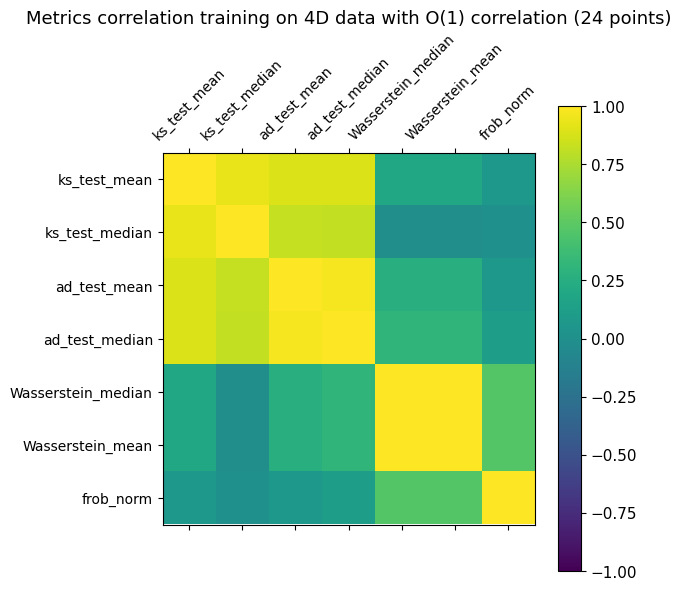

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


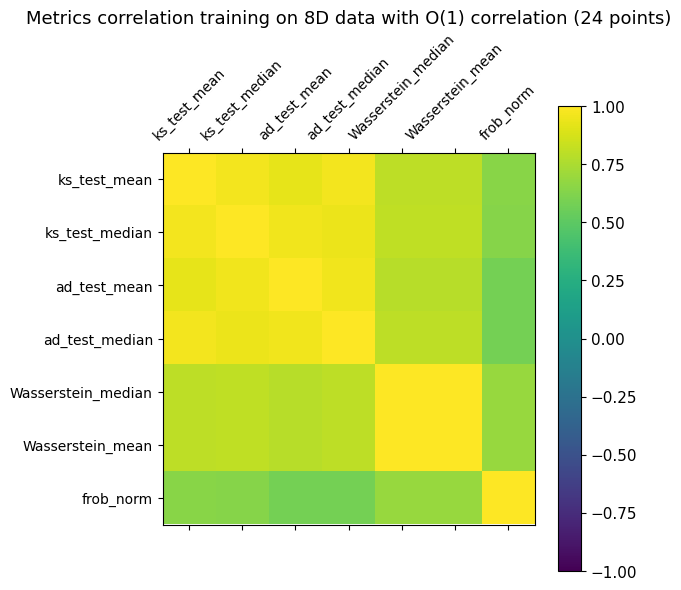

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


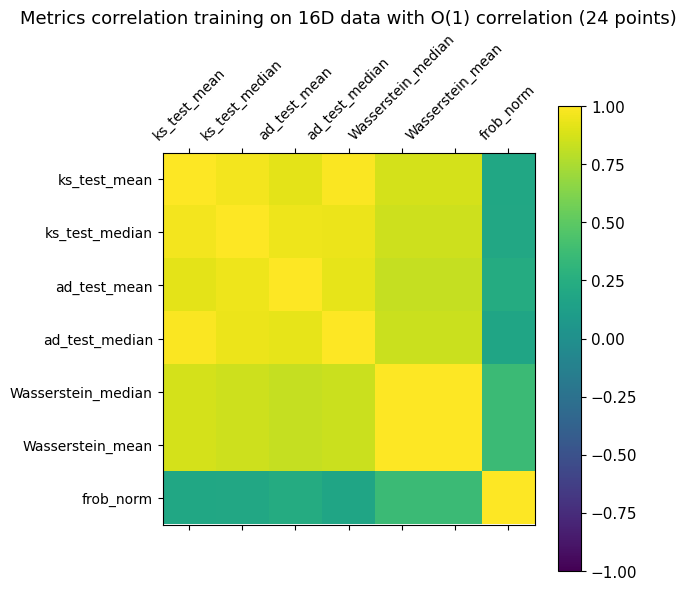

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


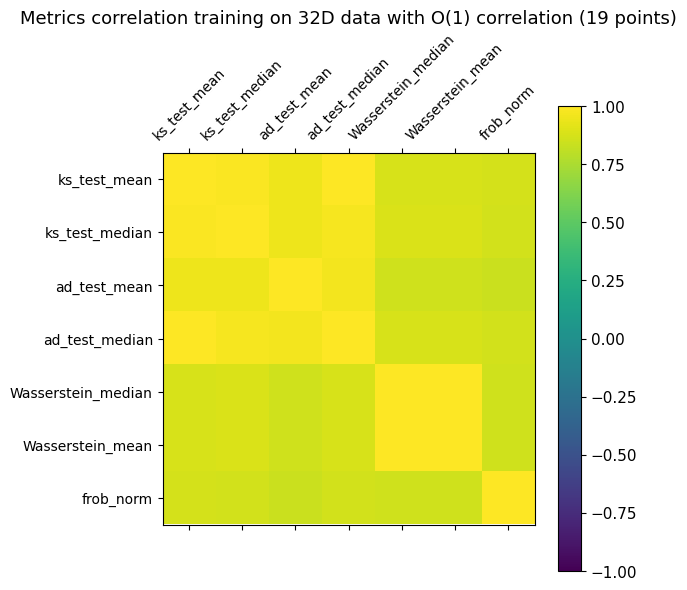

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


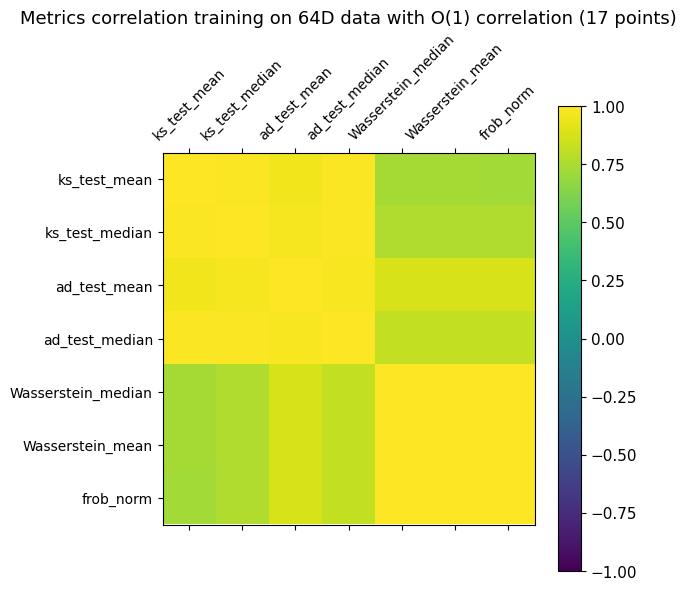

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


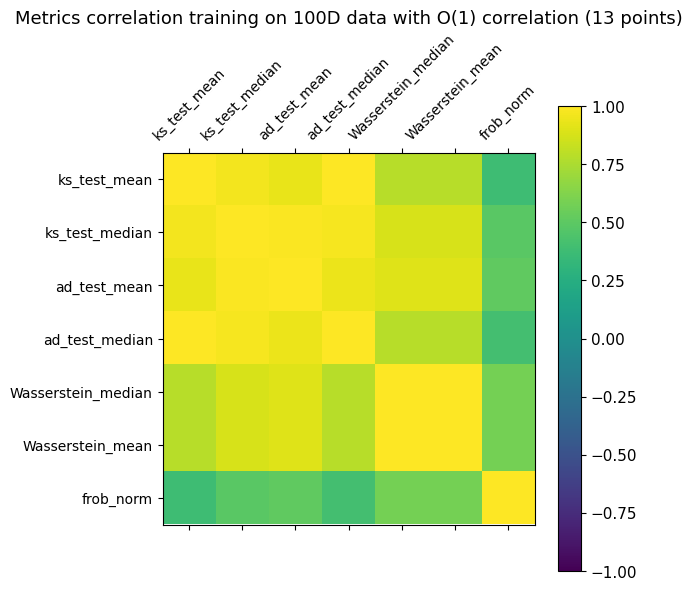

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


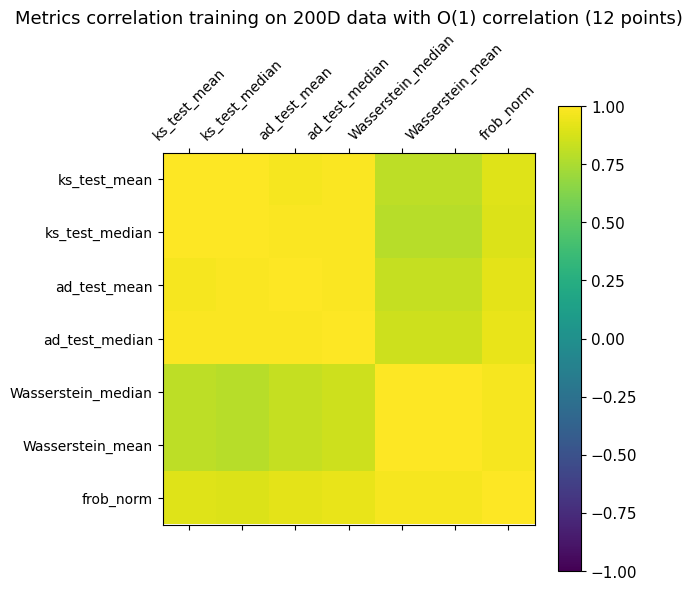

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


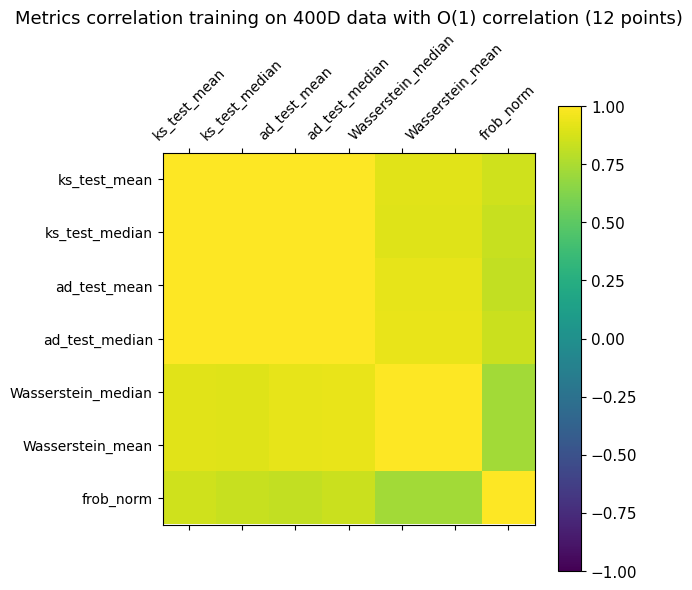

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


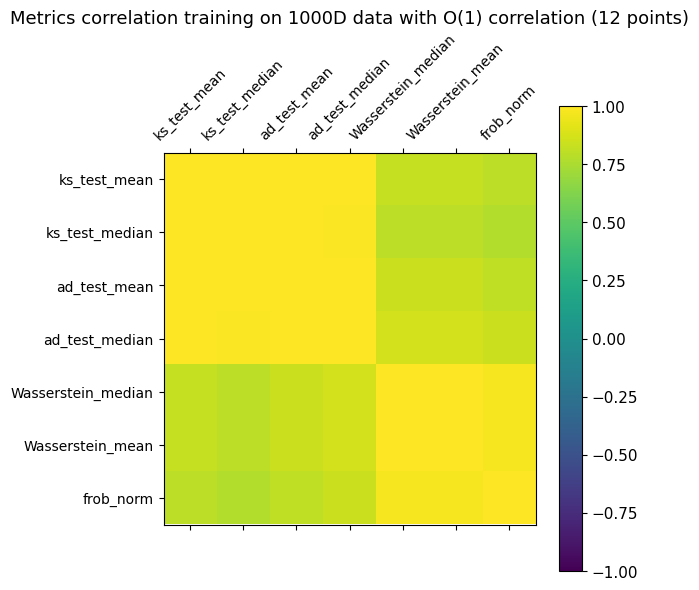

In [19]:
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("color", 'lime')])]
metrics = ["ks_test_mean", "ks_test_median","ad_test_mean", "ad_test_median","Wasserstein_median", "Wasserstein_mean","frob_norm"]
for d in [4,8,16,32,64,100,200,400,1000]:
    df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]
    df=df.astype(float)
    n_points=len(df)
    df['Wasserstein_median'] = df['Wasserstein_median'].apply(lambda x: -x)
    df['Wasserstein_mean'] = df['Wasserstein_mean'].apply(lambda x: -x)
    df['frob_norm'] = df['frob_norm'].apply(lambda x: -x)
    #display(df)
    title = "Metrics correlation training on "+str(d)+"D data with O(1) correlation ("+str(n_points)+" points)"
    corr=df.corr()
    display(corr.style.set_caption(title).set_table_styles(styles))
    jtplot.reset()
    f = plt.figure(figsize=(6, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=11)
    plt.clim(-1, 1) 
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()
    del(df)

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


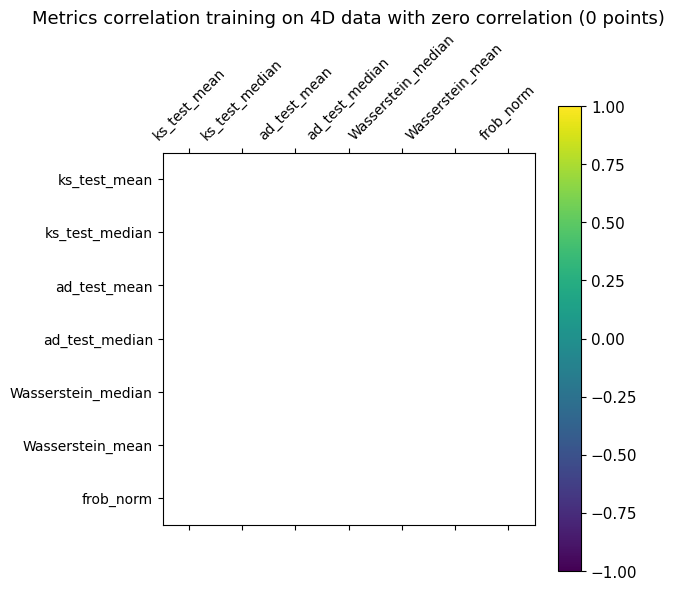

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


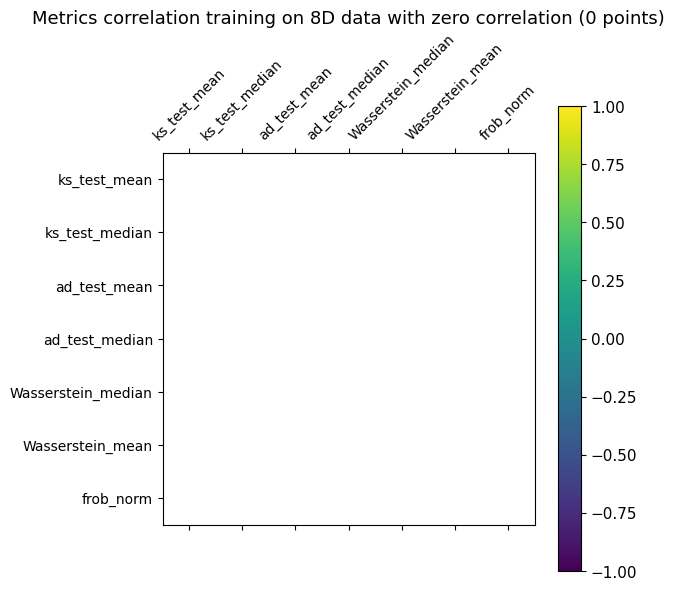

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


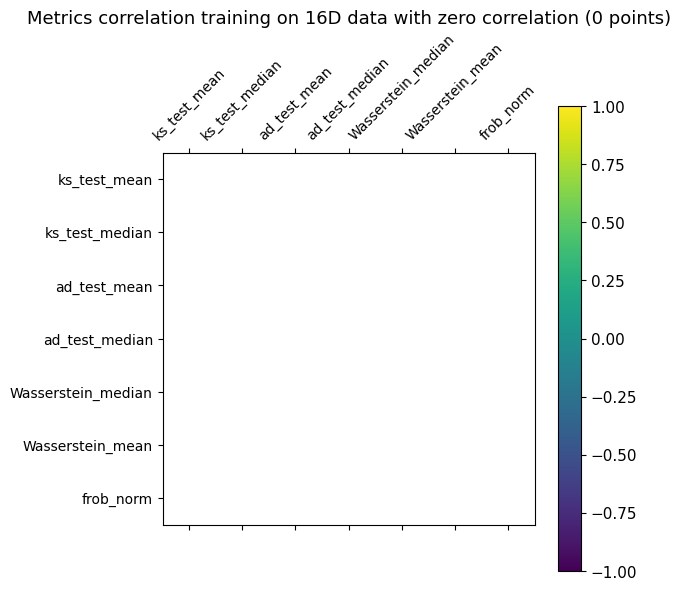

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


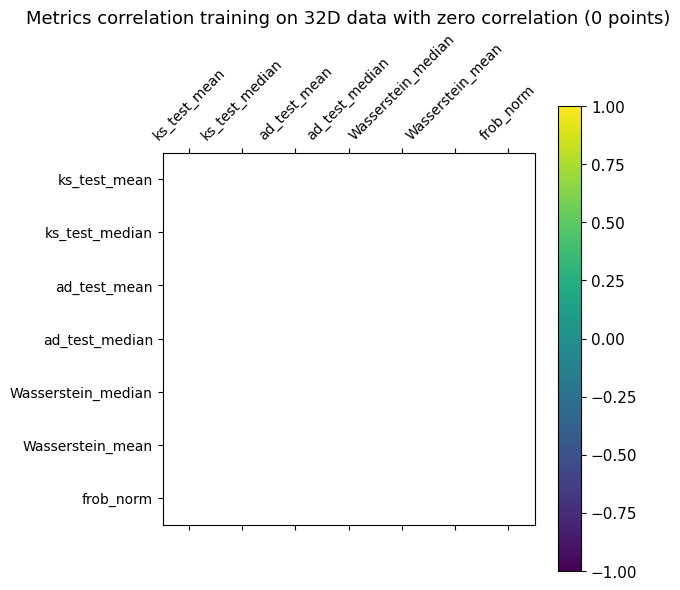

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


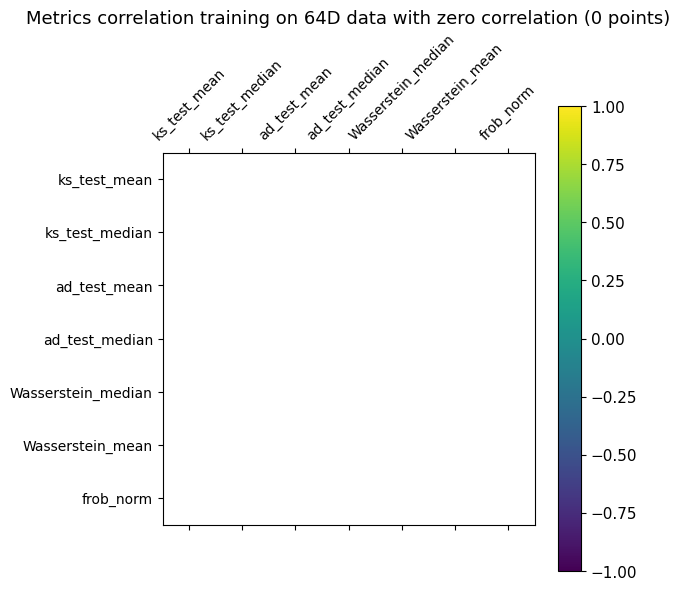

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


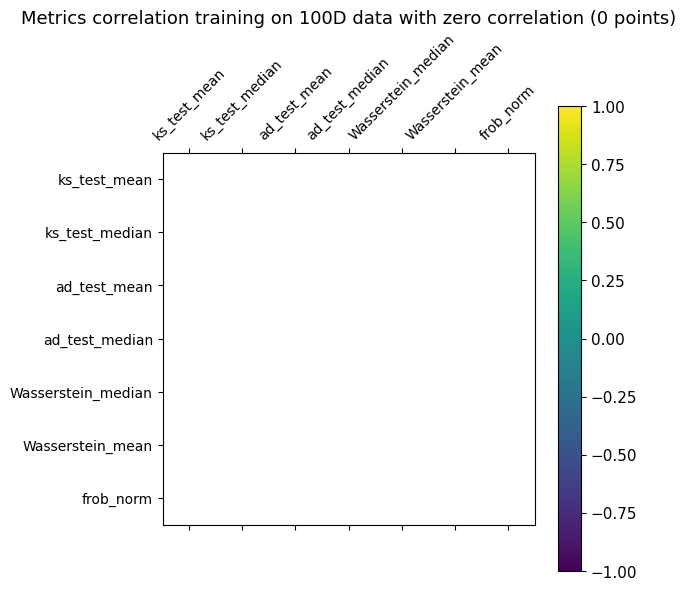

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


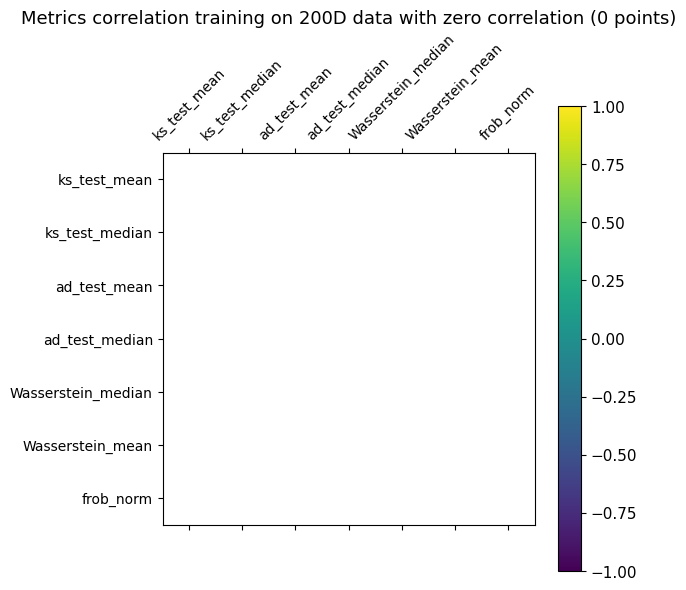

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


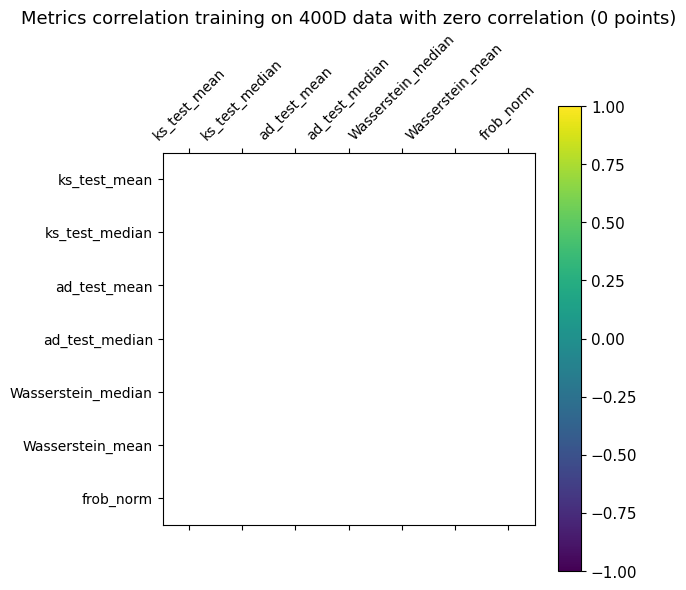

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


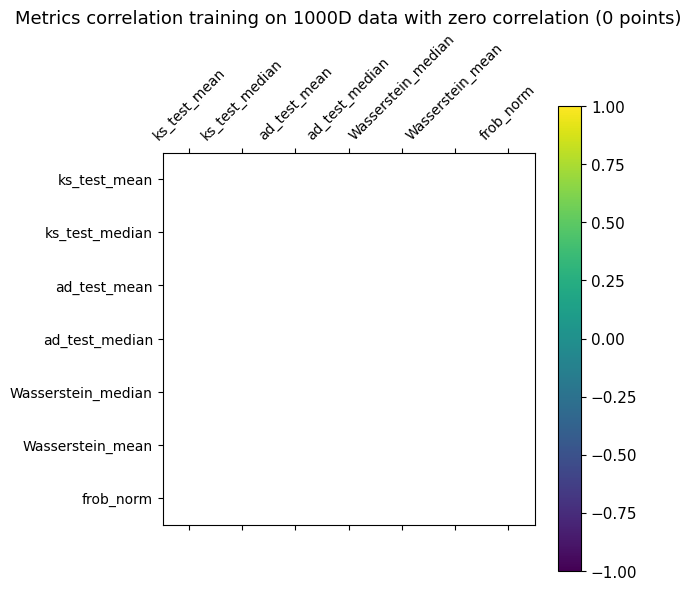

In [20]:
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("color", 'lime')])]
metrics = ["ks_test_mean", "ks_test_median","ad_test_mean", "ad_test_median","Wasserstein_median", "Wasserstein_mean","frob_norm"]
for d in [4,8,16,32,64,100,200,400,1000]:
    df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]
    df=df.astype(float)
    n_points=len(df)
    df['Wasserstein_median'] = df['Wasserstein_median'].apply(lambda x: -x)
    df['Wasserstein_mean'] = df['Wasserstein_mean'].apply(lambda x: -x)
    df['frob_norm'] = df['frob_norm'].apply(lambda x: -x)
    #display(df)
    title = "Metrics correlation training on "+str(d)+"D data with zero correlation ("+str(n_points)+" points)"
    corr=df.corr()
    display(corr.style.set_caption(title).set_table_styles(styles))
    jtplot.reset()
    f = plt.figure(figsize=(6, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=11)
    plt.clim(-1, 1) 
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()
    del(df)

## Results for different dimensions and metrics

In [88]:
verbose=1
df = df_reduced[4]["MAFN"].copy()
#df.pop("seed_train")
#df.pop("seed_test")
df.pop("correlation")
df.pop("nsamples")
df.pop("range_min")
df.pop("eps_regulariser")
df.pop("activation")
df.pop("regulariser")
df.pop("epochs_input")
df.pop("ks_mean")
df.pop("ks_std")
df.pop("ad_mean")
df.pop("ad_std")
df.pop("wd_mean")
df.pop("wd_std")
df.pop("swd_mean")
df.pop("swd_std")
df.pop("fn_mean")
df.pop("fn_std")
df = df.rename(columns={'spline_knots': 'knots'})
nbijectors_list = np.unique(df['nbijectors'])
hidden_layers_list = np.unique(df['hidden_layers'])
spline_knots_list = np.unicode(df['spline_knots'])
#print(nbijectors_list)
print(hidden_layers_list)
print(spline_knots_list)
for nbijectors in nbijectors_list:
    for hidden_layers in hidden_layers_list:
        for spline_knots in spline_knots_list:
            df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]
            display(df_tmp)
#
#tmp = np.array(list(df.pop("ks_list")))
#df['ks_all_mean'] = np.mean(tmp.flatten())
#df['ks_all_std'] = np.std(tmp.flatten())
#tmp = np.array(list(df.pop("ad_list")))
#df['ad_all_mean'] = np.mean(tmp.flatten())
#df['ad_all_std'] = np.std(tmp.flatten())
#tmp = np.array(list(df.pop("wd_list")))
#df['wd_all_mean'] = np.mean(tmp.flatten())
#df['wd_all_std'] = np.std(tmp.flatten())
#tmp = np.array(list(df.pop("swd_list")))
#df['swd_all_mean'] = np.mean(tmp.flatten())
#df['swd_all_std'] = np.std(tmp.flatten())
#tmp = np.array(list(df.pop("fn_list")))
#df['fn_all_mean'] = np.mean(tmp.flatten())
#df['fn_all_std'] = np.std(tmp.flatten())
#tmp = np.array(list(df.pop("training_time")))
#df['tt_all_mean'] = np.mean(tmp.flatten())
#df['tt_all_std'] = np.std(tmp.flatten())
#tmp = np.array(list(df.pop("prediction_time")))
#df['pt_all_mean'] = np.mean(tmp.flatten())
#df['pt_all_std'] = np.std(tmp.flatten())
#nseeds_train = np.unique(list(df["seed_train"]))
#l=0
#i=0
#while l<4:
#    l = len(df[df['seed_train'] == nseeds_train[i]])
#    chosen_seed = nseeds_train[i]
#    i = i+1
#df = df[df['seed_train'] == chosen_seed]
#df['ks'] = np.abs(df['ks_all_mean'] - 0.5)
#df['ks'] = (df['ks'] - df['ks'].mean()) / df['ks'].std()
#df['swd'] = (df['ad_all_mean'] - df['swd_mean'].mean()) / df['swd_mean'].std()
#df['fn'] = (df['fn_mean'] - df['fn_mean'].mean()) / df['fn_mean'].std()
#df['tt'] = (df['training_time'] - df['training_time'].mean()) / df['training_time'].std()
#df['pt'] = (df['prediction_time'] - df['prediction_time'].mean()) / df['prediction_time'].std()
#df['score'] = (df['ks']+df['swd']+df['fn']+(df['tt']+df['pt'])/2)/4
df

['128-128-128' '256-256-256']
0     8
1     8
2     8
3     8
4     8
5     8
6     8
7     8
8     8
9     8
10    8
11    8
12    8
13    8
14    8
15    8
16    8
17    8
18    8
19    8
20    8
21    8
22    8
23    8
24    8
25    8
26    8
27    8
28    8
29    8
30    8
31    8
32    8
33    8
34    8
35    8
36    8
37    8
38    8
39    8
Name: spline_knots, dtype: int64


/tmp/ipykernel_31873/3241272128.py:24: DeprecationWarning: `np.unicode` is a deprecated alias for `np.compat.unicode`. To silence this warning, use `np.compat.unicode` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `str` for which `np.compat.unicode` is itself an alias. Doing this will not modify any behaviour and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spline_knots_list = np.unicode(df['spline_knots'])
/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

/tmp/ipykernel_31873/3241272128.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp = df[df['nbijectors']==nbijectors][df['hidden_layers']==hidden_layers][df['spline_knots']==spline_knots]


Empty DataFrame
Columns: [run_n, seed_train, seed_test, ndims, nbijectors, bijector, spline_knots, hidden_layers, batch_size, epochs_output, training_time, prediction_time, total_time, training_device, ks_list, ad_list, wd_list, swd_list, fn_list]
Index: []

run_n  seed_train  seed_test  ndims  nbijectors bijector  spline_knots  \
0       1           0          1      4           5     MAFN             8   
1       2           0          1      4           5     MAFN             8   
2       3           0          1      4          10     MAFN             8   
3       4      985772     985773      4          10     MAFN             8   
4       5         187        188      4           5     MAFN             8   
5       6         187        188      4           5     MAFN             8   
6       7         187        188      4          10     MAFN             8   
7       8         187        188      4          10     MAFN             8   
8       9         377        378      4           5     MAFN             8   
9      10         377        378      4           5     MAFN             8   
10     11         377        378      4          10     MAFN             8   
11     12         377        378      4          10     MAFN             8   
12     13         440        441      4           5     MAFN             8   
13     14         440        441      4           5     MAFN             8   
14     15      978294     978295      4          10     MAFN             8   
15     16      978294     978295      4          10     MAFN             8   
16     17         520        521      4           5     MAFN             8   
17     18         520        521      4           5     MAFN             8   
18     19         520        521      4          10     MAFN             8   
19     20         520        521      4          10     MAFN             8   
20     21         541        542      4           5     MAFN             8   
21     22         541        542      4           5     MAFN             8   
22     23         541        542      4          10     MAFN             8   
23     24         541        542      4          10     MAFN             8   
24     25         721        722      4           5     MAFN             8   
25     26         721        722      4           5     MAFN             8   
26     27      821433     821434      4          10     MAFN             8   
27     28      821433     821434      4          10     MAFN             8   
28     29         869        870      4           5     MAFN             8   
29     30         869        870      4           5     MAFN             8   
30     31         869        870      4          10     MAFN             8   
31     32         869        870      4          10     MAFN             8   
32     33         926        927      4           5     MAFN             8   
33     34         926        927      4           5     MAFN             8   
34     35      638742     638743      4          10     MAFN             8   
35     36      638742     638743      4          10     MAFN             8   
36     37         933        934      4           5     MAFN             8   
37     38         933        934      4           5     MAFN             8   
38     39         933        934      4          10     MAFN             8   
39     40      402839     402840      4          10     MAFN             8   

   hidden_layers  batch_size  epochs_output  training_time  prediction_time  \
0    128-128-128         512            712    2072.710502         6.660227   
1    256-256-256         512            270     814.488601         4.876127   
2    128-128-128         512             24     139.345636         5.839121   
3    256-256-256         512            396    2172.378848         4.827608   
4    128-128-128         512            600    1772.895936         5.955732   
5    256-256-256         512            391    1170.257169         4.753371   
6    128-128-128         512            661    3580.869131         4.885068   
7    256-256-256         512            450    2479.573362         4.817862   
8    128-128-128         512            533    1597.679878         5.785890   
9    256-256-25

In [ ]:
def choose_best_models(df_reduced)
    

In [81]:
def choose_best_models(ndims, df_correlated,verbose=1):
    print("\n==============================================================")
    print(str(ndims)+"D")
    df_bests = pd.DataFrame()
    df = pd.DataFrame(df_correlated[df_correlated["ndims"]==ndims])
    if verbose>0:
        df.pop("run_seed")
        df.pop("correlation")
        df.pop("nsamples")
        df.pop("range_min")
        df.pop("eps_regulariser")
        df.pop("activation")
        df.pop("regulariser")
        df.pop("epochs_input")
        df = df.rename(columns={'spline_knots': 'knots'})
    df['ks'] = np.abs(df['ks_mean'] - 0.5)
    df['ks'] = (df['ks'] - df['ks'].mean()) / df['ks'].std()
    df['swd'] = (df['swd_mean'] - df['swd_mean'].mean()) / df['swd_mean'].std()
    df['fn'] = (df['fn_mean'] - df['fn_mean'].mean()) / df['fn_mean'].std()
    df['t'] = (df['time'] - df['time'].mean()) / df['time'].std()
    df['score'] = (df['ks']+df['swd']+df['fn']+df['t'])/4
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        print(bijector,"in",ndims,"dimensions.")
        try:
            df_tmp = df[df["bijector"]==bijector]
            df_tmp = df_tmp.sort_values(by="score",axis=0,ascending=True).reset_index(drop=True)
            best_swd = [list(df_tmp["swd_mean"])[0],list(df_tmp["swd_std"])[0]]
            df_tmp_bests_swd = df_tmp[df_tmp["swd_mean"]-df_tmp["swd_std"]<best_swd[0]+best_swd[1]]
            df_tmp_bests_swd = df_tmp_bests_swd.sort_values(by="fn_mean",axis=0,ascending=True).reset_index(drop=True)
            best_fn = [list(df_tmp_bests_swd["fn_mean"])[0],list(df_tmp_bests_swd["fn_std"])[0]]
            df_tmp_bests_swd_fn = df_tmp_bests_swd[df_tmp_bests_swd["fn_mean"]-df_tmp_bests_swd["fn_std"]<best_fn[0]+best_fn[1]]
            df_tmp_bests_swd_fn = df_tmp_bests_swd_fn.sort_values(by="ks_mean",axis=0,ascending=False).reset_index(drop=True)
            best_ks = [list(df_tmp_bests_swd_fn["ks_mean"])[0],list(df_tmp_bests_swd_fn["ks_std"])[0]]
            df_tmp_bests_swd_fn_ks = df_tmp_bests_swd_fn[df_tmp_bests_swd_fn["ks_mean"]+df_tmp_bests_swd_fn["ks_std"]>best_ks[0]-best_ks[1]]
            df_tmp_bests_swd_fn_ks = df_tmp_bests_swd_fn_ks.sort_values(by="score",axis=0,ascending=True).reset_index(drop=True)
            df_bests = pd.concat([df_bests,df_tmp_bests_swd_fn_ks.drop_duplicates('bijector')])
            if df_tmp["run_n"].iloc[0] == df_tmp_bests_swd_fn_ks["run_n"].iloc[0]:
                if verbose>1:
                    #print("==============================================================\n")
                    df_styled = df_tmp.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
                    df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
                    df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
                    display(df_styled)
                print("Best model run_n",df_tmp["run_n"].iloc[0],"satisfies the condition.\n")
                
            else:
                if verbose>1:
                    #print("==============================================================\n")
                    df_styled = df_tmp_bests_swd_fn_ks.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
                    df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
                    df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
                    display(df_styled)
                    df_styled = df_tmp.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
                    df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
                    df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
                    display(df_styled)
                print("Best model run_n",df_tmp["run_n"].iloc[0],"does not satisfy the condition. The best model satisfying the condition is",df_tmp_bests_swd_fn_ks["run_n"].iloc[0],".\n")
        except:
            print("No models available for",bijector,"in",ndims,"dimensions.")
    df_bests = df_bests.sort_values(by="score",axis=0,ascending=True).reset_index(drop=True)
    if verbose>0:
        df_styled = df_bests.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
        df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
        df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
        display(df_styled)
    df_bests.pop('ks')
    df_bests.pop('swd')
    df_bests.pop('fn')
    df_bests.pop('t')
    df_bests.pop('score')
    return df_bests

In [123]:
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
tmp = df_correlated[df_correlated["ndims"]==100]
tmp = tmp[tmp["bijector"]=="CsplineN"]
tmp = tmp.sort_values(by="swd_mean",axis=0,ascending=True).reset_index(drop=True)
df_styled = tmp.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd_mean', 'fn_mean','time'])
df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
display(df_styled)

In [46]:
choose_best_models(16, df_correlated,verbose=1)


16D
MAFN in 16 dimensions.
Best model run_n 10 does not satisfy the condition. The best model satisfying the condition is 11 .

RealNVPN in 16 dimensions.
Best model run_n 11 satisfies the condition.

MsplineN in 16 dimensions.
Best model run_n 9 satisfies the condition.

CsplineN in 16 dimensions.
Best model run_n 29 satisfies the condition.



run_n  ndims  nbijectors  bijector  knots   ks_mean    ks_std   ad_mean  \
0      9     16           2  MsplineN      8  0.389807  0.300205  0.181968   
1     11     16          10      MAFN      8  0.156714  0.218286  0.084549   
2     11     16          10  RealNVPN      8  0.121486  0.223104  0.063109   
3     29     16           5  CsplineN     12  0.082406  0.152051  0.056380   

     ad_std   wd_mean    wd_std  swd_mean   swd_std   fn_mean    fn_std  \
0  0.092887  0.021258  0.015035  0.021876  0.012232  0.214692  0.074798   
1  0.100365  0.031671  0.021635  0.033720  0.017049  0.337253  0.146824   
2  0.094089  0.034802  0.019101  0.035722  0.017050  0.701918  0.173977   
3  0.082143  0.039781  0.024296  0.043779  0.023433  0.414928  0.085586   

  hidden_layers  batch_size  epochs_output         time  
0   128-128-128         512            184   980.492019  
1   128-128-128         512            153  1203.660969  
2   128-128-128         256            147  1403.085339  
3   256-256-256         512             94  2109.738483

In [47]:
def compute_uncertainties(ndims, df_correlated_unc,verbose=1):
    print("\n==============================================================")
    print(str(ndims)+"D")
    df = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims])
    df_unc = pd.DataFrame(df.drop_duplicates('bijector'))
    #df_unc = df_unc.drop(["ks_list","ad_list","wd_list","swd_list","fn_list"],axis=1)
    df_unc = df_unc.drop(["ks_list","ks_mean","ks_std",
                          "ad_list","ad_mean","ad_std",
                          "wd_list","wd_mean","wd_std",
                          "swd_list","swd_mean","swd_std",
                          "fn_list","fn_mean","fn_std"],axis=1)
    df_unc['ks_all_mean'] = None
    df_unc['ks_all_std'] = None
    df_unc['ad_all_mean'] = None
    df_unc['ad_all_std'] = None
    df_unc['wd_all_mean'] = None
    df_unc['wd_all_std'] = None
    df_unc['swd_all_mean'] = None
    df_unc['swd_all_std'] = None
    df_unc['fn_all_mean'] = None
    df_unc['fn_all_std'] = None
    print("\n================================   ",str(ndims)+"D   ======================================")
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        try:
            rry = np.array(list(df[df["bijector"]==bijector]["ks_list"]))
            df_unc.loc[df_unc["bijector"]==bijector,'ks_all_mean'] = np.mean(rry.flatten())
            df_unc.loc[df_unc["bijector"]==bijector,'ks_all_std'] = np.std(rry.flatten())
            rry = np.array(list(df[df["bijector"]==bijector]["ad_list"]))
            df_unc.loc[df_unc["bijector"]==bijector,'ad_all_mean'] = np.mean(rry.flatten())
            df_unc.loc[df_unc["bijector"]==bijector,'ad_all_std'] = np.std(rry.flatten())
            rry = np.array(list(df[df["bijector"]==bijector]["wd_list"]))
            df_unc.loc[df_unc["bijector"]==bijector,'wd_all_mean'] = np.mean(rry.flatten())
            df_unc.loc[df_unc["bijector"]==bijector,'wd_all_std'] = np.std(rry.flatten())
            rry = np.array(list(df[df["bijector"]==bijector]["swd_list"]))
            df_unc.loc[df_unc["bijector"]==bijector,'swd_all_mean'] = np.mean(rry.flatten())
            df_unc.loc[df_unc["bijector"]==bijector,'swd_all_std'] = np.std(rry.flatten())
            rry = np.array(list(df[df["bijector"]==bijector]["fn_list"]))
            df_unc.loc[df_unc["bijector"]==bijector,'fn_all_mean'] = np.mean(rry.flatten())
            df_unc.loc[df_unc["bijector"]==bijector,'fn_all_std'] = np.std(rry.flatten())
            rry = np.array(list(df[df["bijector"]==bijector]["time"]))
            df_unc.loc[df_unc["bijector"]==bijector,'time_all_mean'] = np.mean(rry.flatten())
            df_unc.loc[df_unc["bijector"]==bijector,'time_all_std'] = np.std(rry.flatten())
            rry = np.array(list(df[df["bijector"]==bijector]["epochs_output"]))
            df_unc.loc[df_unc["bijector"]==bijector,'epochs_all_mean'] = np.mean(rry.flatten())
            df_unc.loc[df_unc["bijector"]==bijector,'epochs_all_std'] = np.std(rry.flatten())
            if verbose:
                print("-------------------------------------------------------------------------------")
                print(bijector,"bijector in",ndims,"dimensions.")
                print("KS:",[df_unc['ks_all_mean'].loc[i], df_unc['ks_all_std'].loc[i]])
                print("AD:",[df_unc['ad_all_mean'].loc[i], df_unc['ad_all_std'].loc[i]])
                print("WD:",[df_unc['wd_all_mean'].loc[i], df_unc['wd_all_std'].loc[i]])
                print("SWD:",[df_unc['swd_all_mean'].loc[i], df_unc['swd_all_std'].loc[i]])
                print("FN:",[df_unc['fn_all_mean'].loc[i], df_unc['fn_all_std'].loc[i]])
                print("Epochs:",[df_unc['epochs_all_mean'].loc[i], df_unc['epochs_all_mean'].loc[i]])
                print("Time:",[df_unc['time_all_mean'].loc[i], df_unc['time_all_std'].loc[i]])
        except:
            pass
    df_unc['ks_all'] = np.abs(df_unc['ks_all_mean'] - 0.5)
    df_unc['ks_all'] = (df_unc['ks_all'] - df_unc['ks_all'].mean()) / df_unc['ks_all'].std()
    df_unc['swd_all'] = (df_unc['swd_all_mean'] - df_unc['swd_all_mean'].mean()) / df_unc['swd_all_mean'].std()
    df_unc['fn_all'] = (df_unc['fn_all_mean'] - df_unc['fn_all_mean'].mean()) / df_unc['fn_all_mean'].std()
    df_unc['t_all'] = (df_unc['time_all_mean'] - df_unc['time_all_mean'].mean()) / df_unc['time_all_mean'].std()
    df_unc['score_all'] = (df_unc['ks_all']+df_unc['swd_all']+df_unc['fn_all']+df_unc['t_all'])/4
    df_unc = df_unc.sort_values(by="score_all",axis=0,ascending=True).reset_index(drop=True)
    if verbose:
        df_styled = df_unc.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
        df_styled = df_styled.apply(dataframe_highlight_min, subset=['fn_all','t_all','swd_all','swd_all_mean','fn_all_mean','time_all_mean','score_all'])
        df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_all','ks_all_mean'])
        display(df_styled)
    return df_unc

In [48]:
compute_uncertainties(4, df_correlated_unc,verbose=0)


4D

================================    4D   ======================================


run_n run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0      1      NaN      4    100000        None           2  MsplineN   
1      1      NaN      4    100000        None           5      MAFN   
2      1      NaN      4    100000        None           5  CsplineN   
3      1      NaN      4    100000        None          10  RealNVPN   

  activation  spline_knots  range_min  eps_regulariser regulariser  \
0       relu             8        -16                0        None   
1       relu             8         -5                0        None   
2       relu             8        -16                0        None   
3       relu             8         -5                0        None   

  hidden_layers  batch_size  epochs_input  epochs_output        time  \
0   128-128-128         512             2          385.0   72.255789   
1   256-256-256         512             2          475.0   27.006275   
2   128-128-128         512             2          289.0  311.298180   
3   256-256-256         256             2          456.0  108.909704   

   seed_train  seed_test ks_all_mean ks_all_std ad_all_mean ad_all_std  \
0         0.0        1.0    0.339781   0.287386    0.170052   0.097098   
1         0.0        1.0    0.298643   0.270425    0.153828   0.099109   
2         0.0        1.0    0.294399   0.273805    0.161983   0.099418   
3         0.0        1.0    0.283508   0.284873    0.145032   0.102709   

  wd_all_mean wd_all_std swd_all_mean swd_all_std fn_all_mean fn_all_std  \
0    0.032241   0.014082     0.030883    0.017212    0.032783   0.018709   
1    0.029494   0.011602     0.029641    0.013426    0.036954    0.01461   
2    0.029477   0.012568     0.029627    0.013598    0.029343   0.013109   
3    0.030964   0.012707     0.030783    0.014978    0.032918   0.014931   

   time_all_mean  time_all_std  epochs_all_mean  epochs_all_std    ks_all  \
0      99.094724     11.164344            408.0       53.942562 -1.448931   
1      31.660236      6.842121            394.1       42.683603  0.220796   
2     316.629093     25.634926            331.7       70.878840   0.39306   
3     131.203869     33.725773            323.8       91.386870  0.835075   

    swd_all    fn_all     t_all score_all  
0  0.936415 -0.069584 -0.373599 -0.238925  
1 -0.854883  1.270535 -0.926665 -0.072554  
2 -0.874127 -1.174826  1.410518 -0.061344  
3  0.792594 -0.026125 -0.110254  0.372822

In [108]:
def final_model_list(ndims, df_correlated,df_correlated_unc,verbose=0):
    print("\nxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print("\nCombining results in",ndims,"dimensions.")
    excluded_columns = ["run_n","run_seed","correlation",
                        "range_min","eps_regulariser","regulariser","epochs_input",]
    tmp_val = choose_best_models(ndims, df_correlated,verbose=0).drop(excluded_columns,axis=1)
    tmp_unc = compute_uncertainties(ndims, df_correlated_unc,verbose=0).drop(excluded_columns,axis=1).drop(["time","epochs_output"],axis=1)
    tmp_val['ndims'] = tmp_val['ndims'].astype(int)
    tmp_unc['ndims'] = tmp_unc['ndims'].astype(int)
    df_final = pd.merge(tmp_val,tmp_unc,on=['ndims','nsamples','nbijectors','bijector','activation','spline_knots','hidden_layers','batch_size'])
    df_final = df_final.drop(["seed_train","seed_test"],axis=1)
    df_final['time_all_std'] = df_final['time_all_mean']/2*df_final['epochs_all_std']
    df_final['time_all_mean'] = df_final['time_all_mean']/2*df_final['epochs_all_mean']
    if verbose:
        df_styled = df_final.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
        df_styled = df_styled.apply(dataframe_highlight_min, subset=['wd_all_mean','swd_all_mean','fn_all_mean','time_all_mean'])
        df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_all_mean','ad_all_mean'])
        display(df_styled)
    return df_final

In [109]:
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
res = final_model_list(400, df_correlated,df_correlated_unc,verbose=0)
display(res)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Combining results in 400 dimensions.

400D
MAFN in 400 dimensions.
Best model run_n 29 satisfies the condition.

RealNVPN in 400 dimensions.
Best model run_n 32 does not satisfy the condition. The best model satisfying the condition is 31 .

MsplineN in 400 dimensions.
Best model run_n 29 does not satisfy the condition. The best model satisfying the condition is 32 .

CsplineN in 400 dimensions.
No models available for CsplineN in 400 dimensions.

400D

================================    400D   ======================================


ndims  nsamples  nbijectors  bijector activation  spline_knots   ks_mean  \
0    400    100000           2  MsplineN       relu            12  0.198781   
1    400    100000           5      MAFN       relu             8  0.190839   
2    400    100000          10  RealNVPN       relu             8  0.006544   

     ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
0  0.247171  0.118666  0.101357  0.049053  0.034257  0.049680  0.034863   
1  0.217393  0.094988  0.096954  0.053988  0.031114  0.053309  0.033999   
2  0.045110  0.004440  0.022083  0.165279  0.093776  0.162676  0.104869   

     fn_mean    fn_std hidden_layers  batch_size  epochs_output         time  \
0   5.069650  0.759021   256-256-256         512            177  1894.098027   
1  19.058362  1.626591   128-128-128         512            365  1447.374315   
2  41.830002  1.605456   128-128-128         256            350  3943.314110   

  ks_all_mean ks_all_std ad_all_mean ad_all_std wd_all_mean wd_all_std  \
0    0.252747   0.263752    0.130104   0.103741    0.048057   0.031627   
1    0.098455   0.179613    0.052551   0.083549    0.075199   0.047377   
2    0.062048   0.154662    0.034009   0.072294    0.110422   0.095169   

  swd_all_mean swd_all_std fn_all_mean fn_all_std  time_all_mean  \
0     0.046955    0.032837   14.456069    9.11612    5032.759145   
1     0.072925    0.048387   38.585749  16.880228    5570.268796   
2     0.106046    0.096284   34.563766  18.465052   11704.064676   

   time_all_std  epochs_all_mean  epochs_all_std    ks_all   swd_all  \
0   1999.583400            264.4      105.049703 -1.135881 -0.957328   
1   1383.280868            481.7      119.621946  0.388134 -0.080481   
2   4780.974833            313.5      128.061118  0.747748  1.037809   

     fn_all     t_all score_all  
0 -1.140644 -0.272226  -0.87652  
1   0.72588 -0.835699  0.049458  
2  0.414764  1.107926  0.827061

In [96]:
df_best_corr = {}
ndims_list = [4,8,16,32,64,100,200,400,1000]
for ndims in ndims_list:
    df_best_corr[ndims] = final_model_list(ndims, df_correlated,df_correlated_unc,verbose=0)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Combining results in 4 dimensions.

4D
MAFN in 4 dimensions.
Best model run_n 2 satisfies the condition.

RealNVPN in 4 dimensions.
Best model run_n 4 satisfies the condition.

MsplineN in 4 dimensions.
Best model run_n 1 satisfies the condition.

CsplineN in 4 dimensions.
Best model run_n 1 satisfies the condition.


4D

================================    4D   ======================================

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Combining results in 8 dimensions.

8D
MAFN in 8 dimensions.
Best model run_n 5 satisfies the condition.

RealNVPN in 8 dimensions.
Best model run_n 5 satisfies the condition.

MsplineN in 8 dimensions.
Best model run_n 7 satisfies the condition.

CsplineN in 8 dimensions.
Best model run_n 16 satisfies the condition.


8D

================================    8D   ======================================

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Best models

In [97]:
df_bests_corr = list(df_best_corr.values())

In [98]:
df_bests_corr[0]

ndims  nsamples  nbijectors  bijector activation  spline_knots   ks_mean  \
0      4    100000           2  MsplineN       relu             8  0.495217   
1      4    100000           5  CsplineN       relu             8  0.548395   
2      4    100000          10  RealNVPN       relu             8  0.307817   
3      4    100000           5      MAFN       relu             8  0.319240   

     ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
0  0.251435  0.216209  0.066911  0.026842  0.012460  0.027267  0.011680   
1  0.297681  0.218421  0.064449  0.023984  0.010414  0.025026  0.010843   
2  0.255519  0.188032  0.080101  0.026637  0.008139  0.026858  0.011076   
3  0.235655  0.196969  0.076791  0.027648  0.011148  0.027307  0.011358   

    fn_mean    fn_std hidden_layers  batch_size  epochs_output         time  \
0  0.017926  0.010255   128-128-128         512            360  1878.589050   
1  0.022538  0.006425   128-128-128         512            310  8690.510488   
2  0.018490  0.008663   256-256-256         256            337  3307.465860   
3  0.034974  0.014084   256-256-256         512            361   833.398603   

  ks_all_mean ks_all_std ad_all_mean ad_all_std wd_all_mean wd_all_std  \
0    0.339781   0.287386    0.170052   0.097098    0.032241   0.014082   
1    0.294399   0.273805    0.161983   0.099418    0.029477   0.012568   
2    0.283508   0.284873    0.145032   0.102709    0.030964   0.012707   
3    0.298643   0.270425    0.153828   0.099109    0.029494   0.011602   

  swd_all_mean swd_all_std fn_all_mean fn_all_std  time_all_mean  \
0     0.030883    0.017212    0.032783   0.018709   20215.323631   
1     0.029627    0.013598    0.029343   0.013109   52512.935121   
2     0.030783    0.014978    0.032918   0.014931   21241.906413   
3     0.029641    0.013426    0.036954    0.01461    6238.649467   

   time_all_std  epochs_all_mean  epochs_all_std    ks_all   swd_all  \
0   2672.711640            408.0       53.942562 -1.448931  0.936415   
1  11221.151466            331.7       70.878840   0.39306 -0.874127   
2   5995.155463            323.8       91.386870  0.835075  0.792594   
3    675.686475            394.1       42.683603  0.220796 -0.854883   

     fn_all     t_all score_all  
0 -0.069584 -0.373599 -0.238925  
1 -1.174826  1.410518 -0.061344  
2 -0.026125 -0.110254  0.372822  
3  1.270535 -0.926665 -0.072554

In [99]:
tmp=pd.concat(df_bests_corr)
tmp2=tmp[tmp["ndims"]==1000]
tmp2

ndims  nsamples  nbijectors  bijector activation  spline_knots   ks_mean  \
0   1000    100000           2  MsplineN       relu            12  0.316068   
1   1000    100000          10  RealNVPN       relu             8  0.045537   
2   1000    100000           5      MAFN       relu             8  0.000368   

     ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
0  0.269729  0.172225  0.092750  0.048057  0.031424  0.047343  0.033612   
1  0.130544  0.036360  0.069552  0.091714  0.057040  0.088442  0.060393   
2  0.008530  0.001294  0.007305  0.411548  0.222126  0.397733  0.241755   

     fn_mean    fn_std hidden_layers  batch_size  epochs_output         time  \
0  10.149433  3.458301   256-256-256         512            365  7521.283210   
1  19.364134  3.524483   128-128-128         256            592  8504.733501   
2  79.985115  1.506296   128-128-128         512            133   502.933207   

  ks_all_mean ks_all_std ad_all_mean ad_all_std wd_all_mean wd_all_std  \
0    0.270992   0.293843    0.137083   0.109768    0.122536   0.195093   
1    0.005158   0.047676    0.004674   0.025154    0.587748   0.632053   
2    0.031168   0.116358    0.020881   0.059314    0.292568   0.294113   

  swd_all_mean swd_all_std fn_all_mean  fn_all_std  time_all_mean  \
0     0.120636    0.201814   28.726037   43.286224   5.262842e+06   
1     0.565075     0.66935   159.27643  147.110959   4.584463e+03   
2     0.288866    0.300983   60.179205   34.493143   2.470793e+05   

    time_all_std  epochs_all_mean  epochs_all_std    ks_all   swd_all  \
0  622435.790261       870.888889      102.999940 -1.150145 -0.910105   
1    2469.398077       238.000000      128.197504  0.663813  1.070505   
2  135661.347011       440.700000      241.970680  0.486332   -0.1604   

     fn_all     t_all score_all  
0  -0.79258  1.150885 -0.425486  
1  1.123519 -0.656669  0.550292  
2 -0.330939 -0.494216 -0.124806

In [122]:
tmp=pd.concat(df_bests_corr)
tmp2=tmp[tmp["bijector"]=="CsplineN"]
tmp2

ndims  nsamples  nbijectors  bijector activation  spline_knots   ks_mean  \
1      4    100000           5  CsplineN       relu             8  0.548395   
3      8    100000           5  CsplineN       relu            12  0.212602   
3     16    100000           5  CsplineN       relu            12  0.082406   
3     32    100000           5  CsplineN       relu             8  0.185068   
3     64    100000           5  CsplineN       relu            12  0.160002   
3    100    100000           5  CsplineN       relu             8  0.013936   

     ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
1  0.297681  0.218421  0.064449  0.023984  0.010414  0.025026  0.010843   
3  0.251691  0.123571  0.105643  0.037808  0.021300  0.039667  0.020258   
3  0.152051  0.056380  0.082143  0.039781  0.024296  0.043779  0.023433   
3  0.214728  0.100431  0.098139  0.048057  0.023594  0.045478  0.025130   
3  0.212593  0.100571  0.098490  0.051769  0.028621  0.050309  0.032722   
3  0.047890  0.014690  0.040824  0.107336  0.060951  0.105275  0.063527   

    fn_mean    fn_std hidden_layers  batch_size  epochs_output         time  \
1  0.022538  0.006425   128-128-128         512            310  8690.510488   
3  0.079876  0.023003   128-128-128         512            198  5022.062892   
3  0.414928  0.085586   256-256-256         512             94  2109.738483   
3  0.738436  0.190337   128-128-128         512            210  4539.380781   
3  0.858337  0.171722   128-128-128         512            249  6506.313299   
3  2.368010  0.281556   512-512-512         512            148  3317.098976   

  ks_all_mean ks_all_std ad_all_mean ad_all_std wd_all_mean wd_all_std  \
1    0.294399   0.273805    0.161983   0.099418    0.029477   0.012568   
3    0.200246   0.252301    0.103612   0.105989    0.048794    0.03381   
3    0.050661    0.13868    0.026492   0.064401    0.056878   0.040292   
3     0.10349   0.197288    0.054451   0.087412    0.062582   0.043478   
3     0.15389   0.226709    0.088631   0.101894    0.076784   0.089318   
3    0.014911   0.067518    0.010834   0.037754     0.30667   0.905574   

  swd_all_mean swd_all_std fn_all_mean fn_all_std  time_all_mean  \
1     0.029627    0.013598    0.029343   0.013109   52512.935121   
3     0.049099    0.032046    0.103845   0.040585   35864.232884   
3     0.059971    0.034929    0.660644   0.324808   17293.947655   
3     0.061615    0.043515    0.762169   0.205637   28710.957007   
3     0.076973    0.087373    1.529634   1.840033   23136.804216   
3     0.370448    0.890677    8.840667  17.140851    9209.738119   

   time_all_std  epochs_all_mean  epochs_all_std    ks_all   swd_all  \
1  11221.151466            331.7       70.878840   0.39306 -0.874127   
3   2181.073655            192.5       11.706836  0.846547  1.038238   
3   1201.773523             94.9        6.594695  0.933876  1.055838   
3   5472.687306            174.2       33.204819  0.797906  0.890065   
3   8719.284757            309.9      116.788227  0.971231  1.180706   
3   1079.689439            133.3       15.627220  0.984975   1.47162   

     fn_all     t_all score_all  
1 -1.174826  1.410518 -0.061344  
3   1.30002 -0.424895  0.689977  
3 -0.102894 -0.444036  0.360696  
3   1.03538 -0.400064  0.580822  
3  1.424251 -0.399415  0.794193  
3   1.48301  1.393648  1.333313

## Plots

### Wasserstein distance

In [57]:
MsplineN_corr_WD = extract_lines(df_bests_corr,"MsplineN","swd_mean",replicas=False)
CsplineN_corr_WD = extract_lines(df_bests_corr,"CsplineN","swd_mean",replicas=False)
MAFN_corr_WD = extract_lines(df_bests_corr,"MAFN","swd_mean",replicas=False)
RealNVPN_corr_WD = extract_lines(df_bests_corr,"RealNVPN","swd_mean",replicas=False)

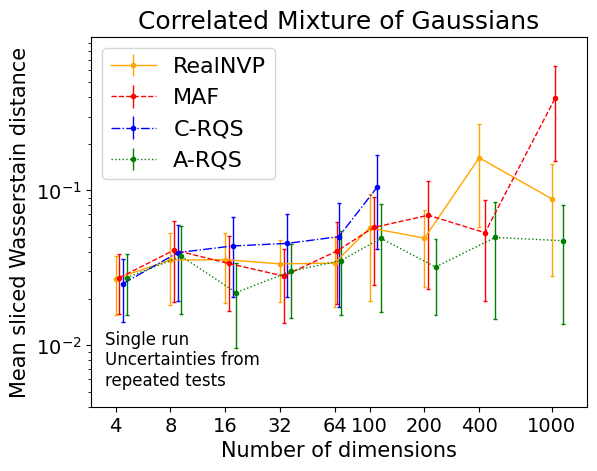

In [58]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_WD[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean sliced Wasserstain distance', fontsize=fontsize_y)
plt.ylim(0.004,0.98)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(3.5, 0.008, 'Single run\nUncertainties from\nrepeated tests', fontsize=12, ha='left', va='center')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_WD_median_corr_1.pdf')
plt.show()
plt.close()

In [59]:
MsplineN_corr_WD = extract_lines(df_bests_corr,"MsplineN","swd_mean",replicas=True)
CsplineN_corr_WD = extract_lines(df_bests_corr,"CsplineN","swd_mean",replicas=True)
MAFN_corr_WD = extract_lines(df_bests_corr,"MAFN","swd_mean",replicas=True)
RealNVPN_corr_WD = extract_lines(df_bests_corr,"RealNVPN","swd_mean",replicas=True)

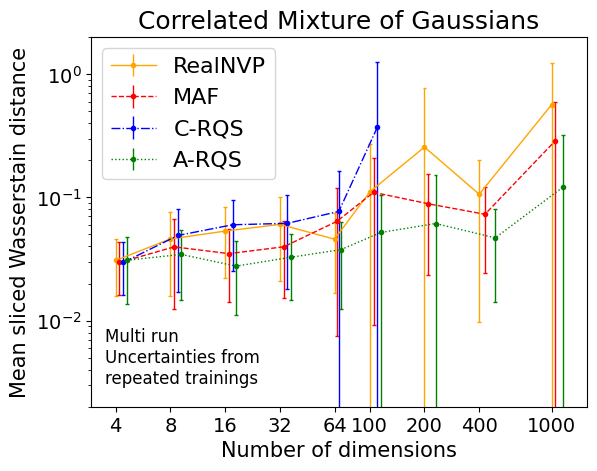

In [60]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_WD[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean sliced Wasserstain distance', fontsize=fontsize_y)
plt.ylim(0.002,2)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(3.5, 0.005, 'Multi run\nUncertainties from\nrepeated trainings', fontsize=12, ha='left', va='center')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_WD_median_corr_2.pdf')
plt.show()
plt.close()

### KS

In [61]:
MsplineN_corr_KS = extract_lines(df_bests_corr,"MsplineN","ks_mean",replicas=False)
CsplineN_corr_KS = extract_lines(df_bests_corr,"CsplineN","ks_mean",replicas=False)
MAFN_corr_KS = extract_lines(df_bests_corr,"MAFN","ks_mean",replicas=False)
RealNVPN_corr_KS = extract_lines(df_bests_corr,"RealNVPN","ks_mean",replicas=False)

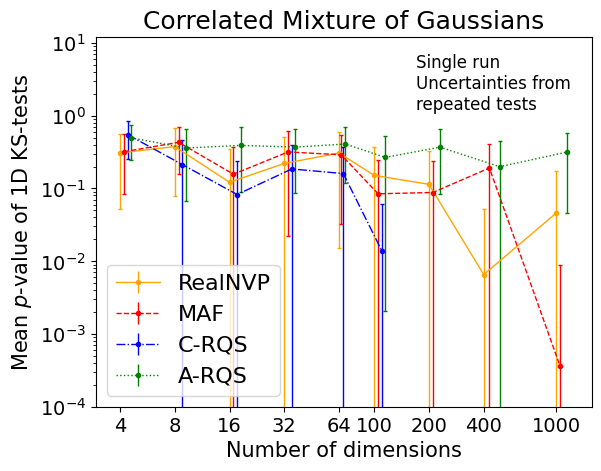

In [62]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_KS[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean $p$-value of 1D KS-tests', fontsize=fontsize_y)
plt.ylim(0.0001,12)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="lower left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 7, 'Single run\nUncertainties from\nrepeated tests', fontsize=12, ha='left', va='top')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_KS_median_corr_1.pdf')
plt.show()
plt.close()

In [63]:
MsplineN_corr_KS = extract_lines(df_bests_corr,"MsplineN","ks_mean",replicas=True)
CsplineN_corr_KS = extract_lines(df_bests_corr,"CsplineN","ks_mean",replicas=True)
MAFN_corr_KS = extract_lines(df_bests_corr,"MAFN","ks_mean",replicas=True)
RealNVPN_corr_KS = extract_lines(df_bests_corr,"RealNVPN","ks_mean",replicas=True)

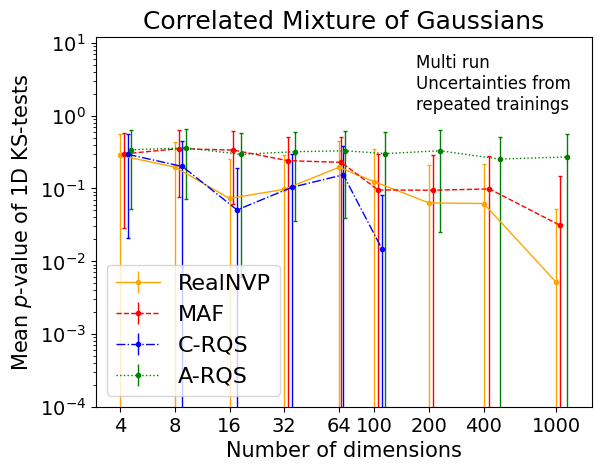

In [64]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_KS[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean $p$-value of 1D KS-tests', fontsize=fontsize_y)
plt.ylim(0.0001,12)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="lower left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 7, 'Multi run\nUncertainties from\nrepeated trainings', fontsize=12, ha='left', va='top')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_KS_median_corr_2.pdf')
plt.show()
plt.close()

### Frobenius-norm

In [65]:
MsplineN_corr_FN = extract_lines(df_bests_corr,"MsplineN","fn_mean",replicas=False)
CsplineN_corr_FN = extract_lines(df_bests_corr,"CsplineN","fn_mean",replicas=False)
MAFN_corr_FN = extract_lines(df_bests_corr,"MAFN","fn_mean",replicas=False)
RealNVPN_corr_FN = extract_lines(df_bests_corr,"RealNVPN","fn_mean",replicas=False)

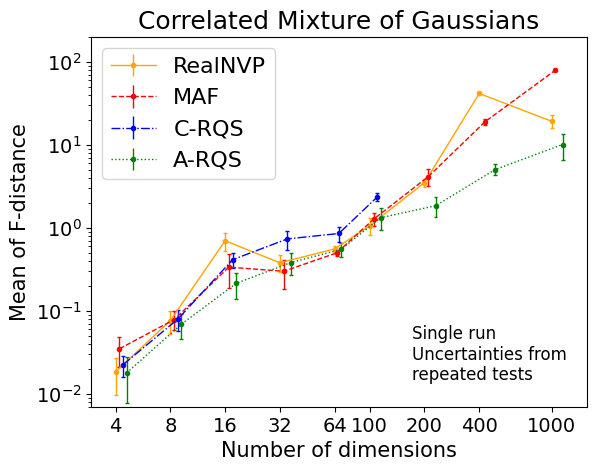

In [66]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_FN[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean of F-distance', fontsize=fontsize_y)
plt.ylim(0.007,200)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="upper left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 0.03, 'Single run\nUncertainties from\nrepeated tests', fontsize=12, ha='left', va='center')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_FN_corr_1.pdf')
plt.show()
plt.close()

In [67]:
MsplineN_corr_FN = extract_lines(df_bests_corr,"MsplineN","fn_mean",replicas=True)
CsplineN_corr_FN = extract_lines(df_bests_corr,"CsplineN","fn_mean",replicas=True)
MAFN_corr_FN = extract_lines(df_bests_corr,"MAFN","fn_mean",replicas=True)
RealNVPN_corr_FN = extract_lines(df_bests_corr,"RealNVPN","fn_mean",replicas=True)

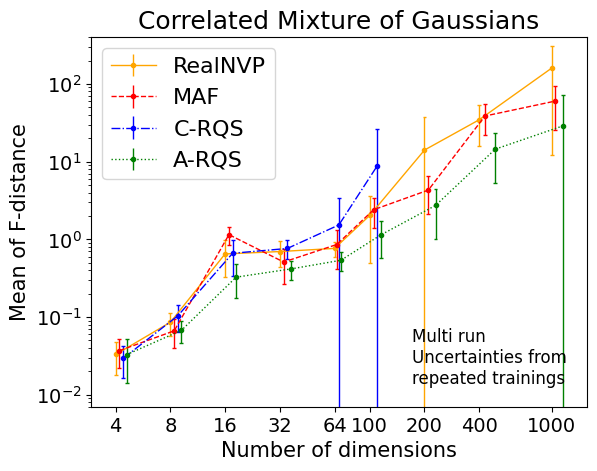

In [69]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_FN[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean of F-distance', fontsize=fontsize_y)
plt.ylim(0.007,400)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="upper left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 0.03, 'Multi run\nUncertainties from\nrepeated trainings', fontsize=12, ha='left', va='center')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_FN_corr_2.pdf')
plt.show()
plt.close()

### Training time

In [114]:
MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","time",replicas=False).astype(np.float)
CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","time",replicas=False).astype(np.float)
MAFN_corr_time = extract_lines(df_bests_corr,"MAFN","time",replicas=False).astype(np.float)
RealNVPN_corr_time = extract_lines(df_bests_corr,"RealNVPN","time",replicas=False).astype(np.float)

/tmp/ipykernel_4874/1616114824.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","time",replicas=False).astype(np.float)
/tmp/ipykernel_4874/1616114824.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","time",replica

In [115]:
MsplineN_corr_time

array([[4.00000000e+00, 1.87858905e+03, 1.87858905e+03],
       [8.00000000e+00, 1.01741950e+03, 1.01741950e+03],
       [1.60000000e+01, 9.80492019e+02, 9.80492019e+02],
       [3.20000000e+01, 1.14884210e+03, 1.14884210e+03],
       [6.40000000e+01, 9.99525520e+02, 9.99525520e+02],
       [1.00000000e+02, 1.21354914e+03, 1.21354914e+03],
       [2.00000000e+02, 1.55465228e+03, 1.55465228e+03],
       [4.00000000e+02, 1.89409803e+03, 1.89409803e+03],
       [1.00000000e+03, 7.52128321e+03, 7.52128321e+03]])

In [116]:
df_bests_corr[0]

ndims  nsamples  nbijectors  bijector activation  spline_knots   ks_mean  \
0      4    100000           2  MsplineN       relu             8  0.495217   
1      4    100000           5  CsplineN       relu             8  0.548395   
2      4    100000          10  RealNVPN       relu             8  0.307817   
3      4    100000           5      MAFN       relu             8  0.319240   

     ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
0  0.251435  0.216209  0.066911  0.026842  0.012460  0.027267  0.011680   
1  0.297681  0.218421  0.064449  0.023984  0.010414  0.025026  0.010843   
2  0.255519  0.188032  0.080101  0.026637  0.008139  0.026858  0.011076   
3  0.235655  0.196969  0.076791  0.027648  0.011148  0.027307  0.011358   

    fn_mean    fn_std hidden_layers  batch_size  epochs_output         time  \
0  0.017926  0.010255   128-128-128         512            360  1878.589050   
1  0.022538  0.006425   128-128-128         512            310  8690.510488   
2  0.018490  0.008663   256-256-256         256            337  3307.465860   
3  0.034974  0.014084   256-256-256         512            361   833.398603   

  ks_all_mean ks_all_std ad_all_mean ad_all_std wd_all_mean wd_all_std  \
0    0.339781   0.287386    0.170052   0.097098    0.032241   0.014082   
1    0.294399   0.273805    0.161983   0.099418    0.029477   0.012568   
2    0.283508   0.284873    0.145032   0.102709    0.030964   0.012707   
3    0.298643   0.270425    0.153828   0.099109    0.029494   0.011602   

  swd_all_mean swd_all_std fn_all_mean fn_all_std  time_all_mean  \
0     0.030883    0.017212    0.032783   0.018709   20215.323631   
1     0.029627    0.013598    0.029343   0.013109   52512.935121   
2     0.030783    0.014978    0.032918   0.014931   21241.906413   
3     0.029641    0.013426    0.036954    0.01461    6238.649467   

   time_all_std  epochs_all_mean  epochs_all_std    ks_all   swd_all  \
0   2672.711640            408.0       53.942562 -1.448931  0.936415   
1  11221.151466            331.7       70.878840   0.39306 -0.874127   
2   5995.155463            323.8       91.386870  0.835075  0.792594   
3    675.686475            394.1       42.683603  0.220796 -0.854883   

     fn_all     t_all score_all  
0 -0.069584 -0.373599 -0.238925  
1 -1.174826  1.410518 -0.061344  
2 -0.026125 -0.110254  0.372822  
3  1.270535 -0.926665 -0.072554

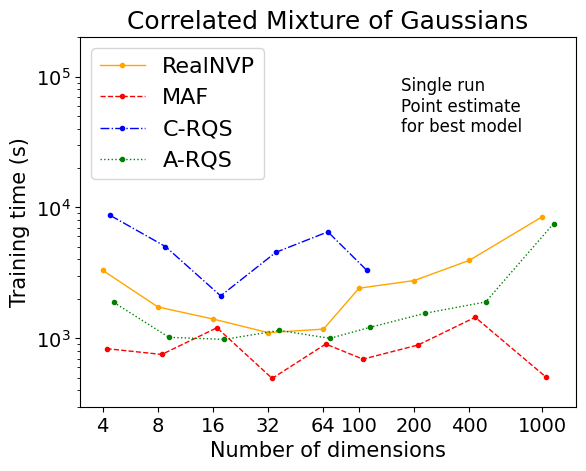

In [117]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y]=[RealNVPN_corr_time[:,i] for i in [0,1]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.plot(x,y,point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
#for i in range(len(x)):
#    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
#    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y]=[MAFN_corr_time[:,i] for i in [0,1]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.plot(x,y,point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
#for i in range(len(x)):
#    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
#    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y]=[CsplineN_corr_time[:,i] for i in [0,1]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.plot(x,y,point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
#for i in range(len(x)):
#    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
#    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y]=[MsplineN_corr_time[:,i] for i in [0,1]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.plot(x,y,point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
#for i in range(len(x)):
#    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
#    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Training time (s)', fontsize=fontsize_y)
plt.ylim(300,200000)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="upper left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 100000, 'Single run\nPoint estimate\nfor best model', fontsize=12, ha='left', va='top')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_training_time_corr_1.pdf')
plt.show()
plt.close()

In [118]:
MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","time",replicas=True).astype(np.float)
CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","time",replicas=True).astype(np.float)
MAFN_corr_time = extract_lines(df_bests_corr,"MAFN","time",replicas=True).astype(np.float)
RealNVPN_corr_time = extract_lines(df_bests_corr,"RealNVPN","time",replicas=True).astype(np.float)

/tmp/ipykernel_4874/1683495883.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","time",replicas=True).astype(np.float)
/tmp/ipykernel_4874/1683495883.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","time",replicas

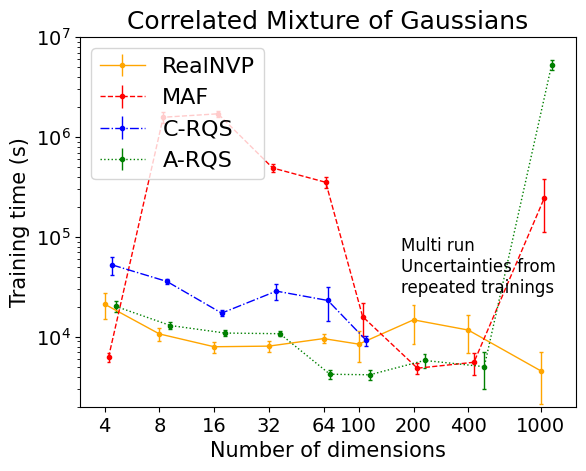

In [119]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_time[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_time[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_time[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_time[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Training time (s)', fontsize=fontsize_y)
plt.ylim(2000,10000000)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="upper left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 100000, 'Multi run\nUncertainties from\nrepeated trainings', fontsize=12, ha='left', va='top')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_training_time_corr_2.pdf')
plt.show()
plt.close()

## Tables

In [561]:
df_bests_corr[0]

run_n  run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0      1         0      4    100000        corr           2  MsplineN   
1      1         0      4    100000        corr           5  CsplineN   
2      4         0      4    100000        corr          10  RealNVPN   
3      2         0      4    100000        corr           5      MAFN   

  activation  knots  range_min  eps_regulariser regulariser   ks_mean  \
0       relu      8        -16                0        None  0.495217   
1       relu      8        -16                0        None  0.548395   
2       relu      8         -5                0        None  0.307817   
3       relu      8         -5                0        None  0.319240   

     ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
0  0.251435  0.216209  0.066911  0.026842  0.012460  0.027267  0.011680   
1  0.297681  0.218421  0.064449  0.023984  0.010414  0.025026  0.010843   
2  0.255519  0.188032  0.080101  0.026637  0.008139  0.026858  0.011076   
3  0.235655  0.196969  0.076791  0.027648  0.011148  0.027307  0.011358   

    fn_mean    fn_std hidden_layers  batch_size  epochs_input  epochs_output  \
0  0.017926  0.010255   128-128-128         512          1000            360   
1  0.022538  0.006425   128-128-128         512          1000            310   
2  0.018490  0.008663   256-256-256         256          1000            337   
3  0.034974  0.014084   256-256-256         512          1000            361   

          time  
0  1878.589050  
1  8690.510488  
2  3307.465860  
3   833.398603

In [731]:
final_string=""
header = r"""\begin{tabular}{lrlrlllrr}
\toprule
\multicolumn{9}{c}{\bf Best Models for Correlated Mixture of Gaussians} \\
\midrule
hidden& \# of	&  algorithm 	&  spline 	& Sliced 		& KS-test	& Frobenius 	& \# of  	& training 	\\
layers & bijec. 	&  		&  knots 	& WD		 	& $p$-value	& Norm 	&	epochs	& time (s)  	\\
\midrule"""
for i in range(9):
    tmp=df_bests_corr[i]
    ndims=tmp["ndims"][0]
    #print("Dimensions:", ndims)
    tmp=tmp[tmp["correlation"]=="corr"]
    tmp=tmp[["hidden_layers","nbijectors","bijector","spline_knots","swd_mean","swd_std", "ks_mean","ks_std","fn_mean","fn_std","epochs_output","time"]]
    for k in ["swd_mean","ks_mean","fn_mean"]:
        #tmp[k]="$"+tmp[k].apply(lambda x: "{:.2e}".format(float(x)))+"\pm "+tmp[k.replace("mean","std")].apply(lambda x: "{:.2e}".format(float(x)))+"$"
        tmp[k]="$"+tmp[k].apply(lambda x: str(format_number(float(x))))+"\pm "+tmp[k.replace("mean","std")].apply(lambda x: str(format_number(float(x))))+"$"
        tmp.pop(k.replace("mean","std"))
    tmp["time"]=tmp["time"].apply(lambda x: int(float(x)))
    tmp.loc[tmp["bijector"]=="RealNVPN","spline_knots"]="--"
    tmp.loc[tmp["bijector"]=="MAFN","spline_knots"]="--"
    tmp.loc[tmp["bijector"]=="MAFN","bijector"]="MAF"
    tmp.loc[tmp["bijector"]=="RealNVPN","bijector"]="RealNVP"
    tmp.loc[tmp["bijector"]=="MsplineN","bijector"]="A-RQS "
    tmp.loc[tmp["bijector"]=="CsplineN","bijector"]="C-RQS"
    tmp['hidden_layers'] = tmp['hidden_layers'].str.replace(r'(\d+)-(\d+)-(\d+)', r'$3\times \1$', regex=True)
    string=tmp.to_latex(index=False).replace(r"\textbackslash ","\\").replace(r"\$","$")
    string=transform_string_1(string)
    string='\n'.join(string.splitlines()[3:-2])
    string=string.strip()
    string="\n"+r"\midrule"+"\n"+r"\multicolumn{9}{l}{\bf "+str(ndims)+r"D} \\"+"\n"+string
    final_string = final_string+string
final_string = final_string+"\n" +r"""\bottomrule
\end{tabular}"""
final_string = align_table_latex(final_string)
final_string = final_string.replace('\n\\midrule\n\\multicolumn{9}{l}{\\bf 4D}','\\multicolumn{9}{l}{\\bf 4D}')
final_string = header+"\n"+final_string
print(final_string)

\begin{tabular}{lrlrlllrr}
\toprule
\multicolumn{9}{c}{\bf Best models for CMoG} \\
\midrule
hidden& \# of	&  algorithm 	&  spline 	& Sliced 		& KS-test	& Frobenius 	& \# of  	& training 	\\
layers & bijec. 	&  		&  knots 	& WD		 	& $p$-value	& Norm 	&	epochs	& time (s)  	\\
\midrule
\multicolumn{9}{l}{\bf 4D} \\
\midrule
$3\times 128$ &           2 &   A-RQS  &            8 & $0.027\pm 0.012$ & $0.495\pm 0.251$    &  $0.018\pm 0.01$ &            360 &  1878 \\
$3\times 128$ &           5 &    C-RQS &            8 & $0.025\pm 0.011$ & $0.548\pm 0.298$    & $0.023\pm 0.006$ &            310 &  8690 \\
$3\times 256$ &          10 &  RealNVP &           -- & $0.027\pm 0.011$ & $0.308\pm 0.256$    & $0.018\pm 0.009$ &            337 &  3307 \\
$3\times 256$ &           5 &      MAF &           -- & $0.027\pm 0.011$ & $0.319\pm 0.236$    & $0.035\pm 0.014$ &            361 &   833 \\
\midrule
\multicolumn{9}{l}{\bf 8D} \\
\midrule
$3\times 128$ &           5 &      MAF &           -- & $0.0

/tmp/ipykernel_416/4097321329.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string=tmp.to_latex(index=False).replace(r"\textbackslash ","\\").replace(r"\$","$")
/tmp/ipykernel_416/4097321329.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string=tmp.to_latex(index=False).replace(r"\textbackslash ","\\").replace(r"\$","$")
/tmp/ipykernel_416/4097321329.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of 

In [659]:
final_string.replace("\n\\midrule\n\\multicolumn{9}{l}{\\bf 4D}",r"\multicolumn{9}{l}{\\bf 4D}")

'\\multicolumn{9}{l}{\\\\bf 4D} \\\\\n\\midrule\n$3\\times 128$ &           2 &   A-RQS  &            8 &  $(2.73\\pm 1.17)$e-02  &  $(4.95\\pm 2.51)$e-01  &  $(1.79\\pm 1.03)$e-02   &            360   &  1878 \\\\\n$3\\times 128$ &           5 &    C-RQS &            8 &  $(2.50\\pm 1.08)$e-02  &  $(5.48\\pm 2.98)$e-01  & $2.25e-02\\pm 6.42e-03$  &            310  &  8690 \\\\\n$3\\times 256$ &          10 &  RealNVP &           -- &  $(2.69\\pm 1.11)$e-02  &  $(3.08\\pm 2.56)$e-01  & $1.85e-02\\pm 8.66e-03$  &            337  &  3307 \\\\\n$3\\times 256$ &           5 &      MAF &           -- &  $(2.73\\pm 1.14)$e-02  &  $(3.19\\pm 2.36)$e-01  &  $(3.50\\pm 1.41)$e-02   &            361   &   833 \\\\\n\\bottomrule\n\\midrule\n\\multicolumn{9}{l}{\\bf 8D} \\\\\n\\midrule\n$3\\times 128$ &           5 &      MAF &           -- &  $(4.12\\pm 2.23)$e-02  &  $(4.30\\pm 2.74)$e-01  &  $(7.88\\pm 2.02)$e-02   &            327   &   752 \\\\\n$3\\times 128$ &           2 &   A-RQS  &      

In [12]:
import re

def transform_string(input_string):
    # Regular expression to find parts like '& $2.42e-02\pm 1.00e-02$'
    matches = re.findall(r"(& \$(\d+\.\d+)(e-\d+)\\pm (\d+\.\d+)(e-\d+)\$)", input_string)

    # If we found matches
    if matches:
        for match in matches:
            # Check if exponents are the same
            if match[2] == match[4]:
                # Now move e-XX at end after $
                new_format = "{} ${}\\pm {}${}".format(match[0].split('$')[0], match[1], match[3], match[2])
                # Replace the original match with the new format
                input_string = input_string.replace(match[0], new_format)
            
    return input_string

input_string = "& $2.42e-02\\pm 1.00e-02$"
print(transform_string(input_string))

&  $2.42\pm 1.00$e-02


In [9]:
import re

def transform_string(input_string):
    # Regular expression to find parts like '& $2.42e-02\pm 1.00e-02$'
    matches = re.findall(r"(& \$(\d+\.\d+)(e-\d+)\\pm (\d+\.\d+)(e-\d+)\$)", input_string)

    # If we found matches
    if matches:
        for match in matches:
            # Now move e-XX at end after $
            new_format = "{} ${}\\pm {}${}".format(match[0].split('$')[0], match[1], match[3], match[2])
            # Replace the original match with the new format
            input_string = input_string.replace(match[0], new_format)
            
    return input_string

input_string = "& $2.42e-02\\pm 1.00e-02$"
print(transform_string(input_string))

&  $2.42\pm 1.00$e-02


In [168]:
tmp.loc[df["bijector"]=="RealNVPN","spline_knots"]

1    --
8    --
Name: spline_knots, dtype: object

# Re-evaluate models

In [47]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    reset_random_seeds(0)
    ncomp=3
    ntest_samples=100000
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
    start=timer()
    ks_mean,ks_std,ad_mean,ad_std,,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'kl_divergence':[kl_divergence],
                    'ks_test_mean':[ks_mean],
                    'ks_test_median':[ks_median],
                    'ad_test_mean':[ad_mean],
                    'ad_test_median':[ad_median],
                    'Wasserstein_median':[w_distance_median],
                    'Wasserstein_mean':[w_distance_mean],
                    'sliced_Wasserstein_mean':[swd_mean],
                    'sliced_Wasserstein_std':[swd_std],
                    'frob_norm':[frob_norm],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    os.rename(run, run.replace(".txt","_old.txt"))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp

In [48]:
run=list(correlated_unc_results_paths.values())[0]+"4D/run_5/results.txt"
pd.read_csv(run)
recompute_metrics(run)

Recomputing metrics for run ../CMoG/results/MAFN_best/4D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]


Metrics for run ../CMoG/results/MAFN_best/4D/run_5/ computed and saved in 1.2691607510000722 s.


run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      5       520      4    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...  Wasserstein_median  \
0       relu             8         -5  ...            0.025781   

  Wasserstein_mean  sliced_Wasserstein_mean  sliced_Wasserstein_std  \
0         0.025781                 0.017306                0.001822   

   frob_norm  hidden_layers  batch_size  epochs_input  epochs_output  \
0   0.010386    128-128-128         512          1000            652   

          time  
0  7184.605105  

[1 rows x 27 columns]

In [105]:
tmp=
X_data_nf = np.load(list(correlated_unc_results_paths.values())[0]+"4D/run_5/nf_sample.npy")
np.shape(X_data_nf)
#arg_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
#X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()

(100000, 4)

In [106]:
ndims=4
reset_random_seeds(0)

### Initialize number of components ###
def MixtureGaussian(ncomp,ndims,seed=0):
    targ_dist = MixtureDistributions.MixMultiNormal1(ncomp,ndims,seed=seed)
    return targ_dist
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
np.shape(X_data_test)
X_data_test[0]

array([4.2423981 , 7.12590057, 6.06101175, 9.83516205])

In [107]:
ks_mean,ks_std,ad_mean,ad_std,,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
{'kl_divergence': kl_divergence,'ks_test_mean': ks_mean,'ks_test_median':ks_median,'ad_test_mean':ad_mean,'ad_test_median':ad_median,'Wasserstein_median':w_distance_median,'Wasserstein_mean':w_distance_mean,'frob_norm':frob_norm}

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]


{'kl_divergence': -1,
 'ks_test_mean': 0.5001360132927927,
 'ks_test_median': 0.5071681592536929,
 'ad_test_mean': 0.20878356996181632,
 'ad_test_median': 0.21184494329967268,
 'Wasserstein_median': 0.02578086762691431,
 'Wasserstein_mean': 0.02578086762691431,
 'frob_norm': 0.010386194116092153}

# Bkp

## Re-evaluate metrics

In [101]:
from scipy.stats import wasserstein_distance
def Wasserstein_distance_old(target_test_data,nf_dist,norm=True):
    print("\nWasserstein_distance_old function")
    ##create data sample from trained normising flow
    #z=base_dist.sample((target_test_data.shape[0]))
    #x_estimated=nf_dist.bijector.forward(z).numpy()
    if norm==False:
        x_estimated=nf_dist.sample(target_test_data.shape[0])
        x_estimated=np.reshape(x_estimated,newshape=target_test_data.shape)
    else:
        x_estimated=nf_dist
    wasserstein_distances=[]
    for dim in range(target_test_data.shape[1]):
        #print(wasserstein_distance(x_target[:,dim], x_estimated[:,dim]))
        ws_distance=wasserstein_distance(target_test_data[:,dim], x_estimated[:,dim])
        wasserstein_distances.append(ws_distance)
    wd_mean = np.mean(wasserstein_distances)
    wd_std = np.std(wasserstein_distances)
    print(len(wasserstein_distances),"WD tests performed with",[len(target_test_data),len(x_estimated)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wasserstein_distances)
    return [wd_mean,wd_std]

def sliced_Wasserstein_distance_old(target_test_data, nf_dist, norm=True, n_slices=None, seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    """
    print("\nsliced_Wasserstein_distance_old function")
    if seed is None:
        np.random.seed(np.random.randint(10e6))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = target_test_data.shape[1]
    else:
        n_slices = int(n_slices)
    if norm==False:
        x_estimated=nf_dist.sample(target_test_data.shape[0])
        x_estimated=np.reshape(x_estimated,newshape=target_test_data.shape)
    else:
        x_estimated=nf_dist
    # Generate random directions
    directions = np.random.randn(n_slices, target_test_data.shape[1])
    directions /= np.linalg.norm(directions, axis=1)[:, None]
    # Compute sliced Wasserstein distance
    ws_distances = []
    for direction in directions:
        target_proj = target_test_data @ direction
        estimated_proj = x_estimated @ direction
        ws_distances.append(wasserstein_distance(target_proj, estimated_proj))
    swd_mean = np.mean(ws_distances)
    swd_std = np.std(ws_distances)
    print(len(ws_distances),"SWD tests performed with",[len(target_test_data),len(x_estimated)],"dimensional samples.")
    print("SWD Mean =",swd_mean)
    print("SWD Std =",swd_std)
    #print("Samples =\n",wasserstein_distances)
    return [swd_mean,swd_std]

def WD(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Wasserstein distance between the target distribution and the distribution of the test data.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nWD function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ad_list that will contain the list of wd for all dimensions and all iterations
    wd_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # The WD test is computed and saved for each dimension
        for dim in range(ndims):
            wd=wasserstein_distance(dist_1_k[:,dim], dist_2_k[:,dim])
            wd_list.append(wd)
    #print(wd_list)
    # Compute the mean and std of the p-values
    wd_mean = np.mean(wd_list)
    wd_std = np.std(wd_list)
    print(len(wd_list),"WD tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wd_list)
    # Return the mean and std of the p-values
    #return wd_list
    return [wd_mean,wd_std]

def SWD(dist_1,dist_2,n_iter=100,batch_size=100000,n_slices=100,seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nSWD function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    if seed is None:
        np.random.seed(np.random.randint(1000000))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = np.max([100,ndims])
    else:
        n_slices = int(n_slices)
    # Define ad_list that will contain the list of swd for all dimensions and all iterations
    swd_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # Generate random directions
        directions = np.random.randn(n_slices, ndims)
        directions /= np.linalg.norm(directions, axis=1)[:, None]
        # Compute sliced Wasserstein distance
        for direction in directions:
            dist_1_proj = dist_1_k @ direction
            dist_2_proj = dist_2_k @ direction
            swd_list.append(wasserstein_distance(dist_1_proj, dist_2_proj))
    # Compute the mean and std of the p-values
    swd_mean = np.mean(swd_list)
    swd_std = np.std(swd_list)
    print(len(swd_list),"WD tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",swd_mean)
    print("WD Std =",swd_std)
    return [swd_mean,swd_std]
    
def WD_new(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Wasserstein distance between the target distribution and the distribution of the test data.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nWD_new function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ad_list that will contain the list of wd for all dimensions and all iterations
    wd_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # The WD test is computed and saved for each dimension
            for dim in range(ndims):
                wd=wasserstein_distance(dist_1_j[:,dim], dist_2_k[:,dim])
                wd_list.append(wd)
    #print(wd_list)
    # Compute the mean and std of the p-values
    wd_mean = np.mean(wd_list)
    wd_std = np.std(wd_list)
    print(len(wd_list),"WD tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wd_list)
    # Return the mean and std of the p-values
    #return wd_list
    return [wd_mean,wd_std]

def SWD_new(dist_1,dist_2,n_iter=100,batch_size=100000,n_slices=100,seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nSWD_new function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    if seed is None:
        np.random.seed(np.random.randint(1000000))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = np.max([100,ndims])
    else:
        n_slices = int(n_slices)
    # Define ad_list that will contain the list of swd for all dimensions and all iterations
    swd_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # Generate random directions
            directions = np.random.randn(n_slices, ndims)
            directions /= np.linalg.norm(directions, axis=1)[:, None]
            # Compute sliced Wasserstein distance
            for direction in directions:
                dist_1_proj = dist_1_j @ direction
                dist_2_proj = dist_2_k @ direction
                swd_list.append(wasserstein_distance(dist_1_proj, dist_2_proj))
    # Compute the mean and std of the p-values
    swd_mean = np.mean(swd_list)
    swd_std = np.std(swd_list)
    print(len(swd_list),"WD tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",swd_mean)
    print("WD Std =",swd_std)
    return [swd_mean,swd_std]

In [53]:
from scipy import stats
def KS_test_1(dist_1,dist_2,n_iter=10,batch_size=100000):
    """
    The Kolmogorov-Smirnov test is a non-parametric test that compares two distributions and returns a p-value that indicates whether the two distributions are the same or not. 
    The test is performed for each dimension of the distributions and for n_iter times and the mean and std of the p-values are returned.
    In the case of numerical distributions, data are split in n_iter batches dist_1_j, dist_2_j of size batch_size=int(nsamples/n_iter) and the mean and std are computed over all pairs of batches dist_1_j, dist_2_j.
    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 10.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.
    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nKS_test_1 function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ks_list that will contain the list of ks for all dimensions and all iterations
    ks_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # The ks test is computed and the p-value saved for each dimension
        for dim in range(ndims):
            p_val=stats.ks_2samp(dist_1_k[:,dim], dist_2_k[:,dim])[1]
            ks_list.append(p_val)
    # Compute the mean and std of the p-values
    ks_mean = np.mean(ks_list)
    ks_std = np.std(ks_list)
    print(len(ks_list),"KS tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]


def KS_test_2(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Kolmogorov-Smirnov test is a non-parametric test that compares two distributions and returns a p-value that indicates whether the two distributions are the same or not. 
    The test is performed for each dimension of the distributions and for n_iter times and the mean and std of the p-values are returned.
    In the case of numerical distributions, data are split in np.ceil(np.sqrt(n_iter)) batches dist_1_j, dist_2_k of size batch_size=int(nsamples/np.ceil(np.sqrt(n_iter))) and the mean and std are computed over all pairs of batches dist_1_j, dist_2_k.
    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.
    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nKS_test_2 function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ks_list that will contain the list of ks for all dimensions and all iterations
    ks_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # The ks test is computed and the p-value saved for each dimension
            for dim in range(ndims):
                p_val=stats.ks_2samp(dist_1_j[:,dim], dist_2_k[:,dim])[1]
                ks_list.append(p_val)
    # Compute the mean and std of the p-values
    ks_mean = np.mean(ks_list)
    ks_std = np.std(ks_list)
    print(len(ks_list),"KS tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]


def KS_test_old(target_test_data,nf_dist,n_iter=100,norm=True):
    """Kolmogorov-Smirnov test between target distribution and trained normalising flow 
    Args:
        target_test_data (_type_): _description_
        nf_dist (_type_): _description_
        n_iter (int, optional): _description_. Defaults to 100.
        norm (bool, optional): _description_. Defaults to True.
    Returns:
        _type_: _description_
    """
    print("\nKS_test_old function")
    ndims=target_test_data.shape[1]
    nsamples=target_test_data.shape[0]
    batch_size=int(nsamples/n_iter)
    ###### Now we compute ks test between two different dists and print out the norm
    big_list=[]
    for dim in range(ndims):
        dim_list=[]
        big_list.append(dim_list)
    for k in range(n_iter):
        ## create new sample from target distribution
        batch_test=target_test_data[k*batch_size:(k+1)*batch_size,:]
        ##create data sample from trained normising flow
        #z=base_dist.sample((nsamples))
        #x_estimated=nf_dist.bijector.forward(z).numpy()
        if norm==False:
            x_estimated=nf_dist.sample(batch_test.shape[0])
            x_estimated=np.reshape(x_estimated,newshape=batch_test.shape)
        else:
            x_estimated=nf_dist[k*batch_size:(k+1)*batch_size,:]
        for dim in range(ndims):
            p_val=stats.ks_2samp(x_estimated[:,dim], batch_test[:,dim])[1]
            big_list[dim].append(p_val)
    ks_test_all=[]
    for dim in range(ndims):
        print(big_list[dim])
        ks_test_dim=float(np.mean(big_list[dim]))
        ks_test_all.append(ks_test_dim)
    ks_mean = np.mean(ks_test_all)
    ks_std = np.std(ks_test_all)
    print(len(ks_test_all),"KS tests performed with",[len(x_estimated),len(batch_test)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]

In [60]:
start=timer()
run_number=1
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=10
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
res_1_KS=KS_test_1(X_data_test,X_data_nf,n_iter=10)
print(res_1_KS)
#res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
#res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)
#print("\nMean =",np.mean(res_1))
#print("Std =",np.std(res_1))
#print("Samples =\n",res_1)
res_2_KS=KS_test_2(X_data_test,X_data_nf)
print(res_2_KS)
#res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#print("\nMean =",np.mean(res_2))
#print("Std =",np.std(res_2))
#print("Samples =\n",res_2)
res_3_KS=KS_test_old(X_data_test,X_data_nf)
print(res_3_KS)
#res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#print("\nMean =",np.mean(res_2))
#print("Std =",np.std(res_2))
#print("Samples =\n",res_2)
end=timer()
print("Done in",end-start,"s.")

Ndims = 4

KS_test_1 function
40 KS tests performed with [10000, 10000] dimensional samples.
KS Mean = 0.21122413585637786
KS Std = 0.2539179980226731
[0.21122413585637786, 0.2539179980226731]

KS_test_2 function
400 KS tests performed with [10000, 10000] dimensional samples.
KS Mean = 0.21122413585637786
KS Std = 0.2539179980226731
[0.21122413585637786, 0.2539179980226731]

KS_test_old function
[0.9802627322900355, 0.6101664688189142, 0.12051526066065596, 0.5005673707894058, 0.647814872077161, 0.5728904395829821, 0.09710349657052789, 0.4659595288557257, 0.19957365535779528, 0.6854967337920594, 0.12051526066065596, 0.37012017606173, 0.9690010280430694, 0.1082872208757189, 0.9883339509983219, 0.06153429181321559, 0.7228251828701066, 0.5362766985932181, 0.005306868855560685, 0.014870029418858987, 0.34112475112661245, 0.21939649929677082, 0.7946637387576738, 0.4006338815832625, 0.5728904395829821, 0.008353146175741297, 0.04839715079181246, 0.21939649929677082, 0.03776014017220749, 0.61016

In [104]:
start=timer()
run_number=9
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 16

Wasserstein_distance_old function
16 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.03373500612157289
WD Std = 0.020203493432553742

sliced_Wasserstein_distance_old function
16 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.03807984620331259
SWD Std = 0.01555921475824211

WD function
1600 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.06871675304284244
WD Std = 0.05109879416747633

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.0755253201607247
WD Std = 0.04681886827398734

WD_new function
1600 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03671606686621906
WD Std = 0.024448967631089943

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03922254648166329
WD Std = 0.020919553847710236
Done in 124.16610923800908 s.


In [106]:
start=timer()
run_number=9
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=10
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 16

Wasserstein_distance_old function
16 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.03373500612157289
WD Std = 0.020203493432553742

sliced_Wasserstein_distance_old function
16 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.03807984620331259
SWD Std = 0.01555921475824211

WD function
160 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03671606686621905
WD Std = 0.024448967631089943

SWD function
1000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.0390375798340183
WD Std = 0.020759058955144655

WD_new function
256 WD tests performed with [25000, 25000] dimensional samples.
WD Mean = 0.03510304074570403
WD Std = 0.024569943344250545

SWD_new function
1600 WD tests performed with [25000, 25000] dimensional samples.
WD Mean = 0.03734863271674013
WD Std = 0.020646115816772684
Done in 59.059644709006534 s.


In [105]:
start=timer()
run_number=21
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 100

Wasserstein_distance_old function
100 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.12023903130116201
WD Std = 0.061544315592497505

sliced_Wasserstein_distance_old function
100 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.11960075962144863
SWD Std = 0.07316267405525886

WD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.14771710188628637
WD Std = 0.10798763503639176

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.14280971260927397
WD Std = 0.11204016134380657

WD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.12117306563900083
WD Std = 0.06593168162435659

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.11388370431228448
WD Std = 0.07391762004393752
Done in 210.4752859250002 s.


In [102]:
start=timer()
ndims=4
ncomp=3
ntest_samples=10000
seed_dist_1 = 0
seed_dist_2 = 1
seed_test_1 = 0
seed_test_2 = 1
n_iter=1000
batch_size=10000
targ_dist_1=MixtureGaussian1(ncomp,ndims,seed=seed_dist_1)
targ_dist_2=MixtureGaussian2(ncomp,ndims,seed=seed_dist_1)
X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test_1).numpy()
X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test_2).numpy()
print(KS_test(X_data_test_1,X_data_test_2,n_iter=n_iter,batch_size=batch_size))
#print(KS_test(targ_dist_1,X_data_test_2,n_iter=n_iter,batch_size=batch_size))
#print(KS_test(X_data_test_1,targ_dist_2,n_iter=n_iter,batch_size=batch_size))
print(KS_test(targ_dist_1,targ_dist_2,n_iter=n_iter,batch_size=batch_size))
end=timer()
print("Done in",end-start,"s.")

Computing KS for samples with lengths: 10
4000
[0.603388352746325, 0.31103815579226224]
Computing KS for samples with lengths: 10000
4000
[0.18471494566976424, 0.239360746698701]
Done in 105.119051691001 s.


In [18]:
res={}
for run_number in [1]:
#for run_number in [13,14,15,16]:
    run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=100000
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    #targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    #targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    #X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    #X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    
    #for seed in np.random.randint(0,1000000,20):
    #    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=int(seed)).numpy().astype("float32")
    #    FN_n,_,_=Metrics.FrobNorm(X_data_test_1,X_data_nf)
    #    FN.append(FN_n)
    FN_val = FN(X_data_test,X_data_nf)
    SWD_val = Metrics.SWD(X_data_test,X_data_nf,n_slices=10,seed=np.random.randint(1000000))
    #for n in [10]:
    #    for seed in np.random.randint(0,1000000,10):     
    #        res_n = Metrics.sliced_Wasserstein_distance(X_data_test,X_data_nf,n_slices=n,seed=seed)
    #        #res_n = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=n,seed=seed)
    #        res.append(res_n)
    #        print(res_n)
    res[run_number]={"SWD":SWD,"FN":FN}
    print(res[run_number])

ValueError: operands could not be broadcast together with shapes (1000,4) (4,4) 

In [290]:
SWD_list = []
for nsamples in [10000,100000,1000000]:
    ndims=4
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    SWD = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=100,seed=np.random.randint(1000000))
    SWD_list.append([nsamples,SWD])
    print([nsamples,SWD])

[10000, [0.03242777552842393, 0.01778819546447554]]
[100000, [0.011425536151111464, 0.004952796941549029]]
[1000000, [0.0022367948656308117, 0.0007193789769005433]]


In [291]:
SWD_list = []
for nsamples in [10000,100000,1000000]:
    ndims=4
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    SWD = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=1000,seed=np.random.randint(1000000))
    SWD_list.append([nsamples,SWD])
    print([nsamples,SWD])

[10000, [0.03468181361910674, 0.017766327001419276]]
[100000, [0.011701384946107625, 0.0052862062353391135]]
[1000000, [0.0022781766000493694, 0.0007203478363419516]]


ValueError: x and y must have same first dimension, but have shapes (3,) and (10,)

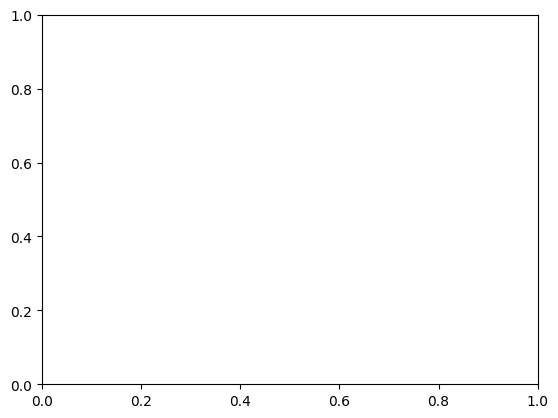

In [223]:
plt.figure(2)
plt.plot([10,100,1000], res[:,0], label="SWD")
plt.fill_between([10,100,1000], res[:,0] - 2 * res[:,1], res[:,0] + 2 * res[:,1], alpha=0.5)

plt.legend()
plt.xscale('log')

plt.xlabel("Number of projections")
plt.ylabel("Distance")
plt.title('Sliced Wasserstein Distance with 95% confidence inverval')

plt.show()

## Other

In [151]:
# Set random seed for reproducibility
np.random.seed(42)

# Define mean and covariance matrices
mean1 = np.random.randn(1000)
cov1 = np.random.randn(1000,1000)
mean2 = np.random.randn(1000)
cov2 = np.random.randn(1000,1000)

# Generate two MVN random samples with same mean and covariance
n_samples = 100000
sample1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
sample2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)

/tmp/ipykernel_10662/2417459388.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  sample1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
/tmp/ipykernel_10662/2417459388.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  sample2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)


In [152]:
from scipy.stats import wasserstein_distance
from timeit import default_timer as timer

In [155]:
start=timer()
res = np.mean([wasserstein_distance(sample1[:,0],sample2[:,0]),wasserstein_distance(sample1[:,1],sample2[:,1])])
end=timer()
print(res)
print("SWD computed in",end-start,"s.")

0.3611000457556382
SWD computed in 0.11974661500426009 s.


In [156]:
n_slices=[10,20,30,50,100]
means=[]
stds=[]
for i in n_slices:
    print("Computing SWD for",i,"slices")
    start=timer()
    swd=[sliced_Wasserstein_distance(sample1, sample2, norm=True, n_slices=i, p=1, seed=None) for k in range(10)]
    means.append(np.mean(swd))
    stds.append(np.std(swd))
    end=timer()
    print("SWD for",i,"slices computed in",end-start,"s.")

Computing SWD for 10 slices
SWD for 10 slices computed in 13.37087254099606 s.
Computing SWD for 20 slices
SWD for 20 slices computed in 28.011276363991783 s.
Computing SWD for 30 slices
SWD for 30 slices computed in 42.616360687999986 s.
Computing SWD for 50 slices
SWD for 50 slices computed in 69.60400968199247 s.
Computing SWD for 100 slices
SWD for 100 slices computed in 135.5928650309943 s.


In [157]:
means

[1.1240666444239884,
 1.178620028730426,
 1.0345398202687348,
 1.0856285500872462,
 1.1349826566549233]

In [158]:
stds

[0.2821306524675983,
 0.24819902027034105,
 0.13102079479750936,
 0.13262808573039866,
 0.10346581086159876]

## Likelihood fit

In [120]:
#def likelihood_uniform(measurements, uncertainties):
#    # Ensure that all measurements are within the interval [0,1]
#    if np.any(measurements < 0) or np.any(measurements > 1):
#        return 0
#    # Compute the likelihood assuming Gaussian uncertainties
#    likelihoods = (1/(np.sqrt(2*np.pi)*uncertainties)) * np.exp(-0.5 * ((measurements - 0.5) / uncertainties)**2)
#    # The total likelihood is the product of individual likelihoods
#    total_likelihood = np.prod(likelihoods)
#    return total_likelihood
#
#def neg_likelihood_uniform(measurements, uncertainties):
#    return -likelihood_uniform(measurements, uncertainties)
#
#def neg_log_likelihood_gaussian(mu, measurements, uncertainties=None):
#    n = len(measurements)
#    if uncertainties is None:    
#        log_likelihood = n*np.log(sigma * np.sqrt(2 * np.pi)) + np.sum((measurements - mu)**2 / (2 * sigma**2))
#    else:
#        log_likelihood = np.sum(np.log(uncertainties * np.sqrt(2 * np.pi)) + ((measurements - mu)**2 / (2 * uncertainties**2)))
#    return log_likelihood



#def gaussian(x, mu, sigma):
#    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x-mu)**2 / (2 * sigma**2))
#
#def weighted_sum_of_squared_differences(params, measurements, uncertainties):
#    mu, sigma = params
#    model_values = norm(loc=mu, scale=np.sqrt(sigma**2 + uncertainties**2)).pdf(measurements)
#    differences = measurements - model_values
#    weighted_squares = differences**2 / uncertainties**2
#    return np.sum(weighted_squares)

In [309]:
uncertainties = ks[:,1]
uncertainties

array([0.26999525, 0.22366441, 0.24493149, 0.20944349, 0.10945168,
       0.295335  , 0.23826307, 0.26175365, 0.30373726, 0.25307937])


Getting best estimates in 100 dimensions through maximum likelihood

-----------------------------------------------------------------------
CsplineN bijector
[1.08631315e-02 2.46483968e-03 1.31752658e-02 5.38419881e-03
 2.06448648e-02 1.95832645e-02 3.71541222e-02 1.75711316e-38
 1.66550282e-02 6.25728167e-03]
[4.61698666e-02 1.70797665e-02 4.65758785e-02 4.74896695e-02
 7.29379842e-02 6.88133990e-02 1.05225969e-01 3.06070358e-37
 5.44194565e-02 3.97474058e-02]
Point 8 is likely an outlier. Deleting it before estimating parameters.
[mean,std] excluding point 8 are [0.0146868885629205, 0.009955484504631013] .
Value of pount 8 is [1.7571131578913516e-38, 3.060703581877197e-37]


/tmp/ipykernel_50/1139947028.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


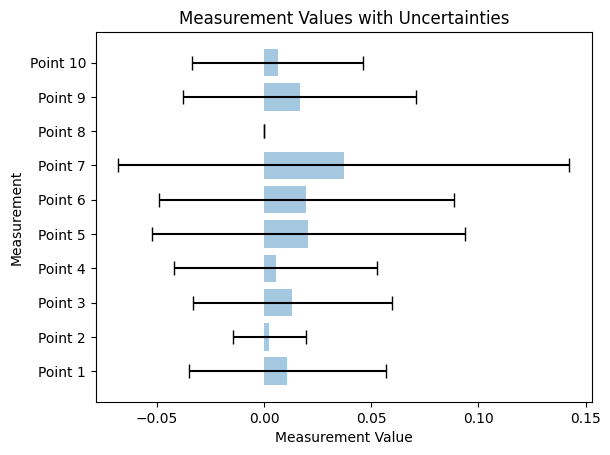

Measurements are compatible. Estimating weighted mean and std.
KS - initial guess:  [0.0146868885629205, 0.009955484504631013]
KS - WM mean estimate:  0.00686132986426756
KS - Sigma_syst estimate:  0.009955484504631013
KS - Sigma_stat estimate:  0.055384377287738186
KS - Sigma_wm estimate:  0.012637420952118046
-.-.-.-.-.-.-.-.
[0.12160115 0.13104592 0.11148076 0.21711406 0.0906318  0.09715026
 0.07501029 2.7012301  0.1030261  0.11925859]
[0.06756744 0.08252081 0.06422475 0.1374442  0.05103157 0.05847157
 0.03678527 1.61334041 0.06090794 0.06861688]
Point 8 is likely an outlier. Deleting it before estimating parameters.
[mean,std] excluding point 8 are [0.11847988195503673, 0.03844886170524288] .
Value of pount 8 is [2.7012300998313785, 1.6133404078332427]


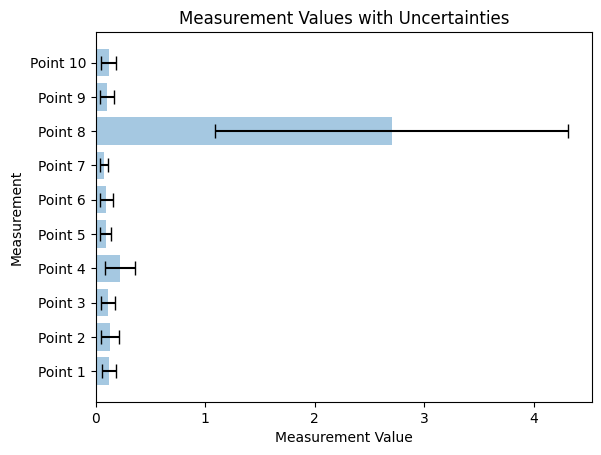

Measurements are compatible. Estimating weighted mean and std.
SWD - initial guess:  [0.11847988195503673, 0.03844886170524288]
SWD - WM mean estimate:  0.1001098105742256
SWD - Sigma_syst estimate:  0.03844886170524288
SWD - Sigma_stat estimate:  0.06973004937151255
SWD - Sigma_wm estimate:  0.01976923425387647
-.-.-.-.-.-.-.-.
[ 3.6177912   2.91910267  3.64655588  3.08639435  2.33717565  2.90541779
  2.10968715 60.19848202  2.14033934  3.60023727]
[0.46941172 0.29256796 0.48668806 0.23493972 0.2221166  0.43992106
 0.2990295  0.20045669 0.15976361 0.65916243]
Point 8 is likely an outlier. Deleting it before estimating parameters.
[mean,std] excluding point 8 are [2.929189033139579, 0.5877283228073377] .
Value of pount 8 is [60.19848201990244, 0.2004566949985247]


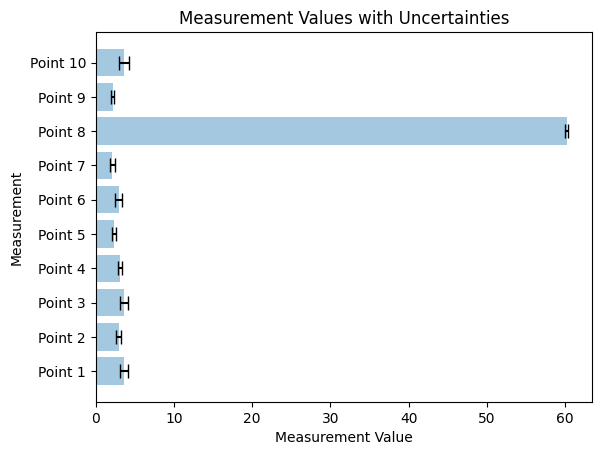

Measurements are compatible. Estimating weighted mean and std.
FN - initial guess:  [2.929189033139579, 0.5877283228073377]
FN - WM mean estimate:  2.5711841654949006
FN - Sigma_syst estimate:  0.5877283228073377
FN - Sigma_stat estimate:  0.3626222953999531
FN - Sigma_wm estimate:  0.09258490185984625
-.-.-.-.-.-.-.-.
Time - Best initial guess:  [3522.6134697787347, 424.4497409444365]
Time - Best MLE estimate:  3522.613470056274
Time - Sigma_tot estimate:  424.44974009309743


In [482]:
# This is our likelihood function
def neg_log_likelihood(params, measurements, uncertainties):
    mu, sigma = params
    #mu, log_sigma = params
    #sigma = np.exp(log_sigma)
    if uncertainties is not None:
        sigma_tot = np.sqrt(sigma**2+uncertainties**2)
    else:
        sigma_tot = sigma
    return np.sum(np.log(sigma_tot * np.sqrt(2 * np.pi)) + ((measurements - mu)**2 / (2 * sigma_tot**2)))

def plot_measurements(measurements,uncertainties):
    # Create y positions
    y_pos = range(len(measurements))
    # Create horizontal bars
    plt.barh(y_pos, measurements, xerr=uncertainties, align='center', alpha=0.4, ecolor='black', capsize=5)
    #Create names on the y-axis
    plt.yticks(y_pos, ['Point '+str(i) for i in range(1,len(measurements)+1)])
    plt.xlabel('Measurement Value')
    plt.ylabel('Measurement')
    plt.title('Measurement Values with Uncertainties')
    # Show graphic
    plt.show()

#def neg_log_likelihood_gaussian(params, measurements):
#    mu, sigma = params
#    #n = len(measurements)
#    #log_likelihood = n*np.log(sigma * np.sqrt(2 * np.pi)) + np.sum((measurements - mu)**2 / (2 * sigma**2))
#    return -np.sum(norm.logpdf(measurements, loc=mu, scale=sigma))
#    #return log_likelihood

# Now for the confidence interval, we find where the likelihood decreases by 0.5 from its maximum
#def tmu(mu, measurements, uncertainties):
#    initial_guess = np.mean(measurements)
#    result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties))
#    mu_mle = result.x[0]
#    return 2*(neg_log_likelihood(mu, measurements, uncertainties)-neg_log_likelihood(mu_mle, measurements, uncertainties))
#
#def solve_high(x,mu_mle, measurements, uncertainties):
#    return tmu(mu_mle+x, measurements, uncertainties)-1
#    
#def solve_low(x,mu_mle, measurements, uncertainties):
#    return tmu(mu_mle-x, measurements, uncertainties)-1

for ndims in [100]:
    print("\n=======================================================================")
    print("Getting best estimates in",ndims,"dimensions through maximum likelihood")
    for bijector in ["CsplineN"]:
        print("\n-----------------------------------------------------------------------")
        print(bijector,"bijector")
        df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
        ### KS
        ks = df_reduced[["ks_mean","ks_std"]].to_numpy()
        measurements = ks[:,0]
        uncertainties = ks[:,1]
        print(measurements)
        print(uncertainties)
        to_delete=[]
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            mean_not_i = np.mean(m)
            std_not_i = np.std(m)
            if measurements[i]<mean_not_i/10 or measurements[i]>10*mean_not_i:
                print("Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("[mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            plot_measurements(measurements,uncertainties)
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        if sigma_0<=2*sigma_stat:
            # Weighted mean
            print("Measurements are compatible. Estimating weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('KS - initial guess: ', initial_guess)
            print('KS - WM mean estimate: ', mu_wm)
            print('KS - Sigma_syst estimate: ', sigma_0)
            print('KS - Sigma_stat estimate: ', sigma_stat)
            print('KS - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("Measurements are not compatible. Performing MLE of mean and std.")
            # ML estimate
            bounds = [(None, None), (1e-10, None)]  # bounds for mu and sigma
            result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties),bounds=bounds, method='L-BFGS-B',options={"maxiter": 100000,"gtol":1e-12,"ftol":1e-12})
            mu_mle, sigma_syst = result.x
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('KS - Best initial guess: ', initial_guess)
            print('KS - Best MLE estimate: ', mu_mle)
            print('KS - Sigma_syst estimate: ', sigma_syst)
            print('KS - Sigma_stat estimate: ', sigma_stat)
            print('KS - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.')
        ## SWD
        swd = df_reduced[["swd_mean","swd_std"]].to_numpy()
        measurements = swd[:,0]
        uncertainties = swd[:,1]
        print(measurements)
        print(uncertainties)
        to_delete=[]
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            mean_not_i = np.mean(m)
            std_not_i = np.std(m)
            if measurements[i]<mean_not_i/10 or measurements[i]>10*mean_not_i:
                print("Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("[mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            plot_measurements(measurements,uncertainties)
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        if sigma_0<=2*sigma_stat:
            # Weighted mean
            print("Measurements are compatible. Estimating weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('SWD - initial guess: ', initial_guess)
            print('SWD - WM mean estimate: ', mu_wm)
            print('SWD - Sigma_syst estimate: ', sigma_0)
            print('SWD - Sigma_stat estimate: ', sigma_stat)
            print('SWD - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("Measurements are not compatible. Performing MLE of mean and std.")
            # ML estimate
            bounds = [(None, None), (1e-10, None)]  # bounds for mu and sigma
            result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties),bounds=bounds, method='L-BFGS-B',options={"maxiter": 100000,"gtol":1e-12,"ftol":1e-12})
            mu_mle, sigma_syst = result.x
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('SWD - Best initial guess: ', initial_guess)
            print('SWD - Best MLE estimate: ', mu_mle)
            print('SWD - Sigma_syst estimate: ', sigma_syst)
            print('SWD - Sigma_stat estimate: ', sigma_stat)
            print('SWD - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.')
        ### FN
        fn = df_reduced[["fn_mean","fn_std"]].to_numpy()
        measurements = fn[:,0]
        uncertainties = fn[:,1]
        print(measurements)
        print(uncertainties)
        to_delete=[]
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            mean_not_i = np.mean(m)
            std_not_i = np.std(m)
            if measurements[i]<mean_not_i/10 or measurements[i]>10*mean_not_i:
                print("Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("[mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            plot_measurements(measurements,uncertainties)
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        if sigma_0<=2*sigma_stat:
            # Weighted mean
            print("Measurements are compatible. Estimating weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('FN - initial guess: ', initial_guess)
            print('FN - WM mean estimate: ', mu_wm)
            print('FN - Sigma_syst estimate: ', sigma_0)
            print('FN - Sigma_stat estimate: ', sigma_stat)
            print('FN - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("Measurements are not compatible. Performing MLE of mean and std.")
            # ML estimate
            bounds = [(None, None), (1e-10, None)]  # bounds for mu and sigma
            result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties),bounds=bounds, method='L-BFGS-B',options={"maxiter": 100000,"gtol":1e-12,"ftol":1e-12})
            mu_mle, sigma_syst = result.x
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('FN - Best initial guess: ', initial_guess)
            print('FN - Best MLE estimate: ', mu_mle)
            print('FN - Sigma_syst estimate: ', sigma_syst)
            print('FN - Sigma_stat estimate: ', sigma_stat)
            print('FN - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.')
        ### TIME
        time = df_reduced["time"].to_numpy()
        measurements = time
        uncertainties = None
        mean = np.mean(measurements)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, None),method='Powell')
        mu_mle = result.x[0]
        sigma_tot_mle = result.x[1]
        print('Time - Best initial guess: ', initial_guess)
        print('Time - Best MLE estimate: ', mu_mle)
        print('Time - Sigma_tot estimate: ', sigma_tot_mle)

In [440]:
measurements

array([1.08631315e-02, 2.46483968e-03, 1.31752658e-02, 5.38419881e-03,
       2.06448648e-02, 1.95832645e-02, 3.71541222e-02, 1.75711316e-38,
       1.66550282e-02, 6.25728167e-03])

In [449]:
from scipy import stats
# Calculate z-scores
z_scores = np.abs(stats.zscore(measurements))

# Chose a threshold
threshold = 0.01

# Find outliers
outliers = measurements[z_scores > threshold]

print("Outliers: ", z_scores)

Outliers:  [0.22597518 1.03181403 0.00411962 0.75169361 0.71260863 0.61074521
 2.29671661 1.26832207 0.32977301 0.66791894]


In [407]:
[measurements, uncertainties]

[array([0.12160115, 0.13104592, 0.11148076, 0.21711406, 0.0906318 ,
        0.09715026, 0.07501029, 0.1030261 , 0.11925859]),
 array([0.06756744, 0.08252081, 0.06422475, 0.1374442 , 0.05103157,
        0.05847157, 0.03678527, 0.06090794, 0.06861688])]

In [350]:
print(neg_log_likelihood([0.028,0],measurements,uncertainties),neg_log_likelihood([0.028,0.001],measurements,uncertainties))

-33.09130639304707 -33.045457251811186


In [417]:
measurements

array([3293.8100225 , 3327.77013644, 3634.90744427, 3354.08085802,
       3525.71747086, 3908.77780004, 3800.7869425 , 2494.55528361,
       3813.23137209, 4072.49736745])

In [425]:
['Measurement '+str(i) for i in range(1,len(measurements)+1)]

['Measurement 1',
 'Measurement 2',
 'Measurement 3',
 'Measurement 4',
 'Measurement 5',
 'Measurement 6',
 'Measurement 7',
 'Measurement 8',
 'Measurement 9',
 'Measurement 10']

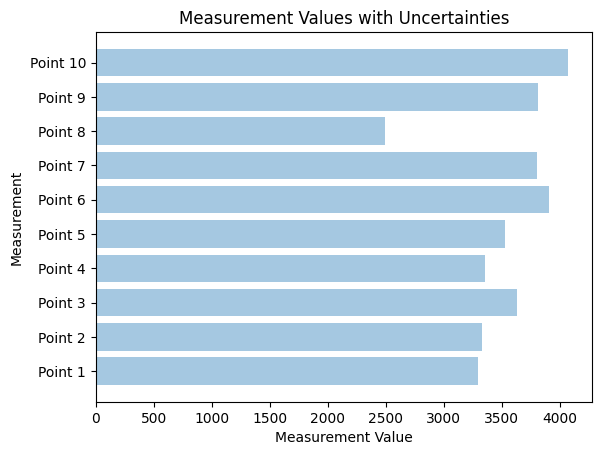

In [427]:
def plot_measurements(measurements,uncertainties):
    # Create y positions
    y_pos = range(len(measurements))
    # Create horizontal bars
    plt.barh(y_pos, measurements, xerr=uncertainties, align='center', alpha=0.4, ecolor='black', capsize=5)
    #Create names on the y-axis
    plt.yticks(y_pos, ['Point '+str(i) for i in range(1,len(measurements)+1)])
    plt.xlabel('Measurement Value')
    plt.ylabel('Measurement')
    plt.title('Measurement Values with Uncertainties')
    # Show graphic
    plt.show()

In [481]:
ndims=4
bijector = "MAFN"
df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
### Check for outliers
to_delete=[]
ks = df_reduced[["ks_mean","ks_std"]].to_numpy()
measurements = ks[:,0]
uncertainties = ks[:,1]
print(measurements,uncertainties)

[0.28561654 0.48163636 0.57410869 0.20632799 0.12295968 0.36141184
 0.60336069 0.32436373 0.47867247 0.43143097] [0.26999525 0.22366441 0.24493149 0.20944349 0.10945168 0.295335
 0.23826307 0.26175365 0.30373726 0.25307937]


/tmp/ipykernel_50/2162307296.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


In [485]:
def neg_log_likelihood(params, measurements, uncertainties=None):
    mu, sigma = params
    #mu, log_sigma = params
    #sigma = np.exp(log_sigma)
    if uncertainties is not None:
        sigma_tot = np.sqrt(sigma**2+uncertainties**2)
    else:
        sigma_tot = sigma
    return np.sum(np.log(sigma_tot * np.sqrt(2 * np.pi)) + ((measurements - mu)**2 / (2 * sigma_tot**2)))


Getting best estimates in 4 dimensions through maximum likelihood

-----------------------------------------------------------------------
MAFN bijector

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
KS - Best initial guess:  [0.3869888971722256, 0.14777412878832172]
KS - Best MLE estimate:  0.32537776668041746
KS - Sigma_syst estimate:  0.07354727740834476
KS - Sigma_stat estimate:  0.24096546563066545
KS - Sigma_tot estimate:  0.2519395912531086
-.-.-.-.-.-.-.-.

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.0301333226607809, 0.006429830020876331]
SWD - WM mean estimate:  0.027295375923345532
SWD - Sigma_syst estimate:  0.006429830020876331
SWD - Sigma_stat estimate:  0.012954493745989431
SWD - Sigma_wm estimate:  0.003621917941988377
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [0.034605985

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


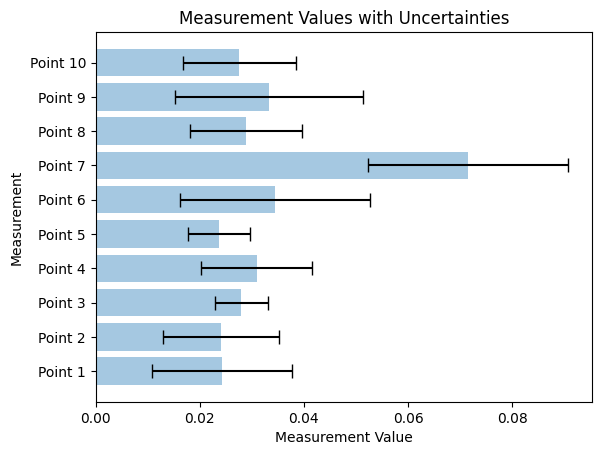


!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
KS - Best initial guess:  [0.41859226713137165, 0.1833850706144501]
KS - Best MLE estimate:  0.36601805266526904
KS - Sigma_syst estimate:  0.09590483574467447
KS - Sigma_stat estimate:  0.24010924693088923
KS - Sigma_tot estimate:  0.258554033000709
-.-.-.-.-.-.-.-.

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.027865349396874788, 0.006253191311235575]
SWD - WM mean estimate:  0.025252059379211232
SWD - Sigma_syst estimate:  0.006253191311235575
SWD - Sigma_stat estimate:  0.012216354910584433
SWD - Sigma_wm estimate:  0.0036928492031783338
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [0.02834344011332962, 0.0037353478958829884]
FN - WM mean estimate:  0.027059903942239165
FN - Sigma_syst estimate:  0.0037353478958829884
FN - Sigma_stat estimate:

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.3491085603835248, 0.08850258573556102]
KS - WM mean estimate:  0.3293265313031836
KS - Sigma_syst estimate:  0.08850258573556102
KS - Sigma_stat estimate:  0.2634426946485159
KS - Sigma_wm estimate:  0.08146653998359352
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.03993927070796754, 0.011500810117727642]
SWD - WM mean estimate:  0.03525840175539176
SWD - Sigma_syst estimate:  0.011500810117727642
SWD - Sigma_stat estimate:  0.024371829976978232
SWD - Sigma_wm estimate:  0.0066688942381738225
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [0.06512553414472928, 0.01253798669165739]
FN - WM mean estimate:  0.06779366932759126
FN - Sigma_syst estimate:  0.01253798669165739
FN - Sigma_stat estimate:  0.021662617470930713
FN - Sigma_wm es

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


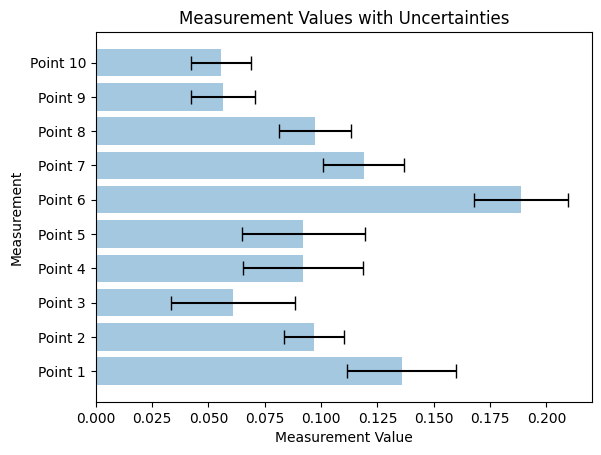

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.23617746087852337, 0.0703188768915547]
KS - WM mean estimate:  0.21601006697272865
KS - Sigma_syst estimate:  0.0703188768915547
KS - Sigma_stat estimate:  0.2310707217590708
KS - Sigma_wm estimate:  0.07447295897369753
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.04202302401412688, 0.00731387624923725]
SWD - WM mean estimate:  0.04005176788328094
SWD - Sigma_syst estimate:  0.00731387624923725
SWD - Sigma_stat estimate:  0.022997247692041367
SWD - Sigma_wm estimate:  0.007374582861117295
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.08952955435257623, 0.026210631496341695]
FN - Best MLE estimate:  0.0875192624780629
FN - Sigma_syst estimate:  0.019146320154013383
FN - Sigma_stat estimate:  0.0199795

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.3290293224637762, 0.08142351692054382]
KS - WM mean estimate:  0.2998587383014766
KS - Sigma_syst estimate:  0.08142351692054382
KS - Sigma_stat estimate:  0.26078834124512507
KS - Sigma_wm estimate:  0.07951581737667117
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.03611148703586569, 0.007060894791138982]
SWD - WM mean estimate:  0.03349828609079167
SWD - Sigma_syst estimate:  0.007060894791138982
SWD - Sigma_stat estimate:  0.020233834594876772
SWD - Sigma_wm estimate:  0.005925651724752074
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [1.1729822751438765, 0.24948970960531064]
FN - Best MLE estimate:  1.1769336460666606
FN - Sigma_syst estimate:  0.19478777835000158
FN - Sigma_stat estimate:  0.1661098

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


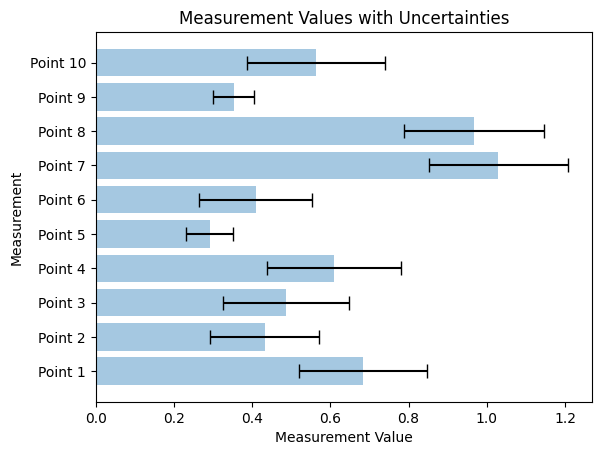

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.09864879316881511, 0.04911917474913033]
KS - WM mean estimate:  0.08361472533250555
KS - Sigma_syst estimate:  0.04911917474913033
KS - Sigma_stat estimate:  0.1837028920418181
KS - Sigma_wm estimate:  0.057976326788974575
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.04389268225169117, 0.00884052889266828]
SWD - WM mean estimate:  0.04108455932973563
SWD - Sigma_syst estimate:  0.00884052889266828
SWD - Sigma_stat estimate:  0.021758378246691287
SWD - Sigma_wm estimate:  0.006895745679696964
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.5325842474862614, 0.19366596710682912]
FN - Best MLE estimate:  0.48233804571156474
FN - Sigma_syst estimate:  0.1321845023704248
FN - Sigma_stat estimate:  0.1383210

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.05859554581413916, 0.0414778677977087]
KS - WM mean estimate:  0.012086822383063888
KS - Sigma_syst estimate:  0.0414778677977087
KS - Sigma_stat estimate:  0.13089846672284094
KS - Sigma_wm estimate:  0.01672843150497093
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.060141435113743126, 0.0177115502939214]
SWD - WM mean estimate:  0.051754110642305284
SWD - Sigma_syst estimate:  0.0177115502939214
SWD - Sigma_stat estimate:  0.031837472936718354
SWD - Sigma_wm estimate:  0.008469949225589643
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.7441053602133791, 0.20884966121013876]
FN - Best MLE estimate:  0.7194329792303544
FN - Sigma_syst estimate:  0.1902418904360511
FN - Sigma_stat estimate:  0.130247663

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


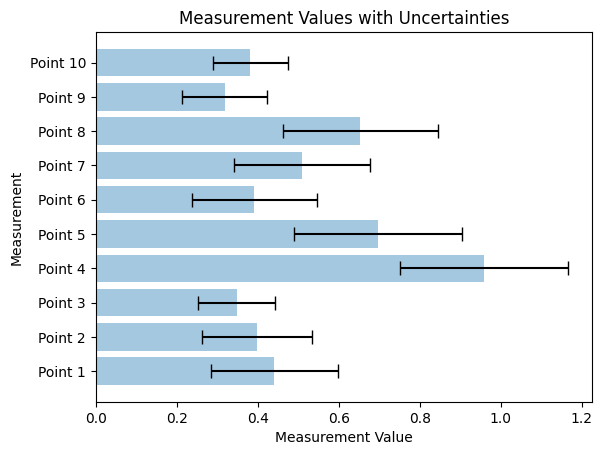

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.25884428946592897, 0.04237679660326585]
KS - WM mean estimate:  0.2522593457504476
KS - Sigma_syst estimate:  0.04237679660326585
KS - Sigma_stat estimate:  0.26364614981635026
KS - Sigma_wm estimate:  0.08699227689572019
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.03728974844623011, 0.00598264137059088]
SWD - WM mean estimate:  0.0354802196061858
SWD - Sigma_syst estimate:  0.00598264137059088
SWD - Sigma_stat estimate:  0.020383013644753593
SWD - Sigma_wm estimate:  0.006419194982053406
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [0.45982502521653956, 0.12601897097368986]
FN - WM mean estimate:  0.4064631478442869
FN - Sigma_syst estimate:  0.12601897097368986
FN - Sigma_stat estimate:  0.14509313300194476
FN - Sigma_wm estima

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.0552418217551115, 0.017138194332149366]
SWD - WM mean estimate:  0.04461810372273839
SWD - Sigma_syst estimate:  0.017138194332149366
SWD - Sigma_stat estimate:  0.02918846707026538
SWD - Sigma_wm estimate:  0.007698420602379498
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.7107492502894232, 0.2162932074371977]
FN - Best MLE estimate:  0.6852658393378751
FN - Sigma_syst estimate:  0.15997768662911127
FN - Sigma_stat estimate:  0.14557346317424774
FN - Sigma_tot estimate:  0.21629723391607714
-.-.-.-.-.-.-.-.

Time - Best initial guess:  [1276.1078770284075, 171.4523599156503]
Time - Best MLE estimate:  1276.1078810446365
Time - Sigma_tot estimate:  171.45235992699614

-----------------------------------------------------------------------
MsplineN bijector
MLE estimates neglig

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


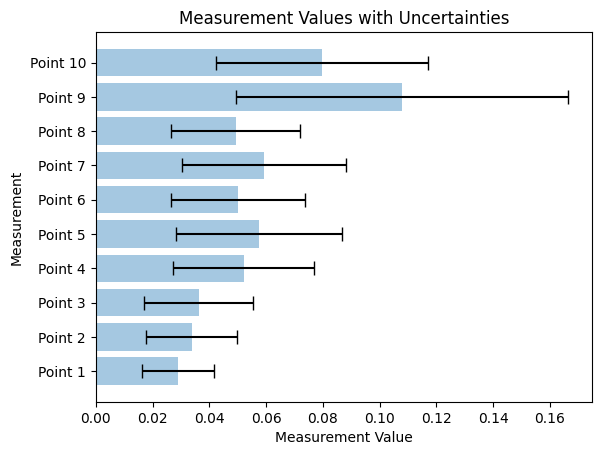

FN - Point 9 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 9 are [0.6987203093161778, 0.21653049810354053] .
FN - Value of pount 9 is [1.1465568123830432, 0.1041805277461543]
[0.39623539 0.49916907 0.45722096 0.72059061 0.91618039 0.64841993
 1.01936457 0.72756248 1.14655681 0.90373938]
[0.05004519 0.09203811 0.07032384 0.07857058 0.04504622 0.05224039
 0.07466901 0.04812896 0.10418053 0.06094408]


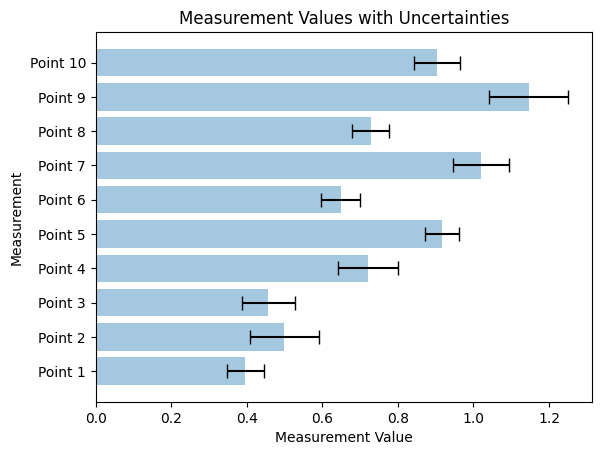

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.12792357356520084, 0.08966028135264019]
KS - WM mean estimate:  0.08293436868105536
KS - Sigma_syst estimate:  0.08966028135264019
KS - Sigma_stat estimate:  0.189666950730674
KS - Sigma_wm estimate:  0.05412298774321071
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.049658965017737866, 0.014616452837636967]
SWD - WM mean estimate:  0.041134786116411325
SWD - Sigma_syst estimate:  0.014616452837636967
SWD - Sigma_stat estimate:  0.023838166281558208
SWD - Sigma_wm estimate:  0.006855938932538669
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.6987203093161778, 0.2069928929029918]
FN - Best MLE estimate:  0.7000921774868623
FN - Sigma_syst estimate:  0.19620513053388025
FN - Sigma_stat estimate:  0.063556

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


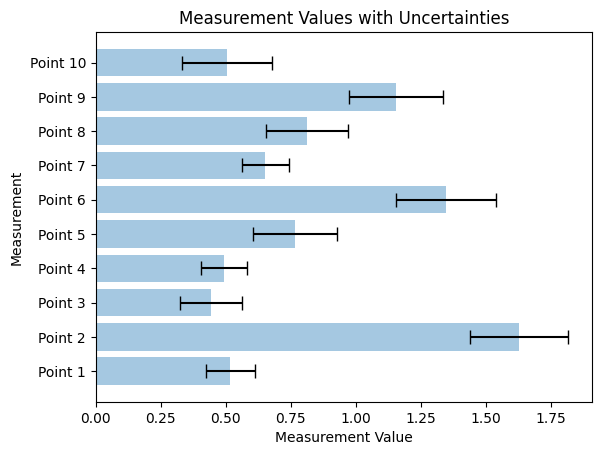

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.24809404977875704, 0.16262872983789506]
KS - WM mean estimate:  0.12209929018456347
KS - Sigma_syst estimate:  0.16262872983789506
KS - Sigma_stat estimate:  0.22481688441779404
KS - Sigma_wm estimate:  0.05808612453624294
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.05616684363069554, 0.026948916360134755]
SWD - WM mean estimate:  0.03954632632831016
SWD - Sigma_syst estimate:  0.026948916360134755
SWD - Sigma_stat estimate:  0.03649640607401239
SWD - Sigma_wm estimate:  0.008887531670336898
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.7430238129845492, 0.2995142257591685]
FN - Best MLE estimate:  0.7115475530967551
FN - Sigma_syst estimate:  0.23069600852047192
FN - Sigma_stat estimate:  0.1396463

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


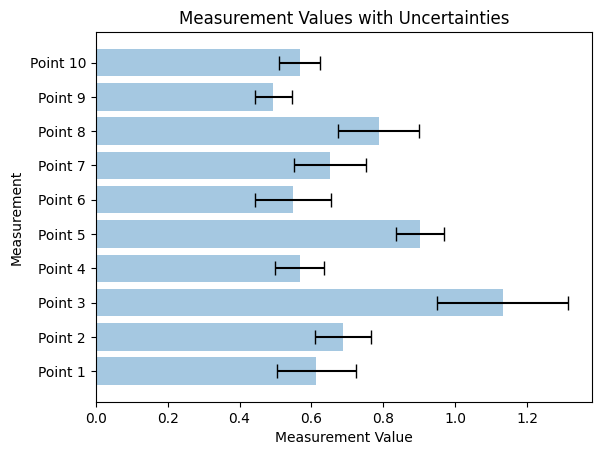

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.22885101094450455, 0.05278050631793715]
KS - WM mean estimate:  0.21655142430089702
KS - Sigma_syst estimate:  0.05278050631793715
KS - Sigma_stat estimate:  0.25578976900708894
KS - Sigma_wm estimate:  0.08369393543124849
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.04121795476226913, 0.007961694002565661]
SWD - WM mean estimate:  0.0383402197954355
SWD - Sigma_syst estimate:  0.007961694002565661
SWD - Sigma_stat estimate:  0.02274001024594529
SWD - Sigma_wm estimate:  0.007074901529422531
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.6466565284316198, 0.12159365922649709]
FN - Best MLE estimate:  0.6416261387656609
FN - Sigma_syst estimate:  0.10527594247624285
FN - Sigma_stat estimate:  0.0833146

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


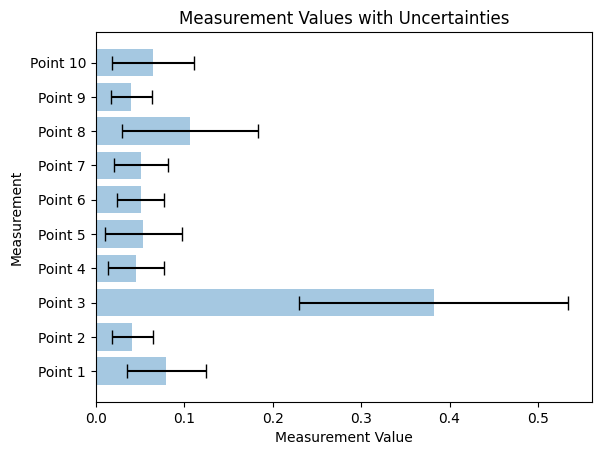

FN - Point 3 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 3 are [0.9125272158257395, 0.2874438682813643] .
FN - Value of pount 3 is [10.049617163973789, 0.0486125348707233]
[ 1.30466749  0.68256793 10.04961716  0.61808963  1.11278584  0.79695542
  0.77378835  1.33458395  0.77760683  0.8116995 ]
[0.13456304 0.06807617 0.04861253 0.14855229 0.17760036 0.09240223
 0.12243435 0.2163402  0.07927195 0.201529  ]


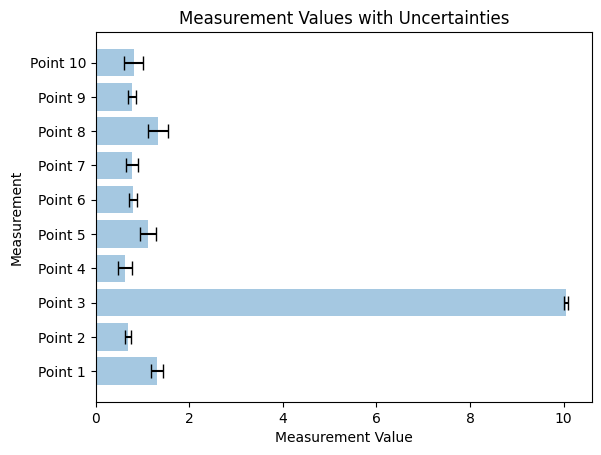

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.16438994416578823, 0.08275331308125326]
KS - WM mean estimate:  0.10158537652768537
KS - Sigma_syst estimate:  0.08275331308125326
KS - Sigma_stat estimate:  0.20650087475746154
KS - Sigma_wm estimate:  0.05738830784843734
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.05922807197402877, 0.020390481703250606]
SWD - WM mean estimate:  0.04950237862118624
SWD - Sigma_syst estimate:  0.020390481703250606
SWD - Sigma_stat estimate:  0.03866249330650022
SWD - Sigma_wm estimate:  0.01065657833519595
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.9125272158257395, 0.25222547654235533]
FN - Best MLE estimate:  0.8801577400396812
FN - Sigma_syst estimate:  0.1859932343154996
FN - Sigma_stat estimate:  0.13786328

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


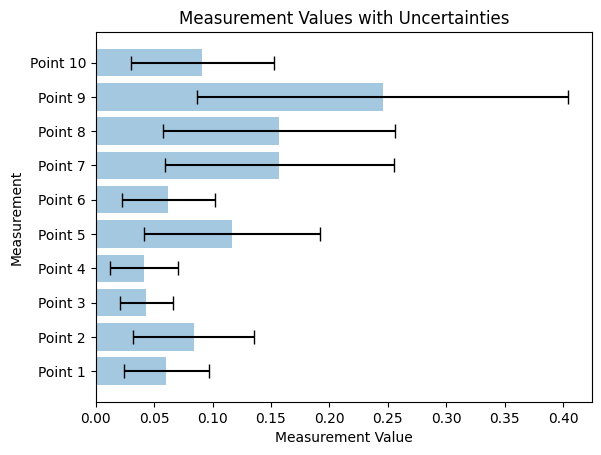

[2.22734854 2.97528863 1.31740242 1.10802382 1.59342631 1.2983582
 2.03779477 2.52512919 2.97811338 3.22963532]
[0.44637105 0.44919389 0.31845081 0.28827187 0.2247908  0.30800852
 0.29106551 0.57261577 0.30085551 0.70135432]


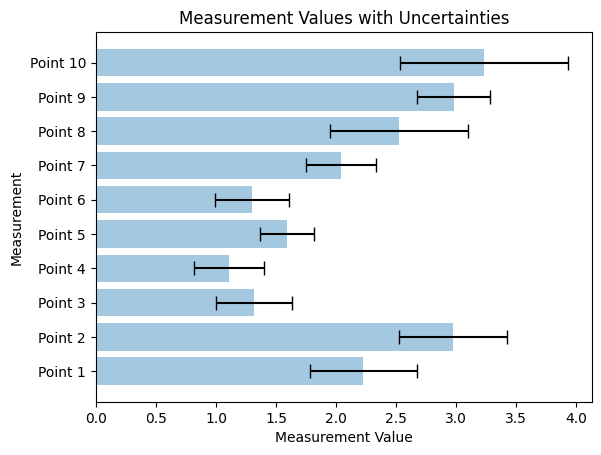

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.11101957104796742, 0.1010652683324179]
KS - WM mean estimate:  0.021369119100073095
KS - Sigma_syst estimate:  0.1010652683324179
KS - Sigma_stat estimate:  0.1510881945416397
KS - Sigma_wm estimate:  0.02466440186770332
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.09029816519813624, 0.04199165945158806]
SWD - WM mean estimate:  0.05924232520795157
SWD - Sigma_syst estimate:  0.04199165945158806
SWD - Sigma_stat estimate:  0.05721309825065492
SWD - Sigma_wm estimate:  0.013566038245810626
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [2.0347119126172344, 0.7226792355293835]
FN - Best MLE estimate:  1.8845020777674053
FN - Sigma_syst estimate:  0.5082489140560621
FN - Sigma_stat estimate:  0.400013616330

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


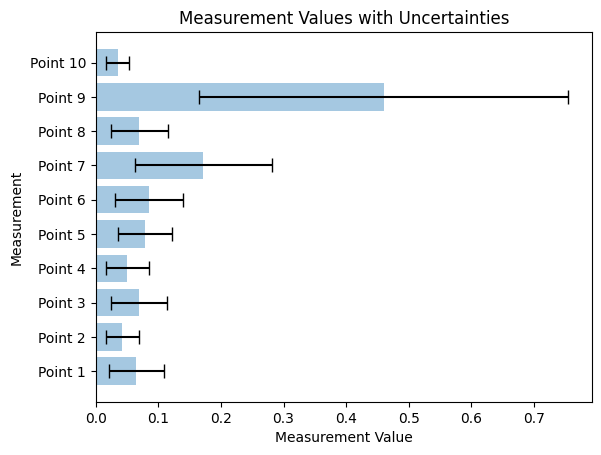

FN - Point 9 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 9 are [1.8674436292616146, 0.6660408811449797] .
FN - Value of pount 9 is [6.358633618958586, 0.3442868345629619]
[2.01071076 1.16278709 2.08281725 1.07298485 2.29545665 2.19884157
 2.70369447 2.20172121 6.35863362 1.07797881]
[0.43643881 0.31494737 0.44158625 0.1644861  0.31001059 0.40296004
 0.38973428 0.45383038 0.34428683 0.1900217 ]


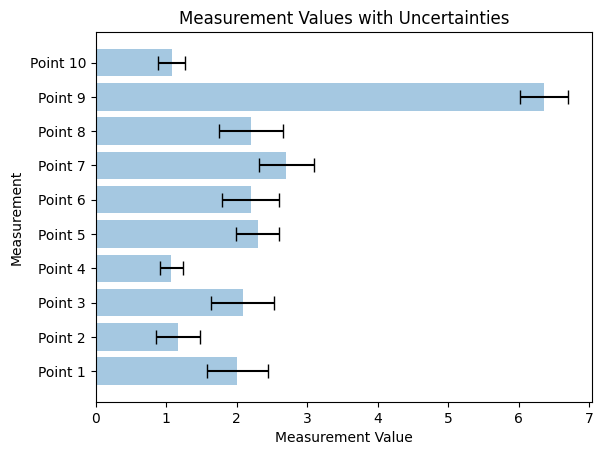

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.11936728302458881, 0.08655387252111715]
KS - WM mean estimate:  0.030835882570617673
KS - Sigma_syst estimate:  0.08655387252111715
KS - Sigma_stat estimate:  0.17531076721897698
KS - Sigma_wm estimate:  0.03172922858337546
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.07396342734250858, 0.0378784999505604]
SWD - WM mean estimate:  0.05133930363947254
SWD - Sigma_syst estimate:  0.0378784999505604
SWD - Sigma_stat estimate:  0.046752024603530666
SWD - Sigma_wm estimate:  0.011505795289587959
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [1.8674436292616146, 0.5697902417579873]
FN - Best MLE estimate:  1.790610444201325
FN - Sigma_syst estimate:  0.5171465408203045
FN - Sigma_stat estimate:  0.34489061418

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


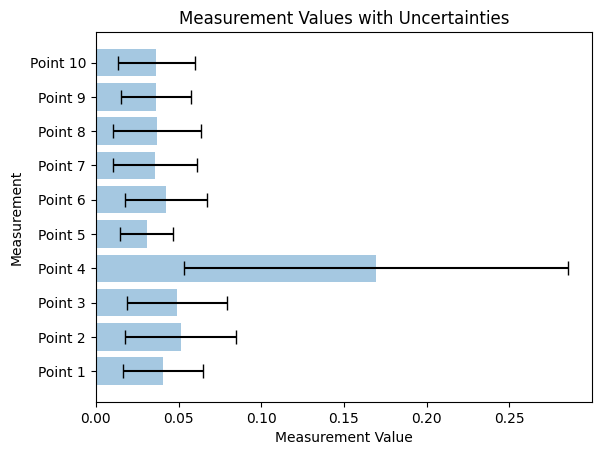

FN - Point 4 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 4 are [1.0623935818193937, 0.35819341527983917] .
FN - Value of pount 4 is [2.4378506041835943, 0.2489993571108877]
[1.25922018 1.43201635 1.47360341 2.4378506  0.793972   1.20694252
 0.78337843 0.81044484 0.92235961 0.87960491]
[0.36908958 0.42157306 0.34581734 0.24899936 0.14330528 0.27694407
 0.13507139 0.19856903 0.11291184 0.16622685]


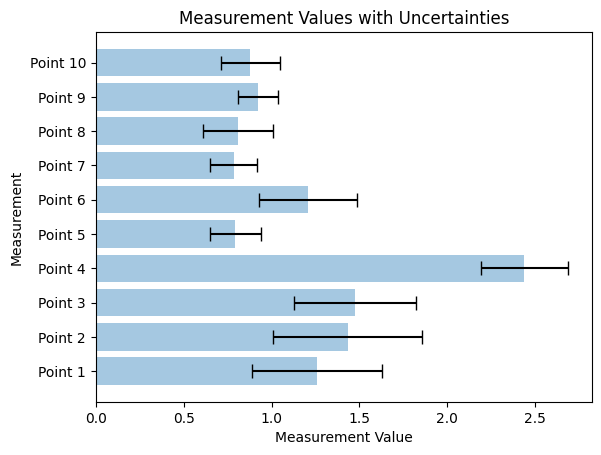

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.3336766851426667, 0.06176847540743108]
KS - WM mean estimate:  0.3270566903745362
KS - Sigma_syst estimate:  0.06176847540743108
KS - Sigma_stat estimate:  0.27439945595537946
KS - Sigma_wm estimate:  0.09095307834912207
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.040007229146544115, 0.006251753170466497]
SWD - WM mean estimate:  0.037779704682404894
SWD - Sigma_syst estimate:  0.006251753170466497
SWD - Sigma_stat estimate:  0.02501102128810022
SWD - Sigma_wm estimate:  0.007837269200784962
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [1.0623935818193937, 0.26494204924224884]
FN - WM mean estimate:  0.9058233883105353
FN - Sigma_syst estimate:  0.26494204924224884
FN - Sigma_stat estimate:  0.24105649398668583
FN - Sigma_wm esti

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


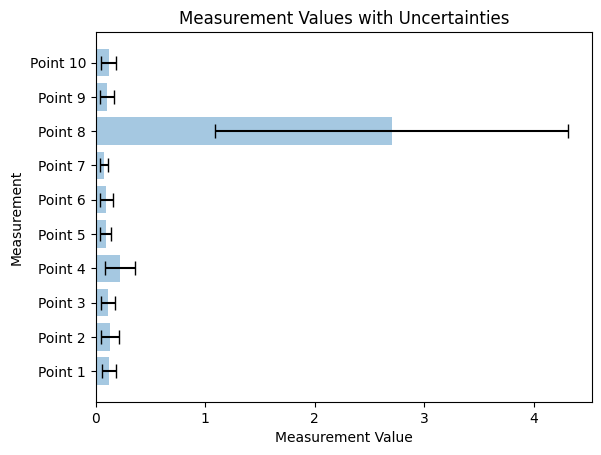

FN - Point 8 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 8 are [2.929189033139579, 0.6905935928974848] .
FN - Value of pount 8 is [60.19848201990244, 0.2004566949985247]
[ 3.6177912   2.91910267  3.64655588  3.08639435  2.33717565  2.90541779
  2.10968715 60.19848202  2.14033934  3.60023727]
[0.46941172 0.29256796 0.48668806 0.23493972 0.2221166  0.43992106
 0.2990295  0.20045669 0.15976361 0.65916243]


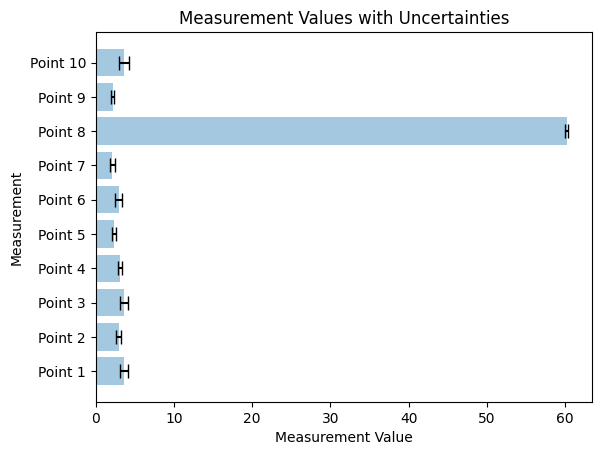

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.0146868885629205, 0.009955484504631013]
KS - WM mean estimate:  0.00686132986426756
KS - Sigma_syst estimate:  0.009955484504631013
KS - Sigma_stat estimate:  0.055384377287738186
KS - Sigma_wm estimate:  0.012637420952118046
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.11847988195503673, 0.03844886170524288]
SWD - WM mean estimate:  0.1001098105742256
SWD - Sigma_syst estimate:  0.03844886170524288
SWD - Sigma_stat estimate:  0.06973004937151255
SWD - Sigma_wm estimate:  0.01976923425387647
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [2.929189033139579, 0.5877283228073377]
FN - Best MLE estimate:  2.7925964267483647
FN - Sigma_syst estimate:  0.44793265533848725
FN - Sigma_stat estimate:  0.362622295

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


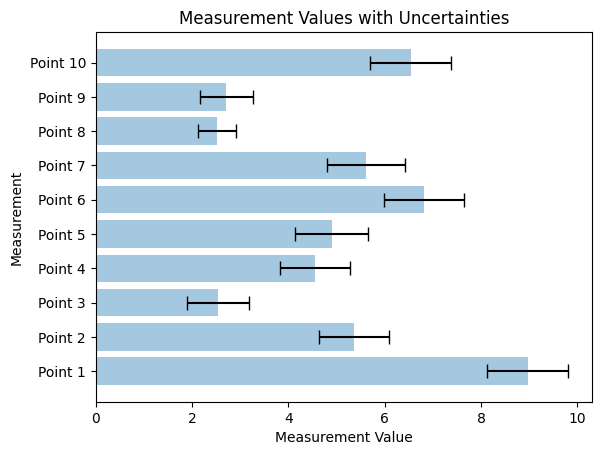

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.0671720773324316, 0.06843513651180426]
KS - WM mean estimate:  0.03326369037732142
KS - Sigma_syst estimate:  0.06843513651180426
KS - Sigma_stat estimate:  0.1346333758724384
KS - Sigma_wm estimate:  0.034340647716053045
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.0922152303256446, 0.022558879713914456]
SWD - WM mean estimate:  0.07334786480370122
SWD - Sigma_syst estimate:  0.022558879713914456
SWD - Sigma_stat estimate:  0.05926621034482747
SWD - Sigma_wm estimate:  0.016735875178097017
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [4.6169706566151865, 1.5853277530929268]
FN - Best MLE estimate:  4.515939364050351
FN - Sigma_syst estimate:  1.4494377380073515
FN - Sigma_stat estimate:  0.69659236684

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


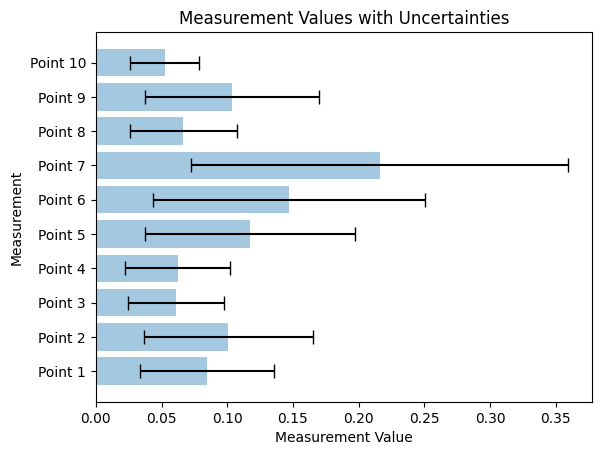

FN - Point 7 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 7 are [4.312911433812559, 1.5959423647980693] .
FN - Value of pount 7 is [18.52519214061784, 0.8398252899802074]
[ 4.10022639  3.59843714  3.62122028  2.45272853  7.50792006  4.03611585
 18.52519214  3.34202378  6.39324112  3.76428976]
[0.5003621  0.35842718 0.66937029 0.45943502 0.81162951 0.32107784
 0.83982529 0.65433253 0.78385734 0.25348078]


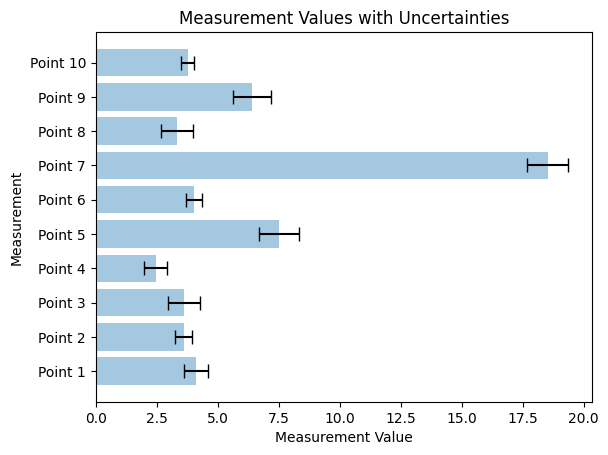

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.06001900703380763, 0.036322520080717464]
KS - WM mean estimate:  0.04200484361317226
KS - Sigma_syst estimate:  0.036322520080717464
KS - Sigma_stat estimate:  0.1337039110356823
KS - Sigma_wm estimate:  0.039629605154886956
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.0884566329775848, 0.029600437029223877]
SWD - WM mean estimate:  0.06916802529491033
SWD - Sigma_syst estimate:  0.029600437029223877
SWD - Sigma_stat estimate:  0.05641311121984586
SWD - Sigma_wm estimate:  0.014822534805293566
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [4.312911433812559, 1.5037176749721994]
FN - Best MLE estimate:  4.199310536815987
FN - Sigma_syst estimate:  1.2209023362189473
FN - Sigma_stat estimate:  0.534663619

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


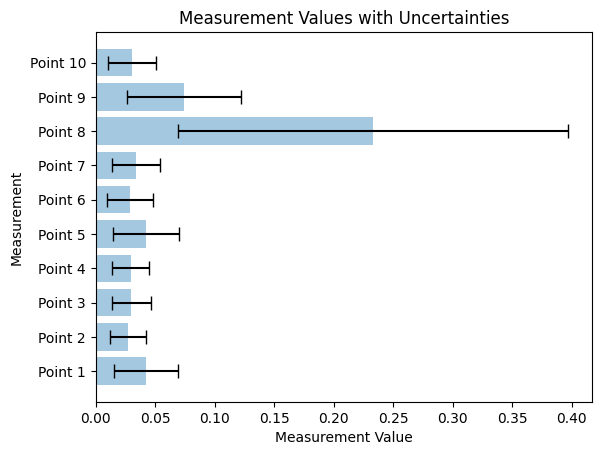

FN - Point 8 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 8 are [2.224950153524531, 0.9178593427942209] .
FN - Value of pount 8 is [6.411930142206792, 0.4264159540263177]
[1.87991001 1.65974745 1.56960864 1.78471655 3.30173011 1.88997511
 2.37985148 6.41193014 3.38830671 2.17070532]
[0.46486687 0.45269663 0.42208534 0.5715673  0.96082662 0.66597191
 0.79041668 0.42641595 0.82769387 0.74435566]


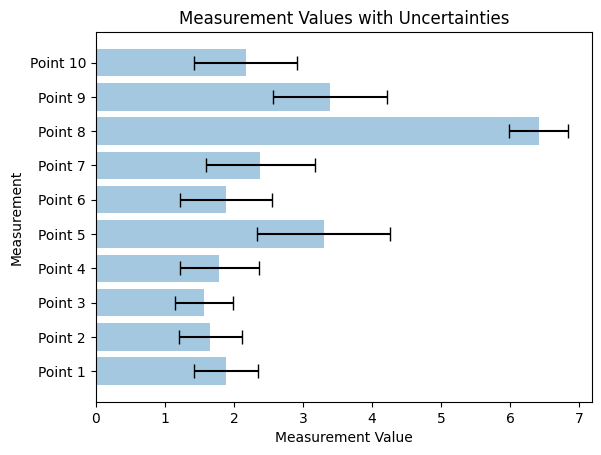

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.40770949916159344, 0.13617898986875354]
KS - WM mean estimate:  0.3413661205091595
KS - Sigma_syst estimate:  0.13617898986875354
KS - Sigma_stat estimate:  0.2690430809101
KS - Sigma_wm estimate:  0.0842817682021764
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.03746764452980385, 0.01402241377682074]
SWD - WM mean estimate:  0.031815807347340776
SWD - Sigma_syst estimate:  0.01402241377682074
SWD - Sigma_stat estimate:  0.023363114253624962
SWD - Sigma_wm estimate:  0.006624419323303574
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [2.224950153524531, 0.6423726575445206]
FN - WM mean estimate:  1.9550392132145642
FN - Sigma_syst estimate:  0.6423726575445206
FN - Sigma_stat estimate:  0.6556089855957048
FN - Sigma_wm estimate:  0.1

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsa

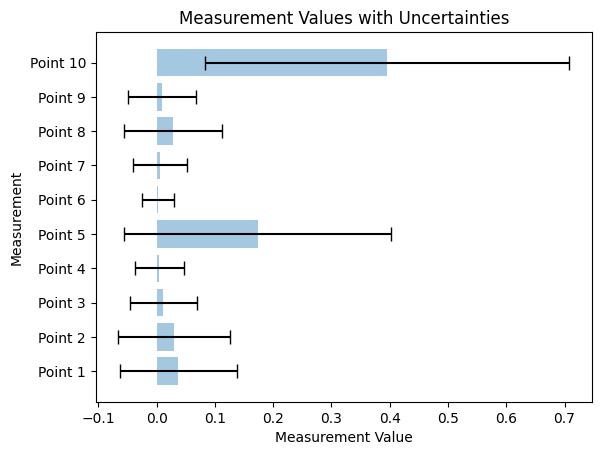

[0.08302342 0.09813457 0.13032919 0.22250496 0.04875051 0.2107764
 0.21636634 0.0918303  0.14480582 0.02622498]
[0.04395457 0.06066869 0.07995627 0.16080058 0.02573177 0.133216
 0.14048425 0.05029216 0.08788556 0.01473775]


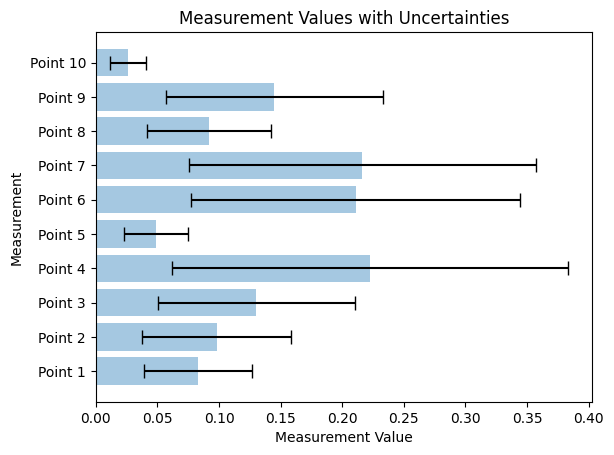

[58.31999934 31.23071785 55.52367376 11.54004905 20.35517011 49.68925489
 54.47120555 35.63296452 52.5658231  10.40033714]
[3.17377981 3.24068524 3.23792367 1.91645317 3.20716518 3.23243005
 3.18699686 3.2284535  3.1630378  0.56540003]


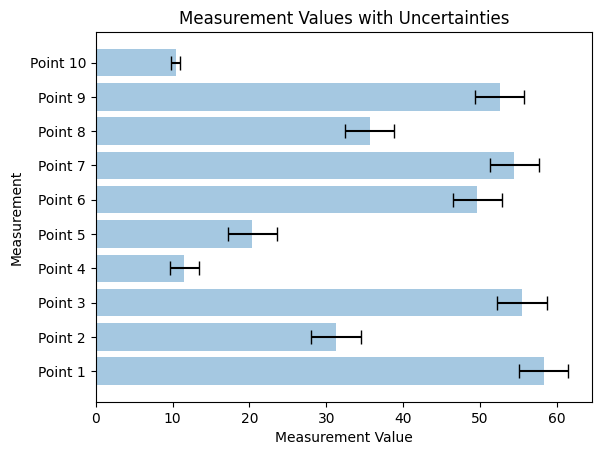

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.03354742052416585, 0.0507731439913863]
KS - WM mean estimate:  0.008708865587443703
KS - Sigma_syst estimate:  0.0507731439913863
KS - Sigma_stat estimate:  0.08228790327856754
KS - Sigma_wm estimate:  0.017358629113609445
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.13850238766944079, 0.06091018441869523]
SWD - WM mean estimate:  0.08000838635847918
SWD - Sigma_syst estimate:  0.06091018441869523
SWD - Sigma_stat estimate:  0.08699887212563422
SWD - Sigma_wm estimate:  0.017884179641134455
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [41.03653979542078, 16.055438361490086]
FN - Best MLE estimate:  40.955015560453226
FN - Sigma_syst estimate:  15.869307028273456
FN - Sigma_stat estimate:  3.06521392113

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype

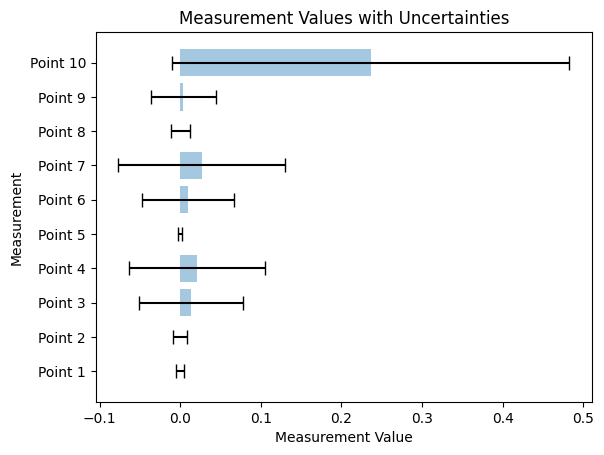

[0.41550221 0.5648001  0.11073752 0.12276484 0.57224781 0.12821176
 0.11773985 0.61314733 0.19853024 0.0449749 ]
[0.21545849 0.34521119 0.06344605 0.08130112 0.34155547 0.0677655
 0.08274337 0.35742901 0.11564182 0.02749993]


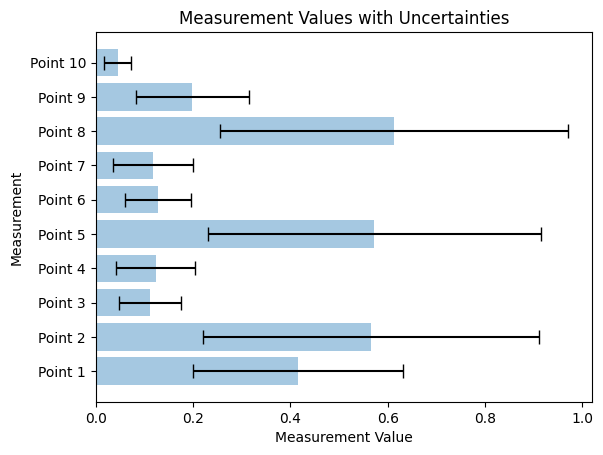

FN - Point 2 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 2 are [53.61466713867881, 29.782510912471796] .
FN - Value of pount 2 is [119.26004283954757, 4.820146078413915]
[ 87.92610025 119.26004284  25.19315668  37.67086211  98.56098357
  43.65681625  34.04741582  94.87492012  43.99341973  16.60832972]
[2.59361401 4.82014608 3.48238104 4.56178318 3.88131062 1.54946181
 4.71543027 1.22112231 2.19370825 2.13746767]


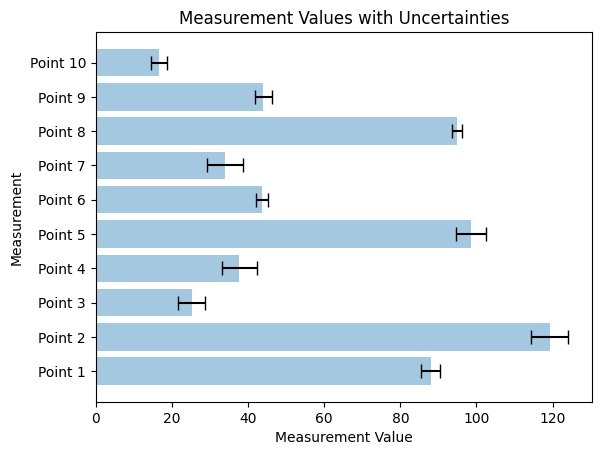

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.009371150127942382, 0.009615608888167709]
KS - WM mean estimate:  0.00012619724753948225
KS - Sigma_syst estimate:  0.009615608888167709
KS - Sigma_stat estimate:  0.04609503628852653
KS - Sigma_wm estimate:  0.001979340730158383
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.2848601943490499, 0.20122929380912982]
SWD - WM mean estimate:  0.1423107962219418
SWD - Sigma_syst estimate:  0.20122929380912982
SWD - Sigma_stat estimate:  0.16566760462377284
SWD - Sigma_wm estimate:  0.03378200289023952
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [58.240459316188215, 28.207406714957987]
FN - Best MLE estimate:  58.33560200083955
FN - Sigma_syst estimate:  28.01384859064962
FN - Sigma_stat estimate:  3.02485143

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


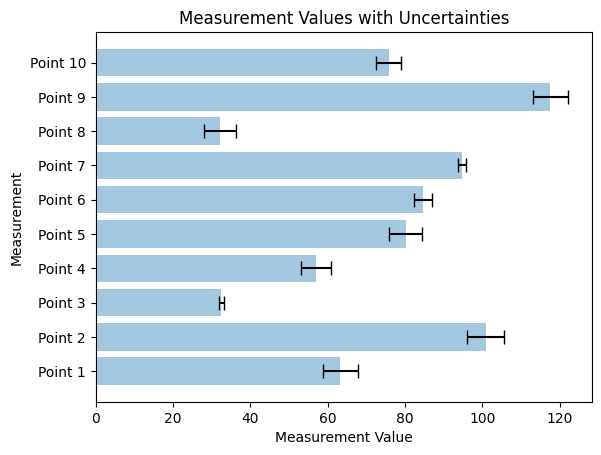

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.0026250470421468777, 0.0033212798724867993]
KS - WM mean estimate:  0.0005286983409926747
KS - Sigma_syst estimate:  0.0033212798724867993
KS - Sigma_stat estimate:  0.0238391988322685
KS - Sigma_wm estimate:  0.003785787001935111
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.265343004107572, 0.08763371120151861]
SWD - WM mean estimate:  0.18074041908145
SWD - Sigma_syst estimate:  0.08763371120151861
SWD - Sigma_stat estimate:  0.16628453604450147
SWD - Sigma_wm estimate:  0.04062221077888496
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [69.02927658471474, 23.482576675083077]
FN - Best MLE estimate:  68.99740150434236
FN - Sigma_syst estimate:  23.283842929334522
FN - Sigma_stat estimate:  3.1822507911

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


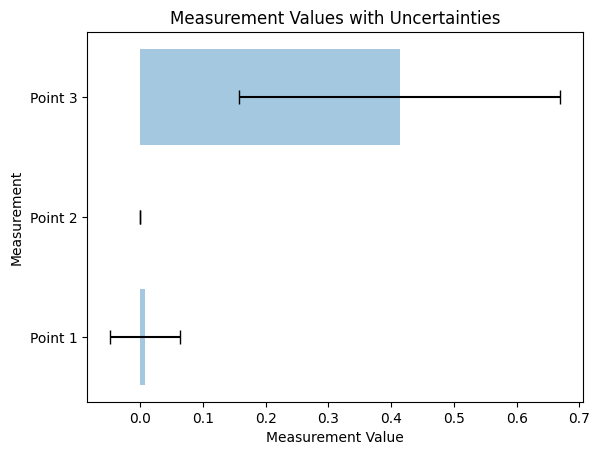

SWD - Point 2 is likely an outlier. Deleting it before estimating parameters.
SWD - [mean,std] excluding point 2 are [0.14172672412519924, 0.14493928652531368] .
SWD - Value of pount 2 is [0.5734698070933711, 0.3462809512451256]
[0.24612311 0.57346981 0.03733034]
[0.17990611 0.34628095 0.02117887]


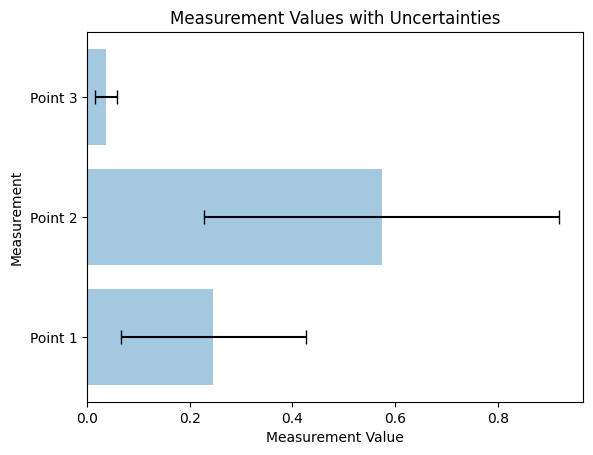

FN - Point 2 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 2 are [37.50661822411756, 28.391458277565874] .
FN - Value of pount 2 is [146.4766067153517, 3.1153937277947046]
FN - Point 3 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 3 are [106.14330290629252, 40.4463637990734] .
FN - Value of pount 3 is [9.203237351001754, 1.5404835131982682]
[ 65.8099991  146.47660672   9.20323735]
[2.92875995 3.11539373 1.54048351]


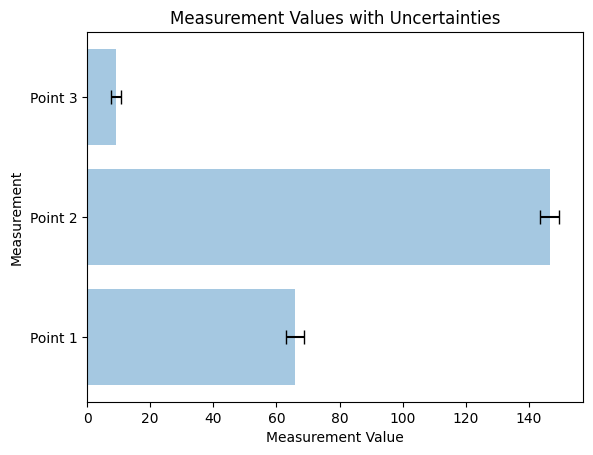

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.0076200020892635, 0.0]
KS - WM mean estimate:  0.007620002089263501
KS - Sigma_syst estimate:  0.0
KS - Sigma_stat estimate:  0.0561502969160367
KS - Sigma_wm estimate:  0.0561502969160367
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.2461231051407361, 0.0]
SWD - WM mean estimate:  0.2461231051407361
SWD - Sigma_syst estimate:  0.0
SWD - Sigma_stat estimate:  0.1799061068647828
SWD - Sigma_wm estimate:  0.1799061068647828
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [65.80999909723336, 0.0]
FN - WM mean estimate:  65.80999909723336
FN - Sigma_syst estimate:  0.0
FN - Sigma_stat estimate:  2.928759947660111
FN - Sigma_wm estimate:  2.928759947660111
-.-.-.-.-.-.-.-.
Time - Best initial guess:  [16526.053427842293, 2611.3901383907255

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsa

In [494]:
outlier_threshold = 2
for ndims in [4,8,16,32,64,100,200,400,1000]:
    print("\n=======================================================================")
    print("Getting best estimates in",ndims,"dimensions through maximum likelihood")
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        print("\n-----------------------------------------------------------------------")
        print(bijector,"bijector")
        df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
        ### Check for outliers
        to_delete=[]
        ks = df_reduced[["ks_mean","ks_std"]].to_numpy()
        measurements = ks[:,0]
        uncertainties = ks[:,1]
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            u = np.delete(uncertainties,i)
            mean_not_i = np.mean(m)
            std_not_i = np.sqrt(np.std(m)**2+np.mean(u)**2)
            if measurements[i]>mean_not_i+outlier_threshold*std_not_i or measurements[i]<mean_not_i-outlier_threshold*std_not_i:
                print("KS - Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("KS - [mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("KS - Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            print(measurements)
            print(uncertainties)
            plot_measurements(measurements,uncertainties)
        to_delete = np.unique(to_delete).tolist()
        swd = df_reduced[["swd_mean","swd_std"]].to_numpy()
        measurements = swd[:,0]
        uncertainties = swd[:,1]
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            u = np.delete(uncertainties,i)
            mean_not_i = np.mean(m)
            std_not_i = np.sqrt(np.std(m)**2+np.mean(u)**2)
            if measurements[i]>mean_not_i+outlier_threshold*std_not_i or measurements[i]<mean_not_i-outlier_threshold*std_not_i:
                print("SWD - Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("SWD - [mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("SWD - Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            print(measurements)
            print(uncertainties)
            plot_measurements(measurements,uncertainties)
        to_delete = np.unique(to_delete).tolist()
        fn = df_reduced[["fn_mean","fn_std"]].to_numpy()
        measurements = fn[:,0]
        uncertainties = fn[:,1]
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            u = np.delete(uncertainties,i)
            mean_not_i = np.mean(m)
            std_not_i = np.sqrt(np.std(m)**2+np.mean(u)**2)
            if measurements[i]>mean_not_i+outlier_threshold*std_not_i or measurements[i]<mean_not_i-outlier_threshold*std_not_i:
                print("FN - Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("FN - [mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("FN - Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            print(measurements)
            print(uncertainties)
            plot_measurements(measurements,uncertainties)
        to_delete = np.unique(to_delete).tolist()
        ### KS
        ks = df_reduced[["ks_mean","ks_std"]].to_numpy()
        measurements = ks[:,0]
        uncertainties = ks[:,1]
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties), method='Powell',options={"maxiter": 100000,"xtol":1e-12,"ftol":1e-12})
        mu_mle, sigma_syst = result.x
        if sigma_syst<0.1*sigma_stat:
            print("MLE estimates negligible systematic uncertainty. Computing weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('KS - initial guess: ', initial_guess)
            print('KS - WM mean estimate: ', mu_wm)
            print('KS - Sigma_syst estimate: ', sigma_0)
            print('KS - Sigma_stat estimate: ', sigma_stat)
            print('KS - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("MLE estimates non-negligible systematic uncertainty. Combining uncertainties.")
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('KS - Best initial guess: ', initial_guess)
            print('KS - Best MLE estimate: ', mu_mle)
            print('KS - Sigma_syst estimate: ', sigma_syst)
            print('KS - Sigma_stat estimate: ', sigma_stat)
            print('KS - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.\n')
        ## SWD
        swd = df_reduced[["swd_mean","swd_std"]].to_numpy()
        measurements = swd[:,0]
        uncertainties = swd[:,1]
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties), method='Powell',options={"maxiter": 100000,"xtol":1e-12,"ftol":1e-12})
        mu_mle, sigma_syst = result.x
        if sigma_syst<0.1*sigma_stat:
            print("MLE estimates negligible systematic uncertainty. Computing weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('SWD - initial guess: ', initial_guess)
            print('SWD - WM mean estimate: ', mu_wm)
            print('SWD - Sigma_syst estimate: ', sigma_0)
            print('SWD - Sigma_stat estimate: ', sigma_stat)
            print('SWD - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("MLE estimates non-negligible systematic uncertainty. Combining uncertainties.")
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('SWD - Best initial guess: ', initial_guess)
            print('SWD - Best MLE estimate: ', mu_mle)
            print('SWD - Sigma_syst estimate: ', sigma_syst)
            print('SWD - Sigma_stat estimate: ', sigma_stat)
            print('SWD - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.\n')
        ### FN
        fn = df_reduced[["fn_mean","fn_std"]].to_numpy()
        measurements = fn[:,0]
        uncertainties = fn[:,1]
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties), method='Powell',options={"maxiter": 100000,"xtol":1e-12,"ftol":1e-12})
        mu_mle, sigma_syst = result.x
        if sigma_syst<0.1*sigma_stat:
            print("MLE estimates negligible systematic uncertainty. Computing weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('FN - initial guess: ', initial_guess)
            print('FN - WM mean estimate: ', mu_wm)
            print('FN - Sigma_syst estimate: ', sigma_0)
            print('FN - Sigma_stat estimate: ', sigma_stat)
            print('FN - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("MLE estimates non-negligible systematic uncertainty. Combining uncertainties.")
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('FN - Best initial guess: ', initial_guess)
            print('FN - Best MLE estimate: ', mu_mle)
            print('FN - Sigma_syst estimate: ', sigma_syst)
            print('FN - Sigma_stat estimate: ', sigma_stat)
            print('FN - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.\n')
        ### TIME
        time = df_reduced["time"].to_numpy()
        measurements = time
        uncertainties = None
        mean = np.mean(measurements)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, None),method='Powell')
        mu_mle = result.x[0]
        sigma_tot_mle = result.x[1]
        print('Time - Best initial guess: ', initial_guess)
        print('Time - Best MLE estimate: ', mu_mle)
        print('Time - Sigma_tot estimate: ', sigma_tot_mle)

SWD - Maximum Likelihood Estimation (MLE):  0.0301333226607809
SWD - 1sigma uncertainty:  0.006429830020876331


FN - Maximum Likelihood Estimation (MLE):  0.03460598506848076
FN - 1sigma uncertainty:  0.011350725370580572


## Global metrics

In [495]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    start=timer()
    ks_mean,ks_std,ks_list,ad_mean,ad_std,ad_list,wd_mean,wd_std,wd_list,swd_mean,swd_std,swd_list,fn_mean,fn_std,fn_list=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'ks_mean':[ks_mean],
                    'ks_std':[ks_std],
                    'ad_mean':[ad_mean],
                    'ad_std':[ad_std],
                    'wd_mean':[wd_mean],
                    'wd_std':[wd_std],
                    'swd_mean':[swd_mean],
                    'swd_std':[swd_std],
                    'fn_mean':[fn_mean],
                    'fn_std':[fn_std],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    #os.rename(run, run.replace(".txt","_old.txt"))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp_new